# **EDA**

# Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

# Importing Functions

In [ ]:
# from saving_loading_functions.saving_file import saving_file
# from saving_loading_functions.saving_file_json import saving_file_json
from saving_loading_functions.loading_file import loading_file
from saving_loading_functions.loading_file_json import loading_file_json

# Declaring Filepaths

In [ ]:
raw_filepath = 'data/raw/'
uuid_filepath = 'data/processed/uuid_dataframes/'
tokenised_filepath = 'data/processed/tokenised_sentences/'
user_filepath = 'data/processed/user_data/'
adhoc_filepath = 'data/processed/adhoc_fixes/'

# Loading Datasets from S3 Bucket

In [ ]:
df = loading_file(uuid_filepath, 'all_bank_scraped_data_final_cleaned_yymmdd.csv', 1) # review dataset
df = loading_file(uuid_filepath, 'all_bank_scraped_data_filled_dates_uuid_eda_final_cleaned.csv', 1)
user_df = loading_file_json(user_filepath, 'user_data_formatted_gender_picture.json', 0) # user dataset
cc_df = loading_file(raw_filepath, 'country_code.csv', 0) # country codes

# reformatting long abbreviated countries
cc_df.loc[cc_df.loc[:, "Name"] == "United Arab Emirates", "Name"] = "UAE"
cc_df.loc[cc_df.loc[:, "Name"] == "United Kingdom", "Name"] = "UK"
cc_df.loc[cc_df.loc[:, "Name"] == "United States", "Name"] = "USA"

cc_df = cc_df[["Code", "Name"]] # swapping order of country code and name


# Declaring Variables

In [ ]:
# bank names
conven_banks = ['Lloyds Bank', 'HSBC UK', 'Barclays', 'NatWest', 'Santander']
digital_banks = ['Revolut', 'Monzo', 'Wise (formerly TransferWise)', 'Starling Bank', 'N26']
bank_names =[]
bank_names.extend(conven_banks)
bank_names.extend(digital_banks)

# getting 2D array representation of bank names
bank_names_2d = np.reshape(bank_names, (-1, 2))

# colours for plots
colors_dict = {'Santander': ["chocolate", "peru"],
               'Monzo': ["tomato", "lightsalmon"],
               'HSBC UK': ["tab:red", "lightcoral"],
               'Lloyds Bank': ["tab:green", "yellowgreen"],
               'NatWest': ["mediumslateblue", "mediumpurple"],
               'N26': ["mediumturquoise", "paleturquoise"],
               'Barclays': ["tab:blue", "lightsteelblue"],
               'Wise (formerly TransferWise)': ["cyan", "lightcyan"],
               'Starling Bank': ["tab:orange", "wheat"],
               'Revolut': ["darkgrey", "lightgray"]}

colors_poor = [colors_dict[bank][1] for bank in bank_names]

# EDA

# Distribution of Reviews

# 1) Review Frequency Distribution

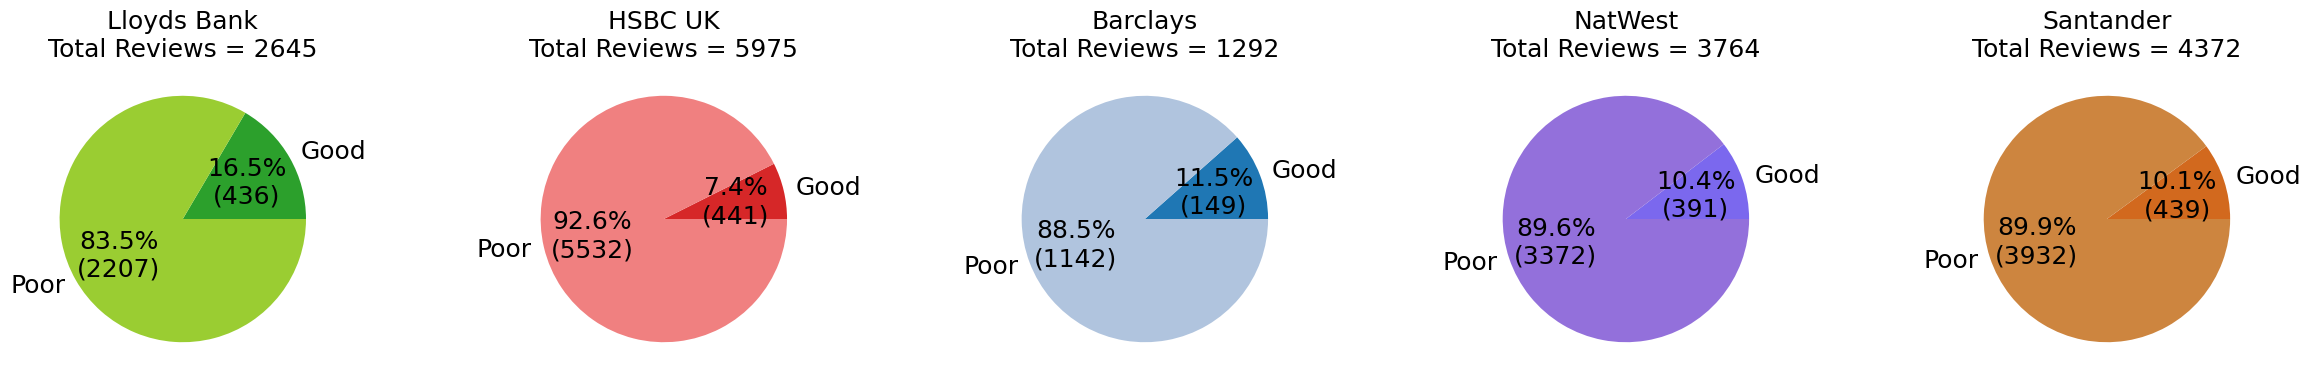

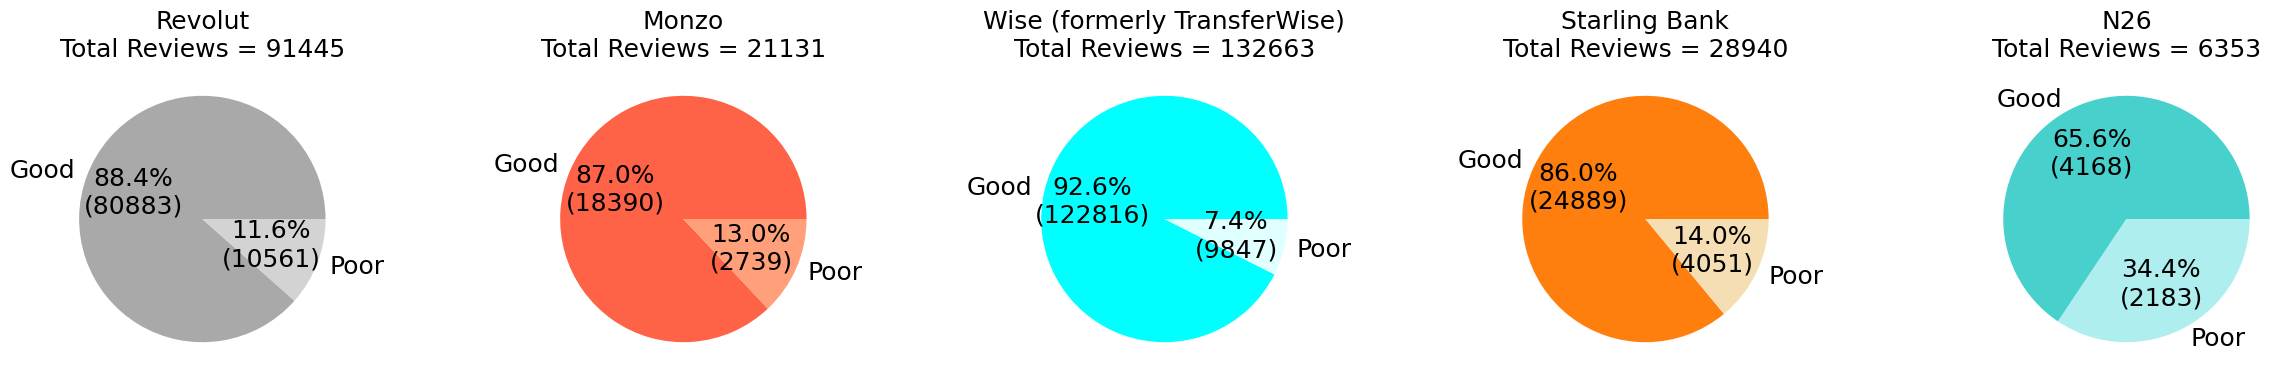

In [ ]:
def label_func(pct, allvals):
  """
  Returns percentage representations and corresponding absolute values
  """
    absolute = int(pct/100.*np.sum(allvals))
    if pct > 0:
        return "{:.1f}%\n({:d})".format(pct, absolute)
    else:
        return ""

def splitting_dataframe(df, bank):
  """
  Takes the dataset as inputs, splits it by declared bank and returns the number of good and poor reviews
  """
    df = df.loc[df.loc[:, "company"] == bank, :]
    df_poor = df.loc[(df['rating'] == 'Rated 1 out of 5 stars') | (df['rating'] == 'Rated 2 out of 5 stars') | (df['rating'] == 'Rated 3 out of 5 stars')]
    df_good = df.loc[(df['rating'] == 'Rated 4 out of 5 stars') | (df['rating'] == 'Rated 5 out of 5 stars')]
    return [len(df_good), len(df_poor)]

# conventional banks - plotting distribution
dist_banks = []
for bank in conven_banks:
    dist_banks.append(splitting_dataframe(df, bank))

fig, ax = plt.subplots(1, len(conven_banks), figsize=(30,4))
plt.suptitle("Review Frequency Distribution")
for i in range(len(dist_banks)):
    ax[i].pie(dist_banks[i], labels=["Good", "Poor"], autopct=lambda pct: label_func(pct, dist_banks[i]), 
              colors=colors_dict[conven_banks[i]], textprops={'fontsize': 18})
    ax[i].set_title(f"{conven_banks[i]}\nTotal Reviews = {sum(dist_banks[i])}", size=18)
plt.show()

# digital banks - plotting distribution
dist_banks = []
for bank in digital_banks:
    dist_banks.append(splitting_dataframe(df, bank))

fig, ax = plt.subplots(1, len(conven_banks), figsize=(30,4))
plt.suptitle("Review Frequency Distribution")
for i in range(len(dist_banks)):
    ax[i].pie(dist_banks[i], labels=["Good", "Poor"], autopct=lambda pct: label_func(pct, dist_banks[i]), 
              colors=colors_dict[digital_banks[i]], textprops={'fontsize': 18})
    ax[i].set_title(f"{digital_banks[i]}\nTotal Reviews = {sum(dist_banks[i])}", size=18)
plt.show()

# 2) Time Series 

In [ ]:
def splitting_bank(df, bank, rating="all"):
  """
  Takes the dataset as inputs and ouputs a dataset split by the declared bank and rating
  """
    df = df.loc[df.loc[:, "company"] == bank, :]
    if rating == "poor":
        df = df.loc[(df['rating'] == 'Rated 1 out of 5 stars') | (df['rating'] == 'Rated 2 out of 5 stars') | (df['rating'] == 'Rated 3 out of 5 stars')]
    elif rating == "good":
        df = df.loc[(df['rating'] == 'Rated 4 out of 5 stars') | (df['rating'] == 'Rated 5 out of 5 stars')]
    return df

# getting start and end years
start_years = []
end_years = []
for bank in bank_names:
    bank_df = splitting_bank(df, bank)
    start_years.append(bank_df.iloc[-1, -1].split("-")[0])
    end_years.append(bank_df.iloc[0, -1].split("-")[0])

start_year = int(min(start_years))
end_year = int(max(end_years))

# getting x axis (YY-MM date)
dates = []
for year in range(start_year, end_year + 1):
    for month in range(1, 13):
        if year == 2022 and month == 7:
            break
        else:
            if month < 10:
                dates.append("{0}-0{1}".format(year, month))
            else:
                dates.append("{0}-{1}".format(year, month))

# defining function to get the distribution of review lengths and ratings over time
def timeseries_processing(df):
  """
  Takes dataset as input and outputs the distribution of reviews, 
  average review length, and average review rating over time
  """

    bank_freq_review_date = []
    bank_avg_review_length = []
    bank_avg_review_rating = []

    # iterating over each date to get the frequency of reviews, average length of reviews and average rating of reviews
    for date in dates:
        review_length_total = 0 # to tally review lengths
        rating_total = 0 # to tally review ratings
        filtered_df = df[df["yy_mm"] == date] # getting all reviews that was posted in the given year and month
        num_reviews = len(filtered_df) 

        # iterating over each review to get cumulative sum
        for i in range(num_reviews):

            if pd.isnull(filtered_df.iloc[i, 4]):
                review_length_total += 0
            else:
                review_length_total += len(filtered_df.iloc[i, 4])
                rating_total += int(filtered_df.iloc[i, 1].split(" ")[1])

        # getting frequency, average review lengths and average review ratings
        bank_freq_review_date.append(num_reviews)
        if num_reviews != 0:
            bank_avg_review_length.append(review_length_total/num_reviews)
            bank_avg_review_rating.append(rating_total/num_reviews)
        else:
            bank_avg_review_length.append(0)
            bank_avg_review_rating.append(0)        

    # getting min-max dist of reviews
    bank_freq_dist_review_date = [(freq - min(bank_freq_review_date))/(max(bank_freq_review_date) - min(bank_freq_review_date)) * 100 for freq in bank_freq_review_date]
    
    return bank_freq_dist_review_date, bank_avg_review_length, bank_avg_review_rating

# defining lists to store series plots
bank_freq_dist = []
bank_avg_review = []
bank_avg_rating = []
bank_freq_dist_good = []
bank_avg_review_good = []
bank_avg_rating_good = []
bank_freq_dist_poor = []
bank_avg_review_poor = []
bank_avg_rating_poor = []

# defining function to append onto list:
def append_list(df, bank, rating='all'):
  """
  Takes the dataset as inputs and appends the timeseries distribution to its 
  corresponding list
  """
    
    df = splitting_bank(df, bank, rating)
    bank_freq_dist_review_date, bank_avg_review_length, bank_avg_review_rating = timeseries_processing(df)
    
    if rating=="poor":
        bank_freq_dist_poor.append(bank_freq_dist_review_date)
        bank_avg_review_poor.append(bank_avg_review_length)
        bank_avg_rating_poor.append(bank_avg_review_rating)
    
    elif rating=="good":
        bank_freq_dist_good.append(bank_freq_dist_review_date)
        bank_avg_review_good.append(bank_avg_review_length)
        bank_avg_rating_good.append(bank_avg_review_rating)
    
    else:
        bank_freq_dist.append(bank_freq_dist_review_date)
        bank_avg_review.append(bank_avg_review_length)
        bank_avg_rating.append(bank_avg_review_rating)

# getting time series plots
for bank in bank_names:
    append_list(df, bank)
    append_list(df, bank, "good")
    append_list(df, bank, "poor")

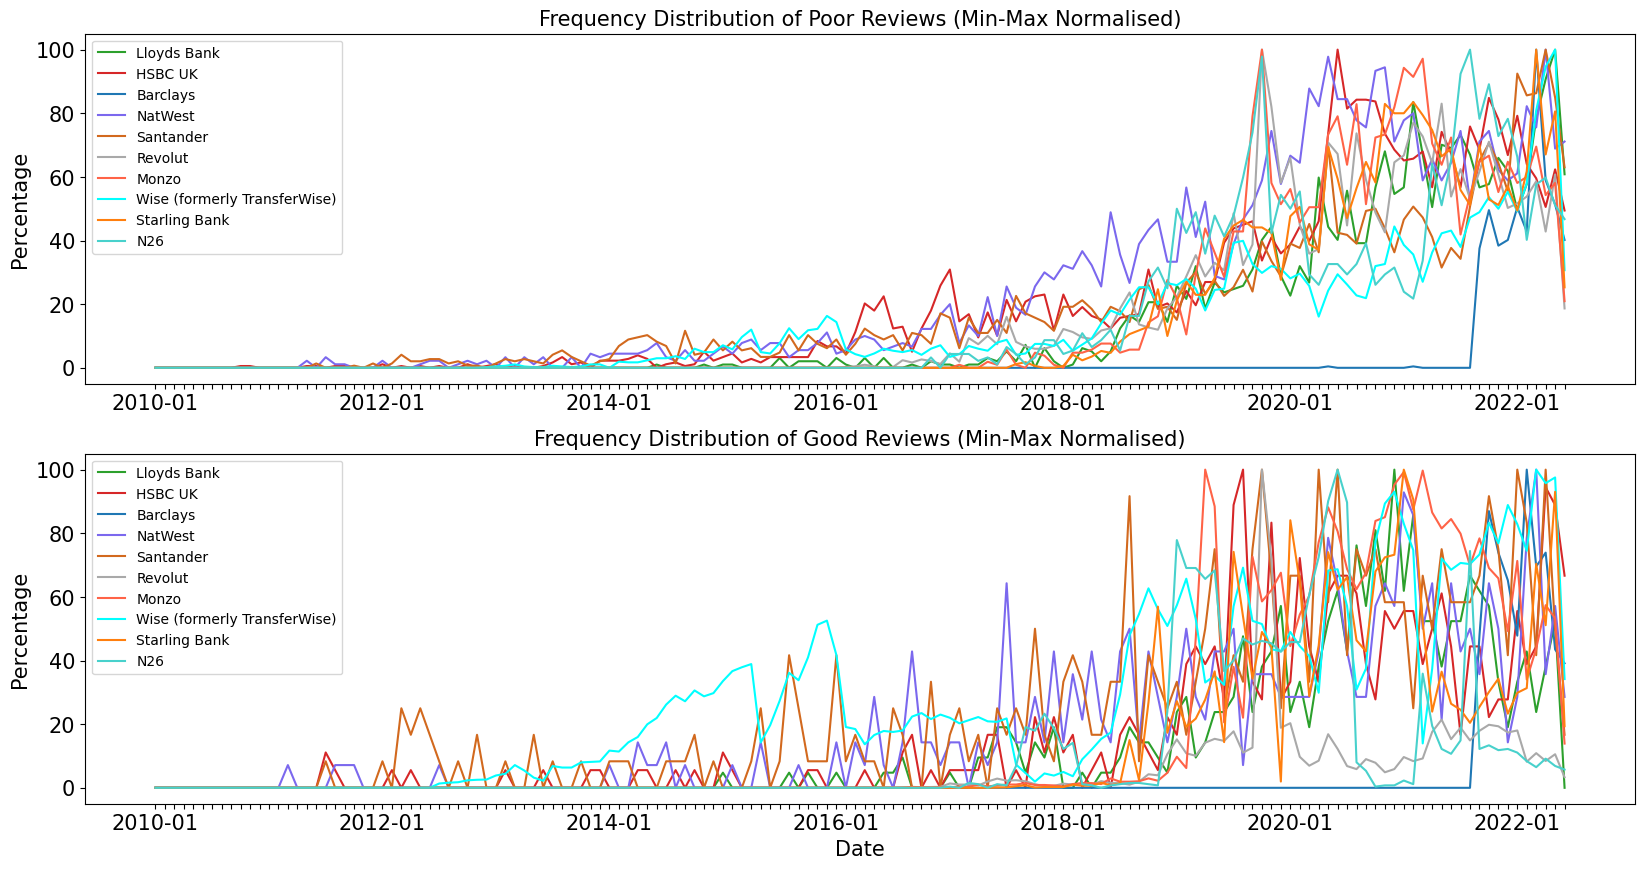

In [ ]:
# plotting distribution of reviews over time
fig, ax = plt.subplots(2, 1, figsize=(20,10))

# Frequency Distribution
ax[0].set_title('Frequency Distribution of Poor Reviews (Min-Max Normalised)', fontsize=15)
for i in range(len(bank_freq_dist_poor)):
    ax[0].plot(dates, bank_freq_dist_poor[i], label=bank_names[i], color=colors_dict[bank_names[i]][0])
ax[0].legend()
ax[0].set_ylabel("Percentage", size=15)
ax[0].tick_params(axis='y', which='major', labelsize=15)
ax[0].tick_params(axis='x', which='major', labelsize=15)

ax[1].set_title('Frequency Distribution of Good Reviews (Min-Max Normalised)', fontsize=15)
for i in range(len(bank_freq_dist_good)):
    ax[1].plot(dates, bank_freq_dist_good[i], label=bank_names[i], color=colors_dict[bank_names[i]][0])
ax[1].legend()
ax[1].set_ylabel("Percentage", size=15)
ax[1].set_xlabel("Date", size=15)
ax[1].tick_params(axis='y', which='major', labelsize=15)
ax[1].tick_params(axis='x', which='major', labelsize=15)

for i in range(2):
    every_nth = 24
    for n, label in enumerate(ax[i].xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)

plt.show()

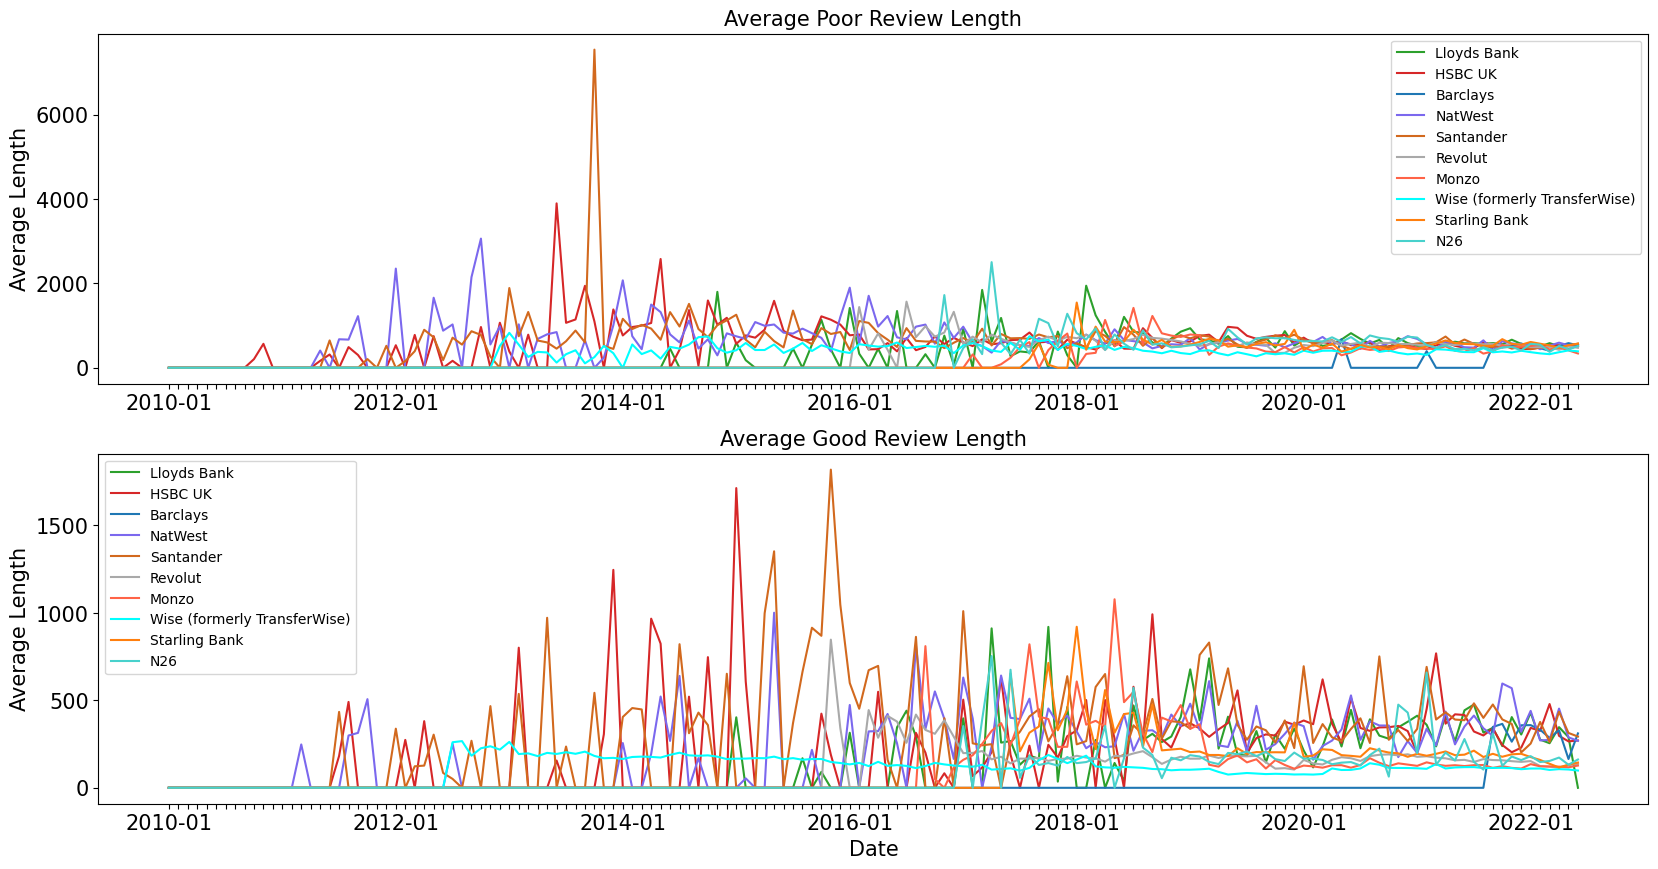

In [ ]:
# plotting review length over time
fig, ax = plt.subplots(2, 1, figsize=(20,10))

# Frequency Distribution
ax[0].set_title('Average Poor Review Length', fontsize=15)
for i in range(len(bank_avg_review_poor)):
    ax[0].plot(dates, bank_avg_review_poor[i], label=bank_names[i], color=colors_dict[bank_names[i]][0])
ax[0].legend()
ax[0].set_ylabel("Average Length", size=15)
ax[0].tick_params(axis='y', which='major', labelsize=15)
ax[0].tick_params(axis='x', which='major', labelsize=15)

ax[1].set_title('Average Good Review Length', fontsize=15)
for i in range(len(bank_avg_review_good)):
    ax[1].plot(dates, bank_avg_review_good[i], label=bank_names[i], color=colors_dict[bank_names[i]][0])
ax[1].legend()
ax[1].set_ylabel("Average Length", size=15)
ax[1].set_xlabel("Date", size=15)
ax[1].tick_params(axis='y', which='major', labelsize=15)
ax[1].tick_params(axis='x', which='major', labelsize=15)

for i in range(2):
#     for j in range(1):
    every_nth = 24
    for n, label in enumerate(ax[i].xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)

plt.show()

# 3) Moving Average

In [ ]:
# defining function to get the moving average of review lengths and ratings over time
def ma_processing(bank_start_index, bank_avg_review_number, bank_avg_review_length, bank_avg_review_rating, n_month_ma):
  """
  Outputs a moving average timeseries of reviews, review lengths 
  and review rating 
  """
    
    bank_avg_review_number_ma = []
    bank_avg_review_length_ma = []
    bank_avg_review_rating_ma = []
    
    for i in range(len(dates)):
        # getting n_month_ma moving average of review length and rating
        if i >= bank_start_index + n_month_ma - 1:
            avg_number_ma = 0
            avg_length_ma = 0
            avg_rating_ma = 0
            for j in range(n_month_ma):
                avg_number_ma += bank_avg_review_number[i - j] # summing up previous n_month_ma number of reviews
                avg_length_ma += bank_avg_review_length[i - j] # summing up previous n_month_ma number of average lengths
                avg_rating_ma += bank_avg_review_rating[i - j] # summing up previous n_month_ma number of average reviews
            bank_avg_review_number_ma.append(avg_number_ma/n_month_ma)
            bank_avg_review_length_ma.append(avg_length_ma/n_month_ma)
            bank_avg_review_rating_ma.append(avg_rating_ma/n_month_ma)
        else:
            bank_avg_review_number_ma.append(0)
            bank_avg_review_length_ma.append(0)
            bank_avg_review_rating_ma.append(0)

    return bank_avg_review_number_ma, bank_avg_review_length_ma, bank_avg_review_rating_ma

# defining lists to store series plots
bank_avg_number_ma = []
bank_avg_review_ma = []
bank_avg_rating_ma = []
bank_avg_number_ma_good = []
bank_avg_review_ma_good = []
bank_avg_rating_ma_good = []
bank_avg_number_ma_poor = []
bank_avg_review_ma_poor = []
bank_avg_rating_ma_poor = []

# defining function to append moving average values onto list:
def append_list_ma(df, bank, n_month_ma, rating='all'):
    
    df = splitting_bank(df, bank, rating)
    start_month_index = dates.index(df.iloc[-1, -1])
    bank_index = bank_names.index(bank)
    
    if rating=="poor":
        bank_avg_review_number_ma, bank_avg_review_length_ma, bank_avg_review_rating_ma = ma_processing(start_month_index, bank_freq_dist_poor[bank_index], bank_avg_review_poor[bank_index], bank_avg_rating_poor[bank_index], n_month_ma)
        bank_avg_number_ma_poor.append(bank_avg_review_number_ma)
        bank_avg_review_ma_poor.append(bank_avg_review_length_ma)
        bank_avg_rating_ma_poor.append(bank_avg_review_rating_ma)
    
    elif rating=="good":
        bank_avg_review_number_ma, bank_avg_review_length_ma, bank_avg_review_rating_ma = ma_processing(start_month_index, bank_freq_dist_good[bank_index], bank_avg_review_good[bank_index], bank_avg_rating_good[bank_index], n_month_ma)
        bank_avg_number_ma_good.append(bank_avg_review_number_ma)
        bank_avg_review_ma_good.append(bank_avg_review_length_ma)
        bank_avg_rating_ma_good.append(bank_avg_review_rating_ma)
    
    else:
        bank_avg_review_number_ma, bank_avg_review_length_ma, bank_avg_review_rating_ma = ma_processing(start_month_index, bank_freq_dist[bank_index], bank_avg_review[bank_index], bank_avg_rating[bank_index], n_month_ma)
        bank_avg_number_ma.append(bank_avg_review_number_ma)
        bank_avg_review_ma.append(bank_avg_review_length_ma)
        bank_avg_rating_ma.append(bank_avg_review_rating_ma)

# getting ma plot for each bank
for bank in bank_names:
    append_list_ma(df, bank, 3)
    append_list_ma(df, bank, 3, "good")
    append_list_ma(df, bank, 3, "poor")

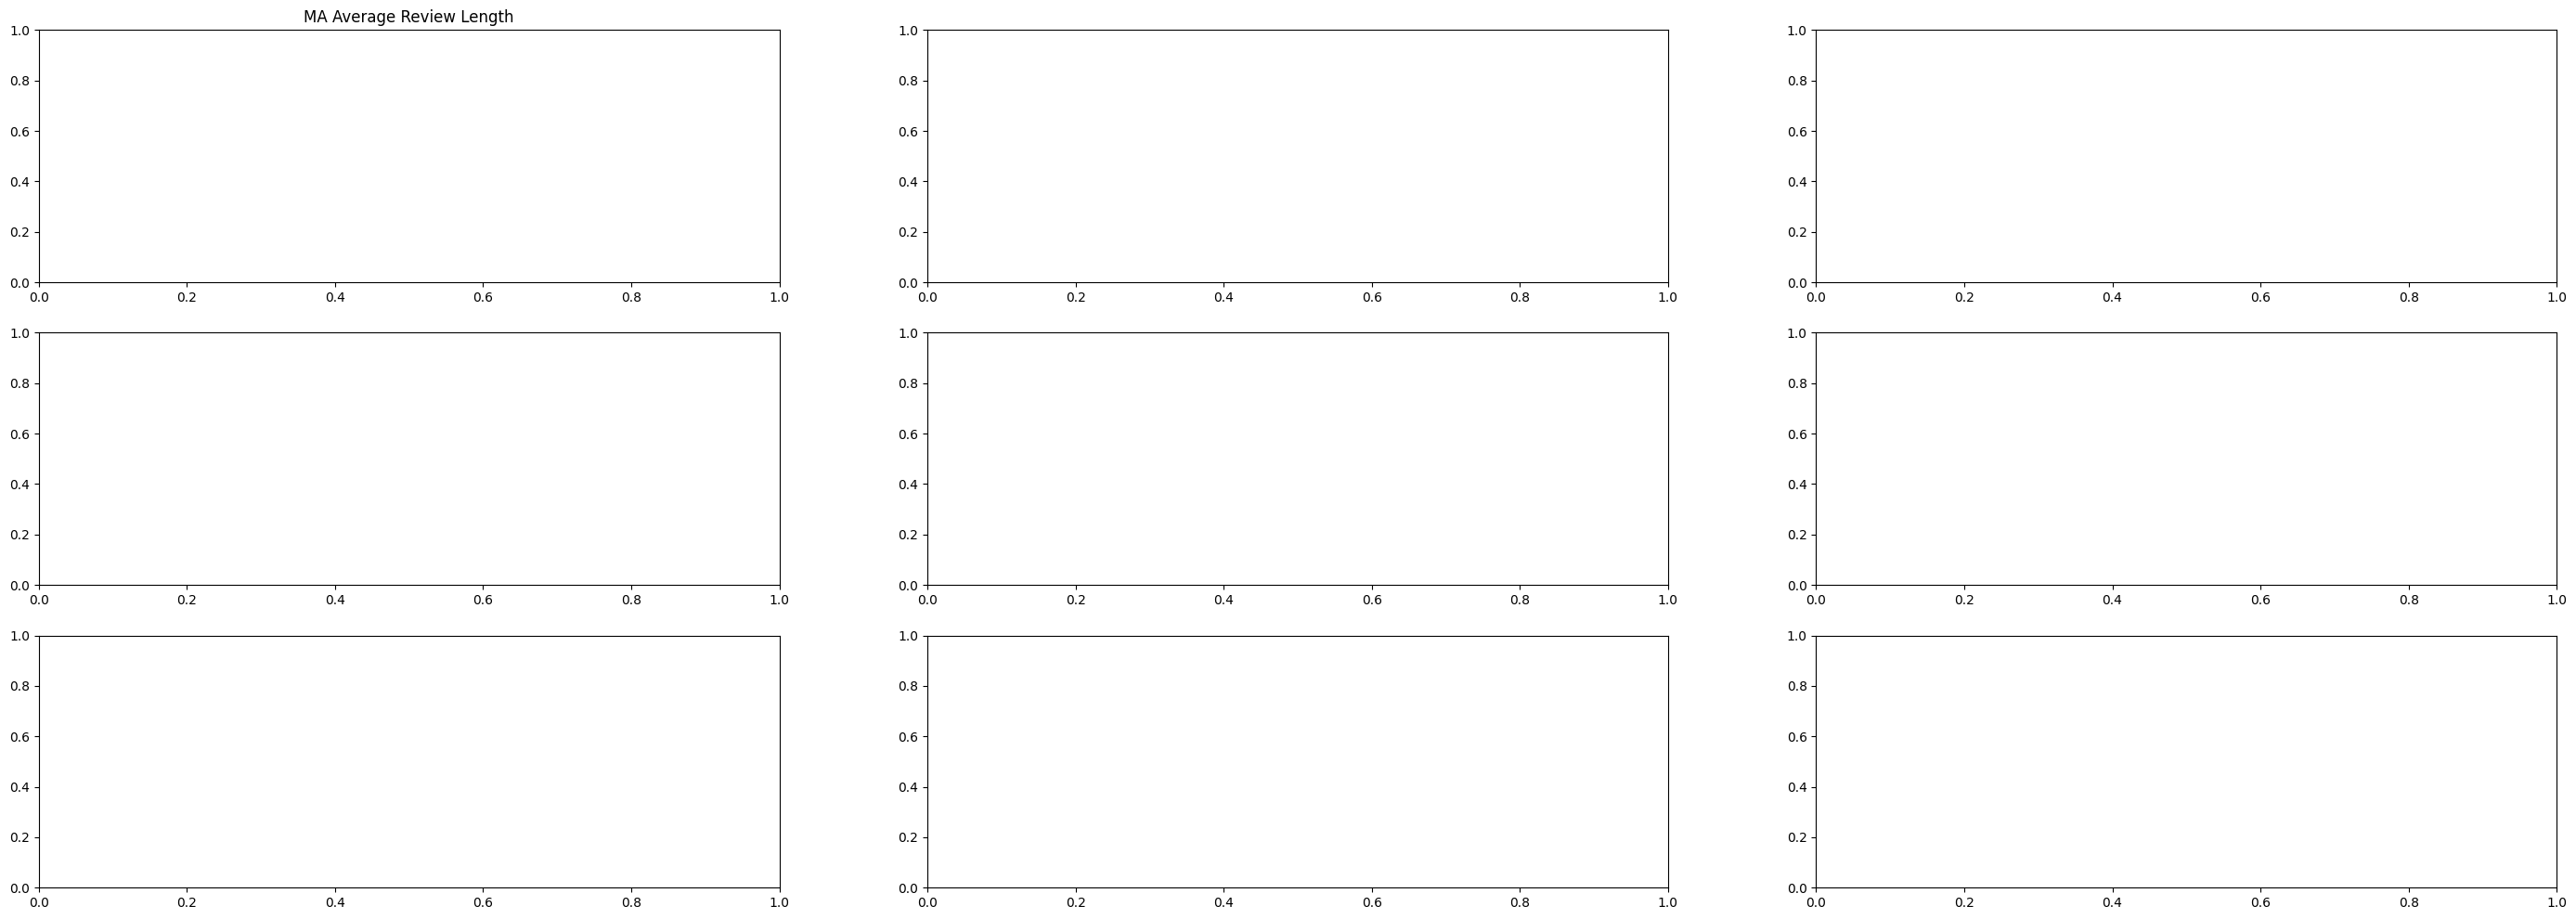

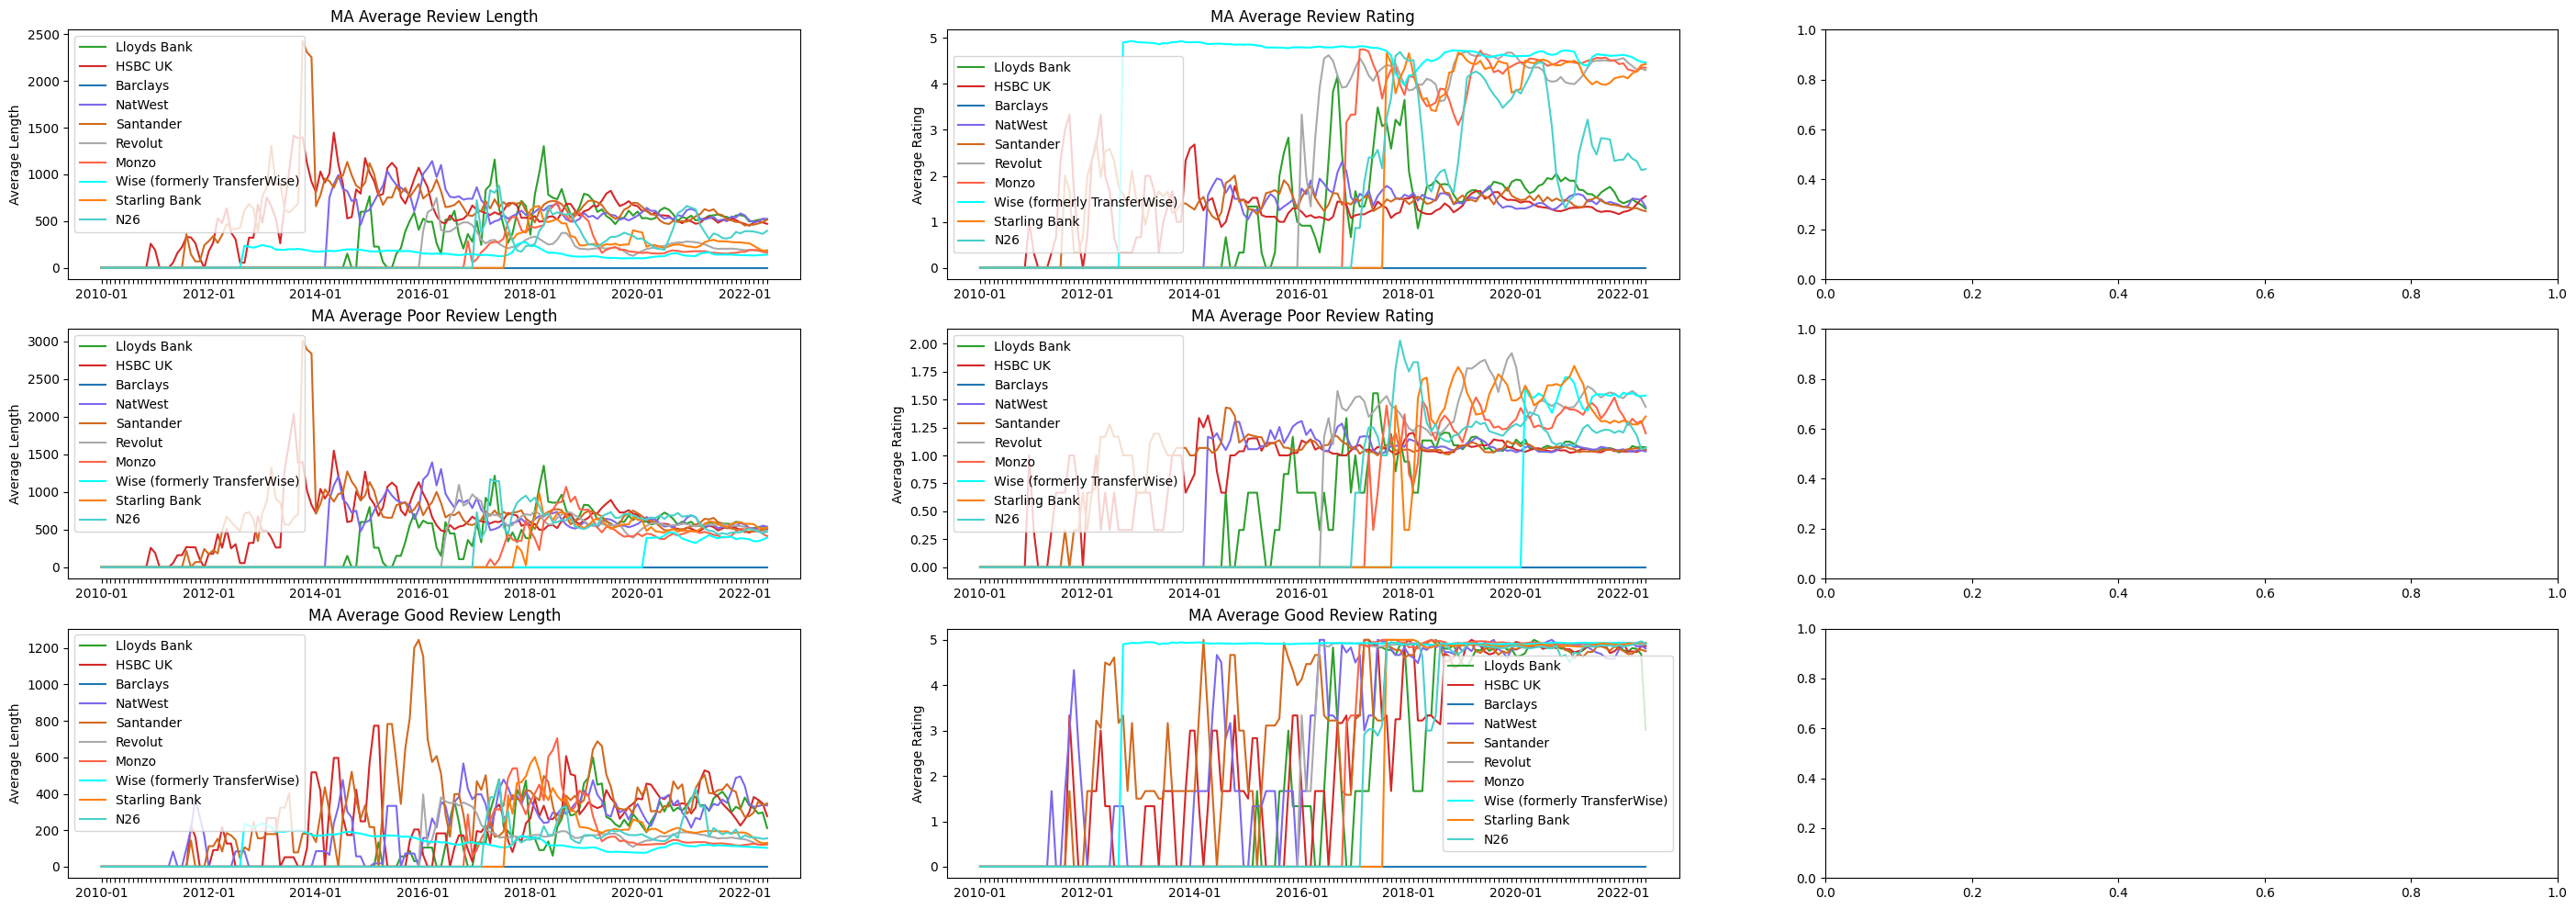

In [ ]:
# plotting
fig, ax = plt.subplots(3, 1, figsize=(20,15))

# Frequency Distribution
ax[0].title.set_text('MA Average Review Length')
for i in range(len(bank_freq_dist)):
    ax[0].plot(dates, bank_freq_dist[i], label=bank_names[i], color=colors_dict[bank_names[i]][0])
ax[0].legend()
ax[0].set_ylabel("Normalised Frequency")

ax[1].title.set_text('Frequency Distribution of Poor Reviews (Min-Max Normalised)')
for i in range(len(bank_freq_dist_poor)):
    ax[1].plot(dates, bank_freq_dist_poor[i], label=bank_names[i], color=colors_dict[bank_names[i]][0])
ax[1].legend()
ax[1].set_ylabel("Normalised Frequency")

ax[2].title.set_text('Frequency Distribution of Good Reviews (Min-Max Normalised)')
for i in range(len(bank_freq_dist_good)):
    ax[2].plot(dates, bank_freq_dist_good[i], label=bank_names[i], color=colors_dict[bank_names[i]][0])
ax[2].legend()
ax[2].set_ylabel("Normalised Frequency")
ax[2].set_xlabel("Date")

for i in range(3):
#     for j in range(1):
    every_nth = 24
    for n, label in enumerate(ax[i].xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)

plt.show()

# Distribution of Replies

In [ ]:
def reply_processing(df):
  """
  Outputs the marginal and cumulative reply rates over different ratings
  """
    
    # 1 star
    bank_1_star_df, perc_bank_company_reply_1_star_rel, perc_bank_1_star, perc_company_reply_bank_1_star = star_processing(df, 1)
    num_replies_date_1_star, cum_num_replies_date_1_star = replies_date_processing(bank_1_star_df)

    # 2 star
    bank_2_star_df, perc_bank_company_reply_2_star_rel, perc_bank_2_star, perc_company_reply_bank_2_star = star_processing(df, 2)
    num_replies_date_2_star, cum_num_replies_date_2_star = replies_date_processing(bank_2_star_df)

    # 3 star
    bank_3_star_df, perc_bank_company_reply_3_star_rel, perc_bank_3_star, perc_company_reply_bank_3_star = star_processing(df, 3)
    num_replies_date_3_star, cum_num_replies_date_3_star = replies_date_processing(bank_3_star_df)

    # 4 star
    bank_4_star_df, perc_bank_company_reply_4_star_rel, perc_bank_4_star, perc_company_reply_bank_4_star = star_processing(df, 4)
    num_replies_date_4_star, cum_num_replies_date_4_star = replies_date_processing(bank_4_star_df)

    # 5 star
    bank_5_star_df, perc_bank_company_reply_5_star_rel, perc_bank_5_star, perc_company_reply_bank_5_star = star_processing(df, 5)
    num_replies_date_5_star, cum_num_replies_date_5_star = replies_date_processing(bank_5_star_df)

    y_label_perc_reply_bank = [perc_bank_company_reply_1_star_rel, perc_bank_company_reply_2_star_rel, 
                               perc_bank_company_reply_3_star_rel, perc_bank_company_reply_4_star_rel, 
                               perc_bank_company_reply_5_star_rel]
    
    return y_label_perc_reply_bank, num_replies_date_1_star, num_replies_date_2_star, num_replies_date_3_star, num_replies_date_4_star, num_replies_date_5_star, cum_num_replies_date_1_star, cum_num_replies_date_2_star, cum_num_replies_date_3_star, cum_num_replies_date_4_star, cum_num_replies_date_5_star

def star_processing(df, star):
  """
  Outputs relative reply rates by rating
  """

    total_reviews = len(df)
    
    bank_star = df.loc[df.loc[:, "rating"] == f"Rated {star} out of 5 stars", :]
    bank_star.reset_index(inplace=True, drop=True)
    num_bank_star = len(bank_star)
    num_company_reply_bank_star = bank_star.count(axis=0)["company_reply"]

    # % of 1 star reviews replied
    perc_bank_company_reply_star_rel = num_company_reply_bank_star/num_bank_star * 100

    # normalised number of reviews
    perc_bank_star = num_bank_star/total_reviews * 100

    # normalised number of replies
    perc_company_reply_bank_star = num_company_reply_bank_star/total_reviews * 100
    
    return bank_star, perc_bank_company_reply_star_rel, perc_bank_star, perc_company_reply_bank_star

def replies_date_processing(df):
  """
  Outputs a timeseries of normalised marginal and cumulative reply rates
  """
    num_replies_date = []
    cum_num_replies_date = []
    total_replies = 0

    for date in dates:
        bank_date_df = df.loc[df.loc[:, "yy_mm"] == date, :]
        num_bank_reply_date = bank_date_df.count(axis=0)["company_reply"]
        total_replies += num_bank_reply_date
        num_replies_date.append(num_bank_reply_date)
        cum_num_replies_date.append(total_replies)

    bank_replies_dist_norm = [(freq - min(num_replies_date))/(max(num_replies_date) - min(num_replies_date)) * 100 for freq in num_replies_date]
    cum_bank_replies_dist_norm = cum_num_replies_date/total_replies * 100
    return bank_replies_dist_norm, cum_bank_replies_dist_norm

# initialising lists to store marginal and cumulative plots
marginal_1_star = []
marginal_2_star = []
marginal_3_star = []
marginal_4_star = []
marginal_5_star = []
cum_1_star = []
cum_2_star = []
cum_3_star = []
cum_4_star = []
cum_5_star = []
perc_reply = []

# defining function to append moving average values onto list:
def append_list_replies_dist(df, bank, rating='all'):
  """
  Appends distributions to their respective lists
  """
    
    df = splitting_bank(df, bank, rating)
    y_label_perc_reply_bank, num_replies_date_1_star, num_replies_date_2_star, num_replies_date_3_star, num_replies_date_4_star, num_replies_date_5_star, cum_num_replies_date_1_star, cum_num_replies_date_2_star, cum_num_replies_date_3_star, cum_num_replies_date_4_star, cum_num_replies_date_5_star = reply_processing(df)
    
    # percentage replied
    perc_reply.append(y_label_perc_reply_bank)
    
    # marginal plot
    marginal_1_star.append(num_replies_date_1_star)
    marginal_2_star.append(num_replies_date_2_star)
    marginal_3_star.append(num_replies_date_3_star)
    marginal_4_star.append(num_replies_date_4_star)
    marginal_5_star.append(num_replies_date_5_star)
    
    # cumulative plot
    cum_1_star.append(cum_num_replies_date_1_star)
    cum_2_star.append(cum_num_replies_date_2_star)
    cum_3_star.append(cum_num_replies_date_3_star)
    cum_4_star.append(cum_num_replies_date_4_star)
    cum_5_star.append(cum_num_replies_date_5_star)

# iterating over each bank
for bank in bank_names:
    append_list_replies_dist(df, bank)

<ipython-input-28-022257fbf093>:64: RuntimeWarning: invalid value encountered in long_scalars
  bank_replies_dist_norm = [(freq - min(num_replies_date))/(max(num_replies_date) - min(num_replies_date)) * 100 for freq in num_replies_date]
<ipython-input-28-022257fbf093>:65: RuntimeWarning: invalid value encountered in true_divide
  cum_bank_replies_dist_norm = cum_num_replies_date/total_replies * 100


In [ ]:
def reply_processing(df):
  """
  Outputs the marginal and cumulative number of replies by good and poor reviews
  """

    # poor
    bank_poor_star_df, perc_bank_company_reply_poor_star_rel, perc_bank_poor_star, perc_company_reply_bank_poor_star = star_processing(df, "poor")
    num_replies_date_poor_star, cum_num_replies_date_poor_star = replies_date_processing(bank_poor_star_df)
    
    # good
    bank_good_star_df, perc_bank_company_reply_good_star_rel, perc_bank_good_star, perc_company_reply_bank_good_star = star_processing(df, "good")
    num_replies_date_good_star, cum_num_replies_date_good_star = replies_date_processing(bank_good_star_df)
    
    y_label_perc_reply_bank = [perc_bank_company_reply_poor_star_rel, perc_bank_company_reply_good_star_rel]
    
    return y_label_perc_reply_bank, num_replies_date_poor_star, num_replies_date_good_star, cum_num_replies_date_poor_star, cum_num_replies_date_good_star 


def star_processing(df, star):
  """
  Outputs relative reply rates by rating
  """

    total_reviews = len(df)
    
    if star == "good":
        bank_star = df.loc[(df.loc[:, "rating"] == f"Rated 4 out of 5 stars")|(df.loc[:, "rating"] == f"Rated 5 out of 5 stars"), :]
    else:
        bank_star = df.loc[(df.loc[:, "rating"] == f"Rated 1 out of 5 stars")|(df.loc[:, "rating"] == f"Rated 2 out of 5 stars")|(df.loc[:, "rating"] == f"Rated 3 out of 5 stars"), :]
    
    bank_star.reset_index(inplace=True, drop=True)
    num_bank_star = len(bank_star)
    num_company_reply_bank_star = bank_star.count(axis=0)["company_reply"]

    # % of 1 star reviews replied
    perc_bank_company_reply_star_rel = num_company_reply_bank_star/num_bank_star * 100

    # normalised number of reviews
    perc_bank_star = num_bank_star/total_reviews * 100

    # normalised number of replies
    perc_company_reply_bank_star = num_company_reply_bank_star/total_reviews * 100
    
    return bank_star, perc_bank_company_reply_star_rel, perc_bank_star, perc_company_reply_bank_star

def replies_date_processing(df):
  """
  Outputs a timeseries of normalised marginal and cumulative reply rates
  """
    num_replies_date = []
    cum_num_replies_date = []
    total_replies = 0

    for date in dates:
        bank_date_df = df.loc[df.loc[:, "yy_mm"] == date, :]
        num_bank_reply_date = bank_date_df.count(axis=0)["company_reply"]
        total_replies += num_bank_reply_date
        num_replies_date.append(num_bank_reply_date)
        cum_num_replies_date.append(total_replies)

    bank_replies_dist_norm = [(freq - min(num_replies_date))/(max(num_replies_date) - min(num_replies_date)) * 100 for freq in num_replies_date]
    cum_bank_replies_dist_norm = cum_num_replies_date/total_replies * 100
    return bank_replies_dist_norm, cum_bank_replies_dist_norm

# initialising lists to store marginal and cumulative plots
marginal_poor = []
marginal_good = []
cum_poor = []
cum_good = []
perc_reply_poor_good = []

# defining function to append moving average values onto list:
def append_list_replies_dist(df, bank, rating='all'):
    
    df = splitting_bank(df, bank, rating)
    y_label_perc_reply_bank, num_replies_date_poor_star, num_replies_date_good_star, cum_num_replies_date_poor_star, cum_num_replies_date_good_star  = reply_processing(df)
    
    # percentage replied
    perc_reply_poor_good.append(y_label_perc_reply_bank)
    
    # marginal plot
    marginal_poor.append(num_replies_date_poor_star)
    marginal_good.append(num_replies_date_good_star)
    
    # cumulative plot
    cum_poor.append(cum_num_replies_date_poor_star)
    cum_good.append(cum_num_replies_date_good_star)

# iterating over each bank
for bank in bank_names:
    append_list_replies_dist(df, bank)

<ipython-input-29-ab8194f4702c>:49: RuntimeWarning: invalid value encountered in long_scalars
  bank_replies_dist_norm = [(freq - min(num_replies_date))/(max(num_replies_date) - min(num_replies_date)) * 100 for freq in num_replies_date]
<ipython-input-29-ab8194f4702c>:50: RuntimeWarning: invalid value encountered in true_divide
  cum_bank_replies_dist_norm = cum_num_replies_date/total_replies * 100


# 1) Distribution of Company Replies

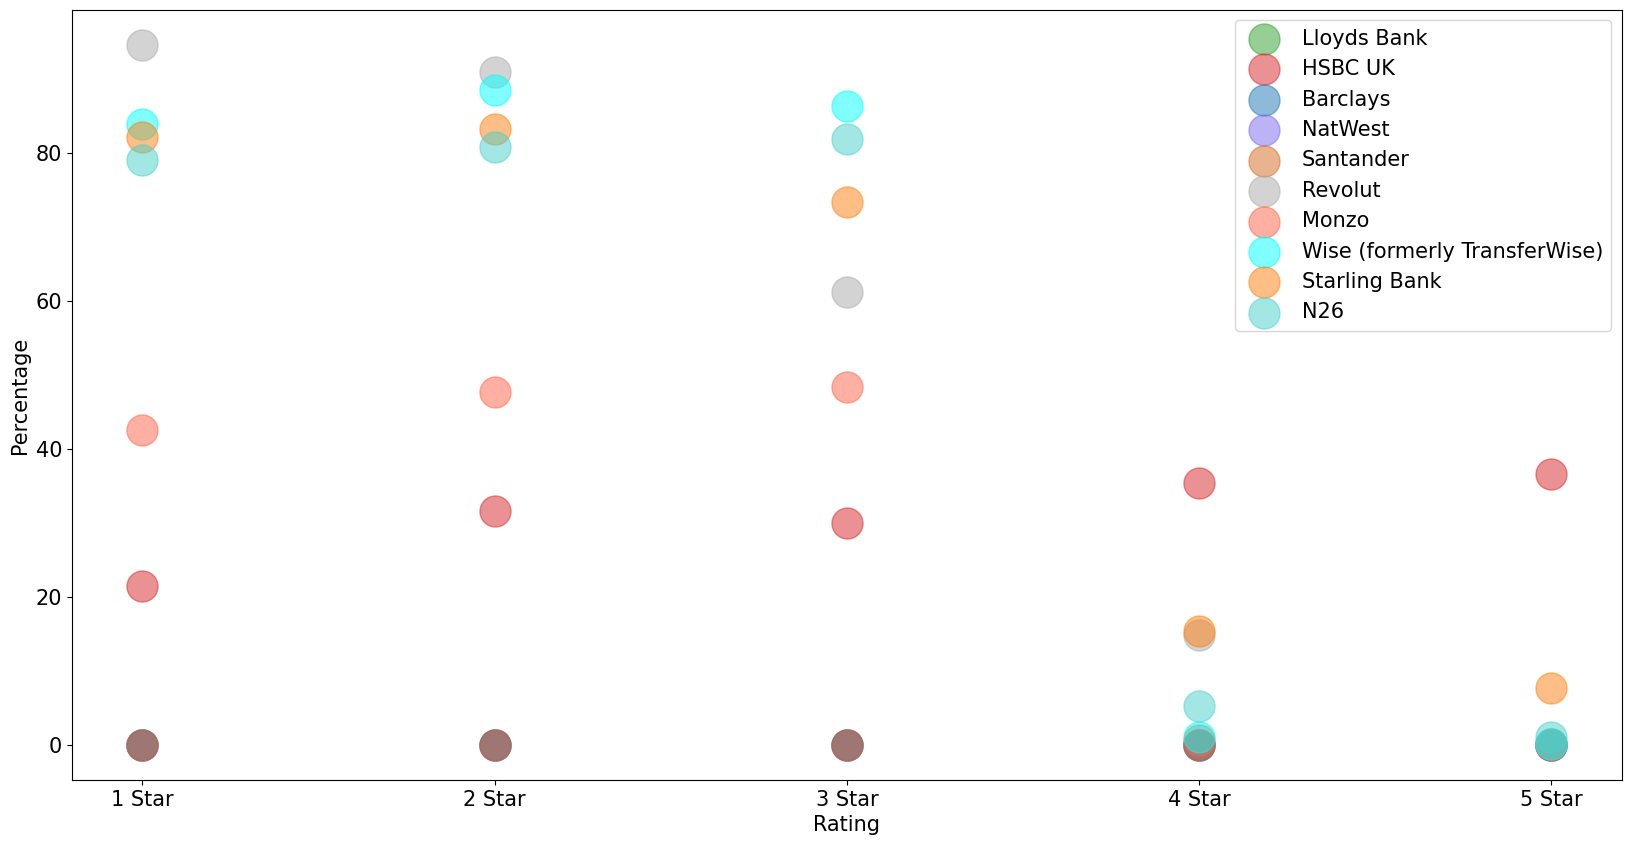

In [ ]:
# plotting distribution of company replies by rating

X_label = ['1 Star', '2 Star', '3 Star', '4 Star', '5 Star']
X = np.arange(5)

plt.figure(figsize=(20, 10))
for i in range(len(bank_names)):
    plt.scatter(X, perc_reply[i], label=bank_names[i], color=colors_dict[bank_names[i]][0], alpha=0.5, s=500)
plt.xticks(X, labels=X_label)
plt.xlabel("Rating", size=15)
plt.ylabel("Percentage", size=15)
plt.tick_params(axis='x', which='major', labelsize=15)
plt.tick_params(axis='y', which='major', labelsize=15)
plt.legend(prop={"size":15})
# plt.title("Distribution of Company Replies Relative to Number of Reviews of Each Rating", fontsize=15)

plt.show()

# 2) Marginal Distribution Over Time

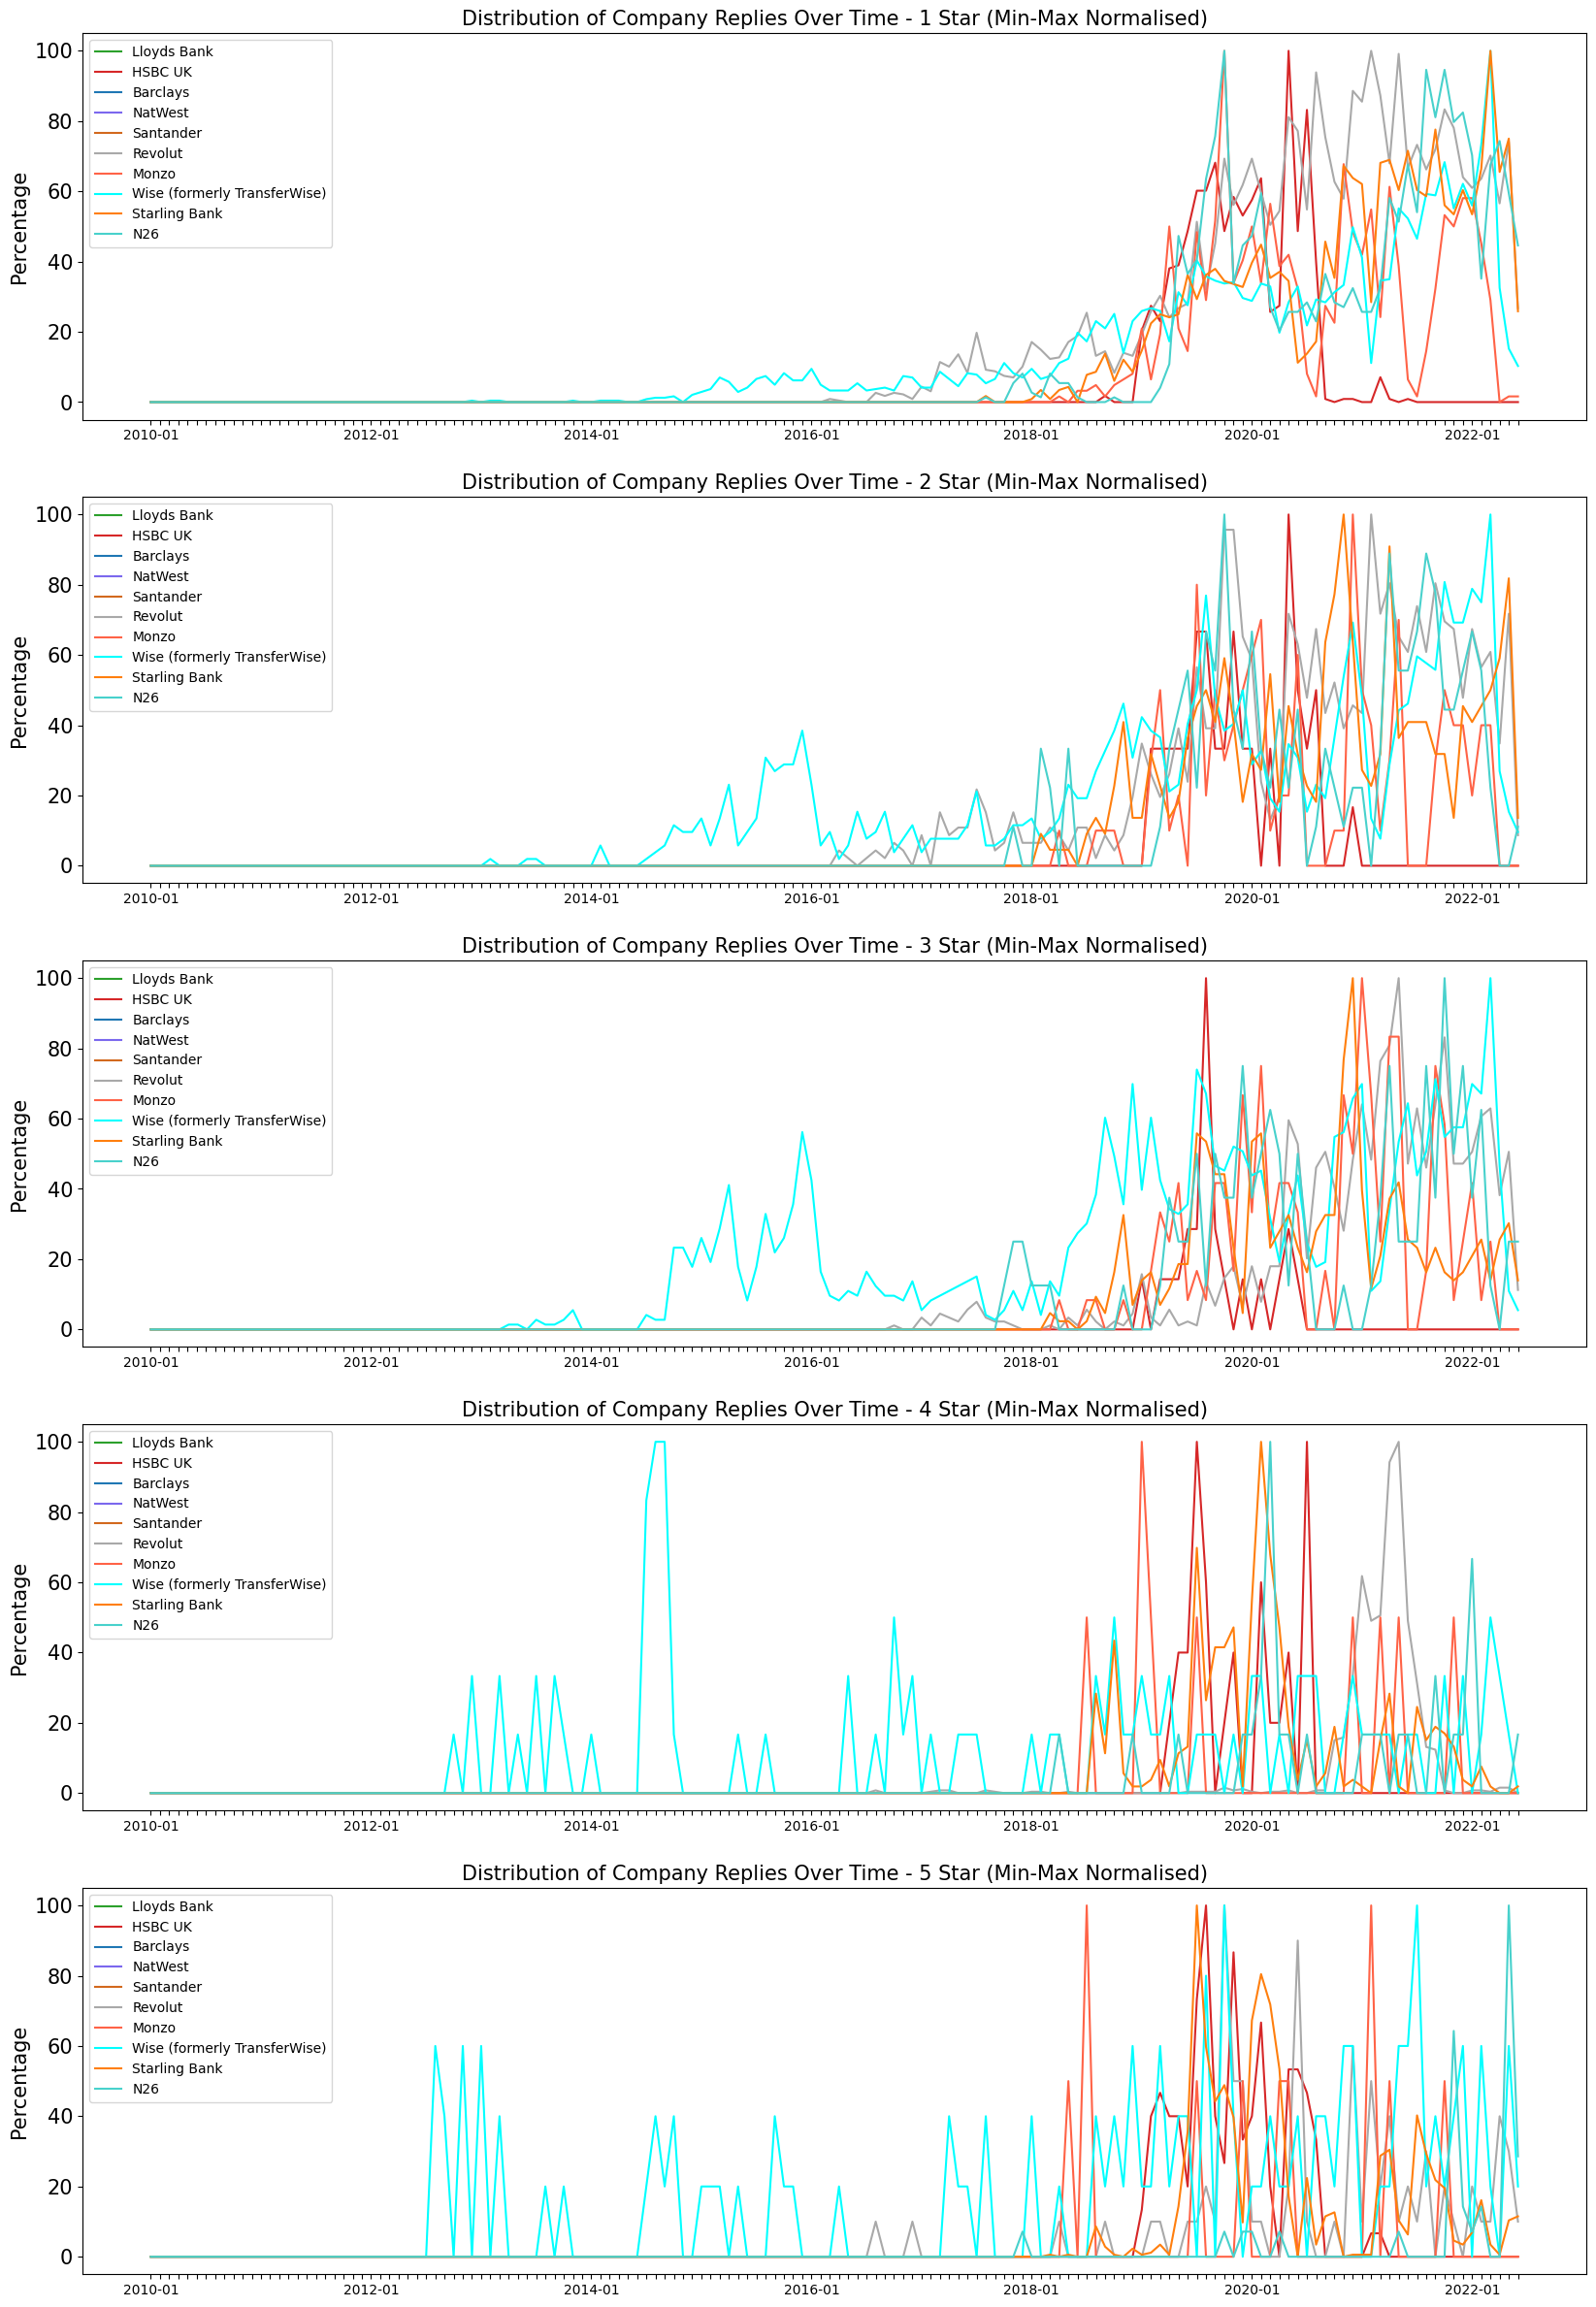

In [ ]:
# plotting time series of company replies by rating

fig, ax = plt.subplots(5, 1, figsize=(20, 30))

for i in range(len(bank_names)):
    ax[0].plot(dates, marginal_1_star[i], label=bank_names[i], color=colors_dict[bank_names[i]][0])
ax[0].set_ylabel("Percentage", size=15)
ax[0].tick_params(axis='y', which='major', labelsize=15)
ax[0].legend()
ax[0].set_title("Distribution of Company Replies Over Time - 1 Star (Min-Max Normalised)", fontsize=15)

for i in range(len(bank_names)):
    ax[1].plot(dates, marginal_2_star[i], label=bank_names[i], color=colors_dict[bank_names[i]][0])
ax[1].set_ylabel("Percentage", size=15)
ax[1].tick_params(axis='y', which='major', labelsize=15)
ax[1].legend()
ax[1].set_title("Distribution of Company Replies Over Time - 2 Star (Min-Max Normalised)", fontsize=15)

for i in range(len(bank_names)):
    ax[2].plot(dates, marginal_3_star[i], label=bank_names[i], color=colors_dict[bank_names[i]][0])
ax[2].set_ylabel("Percentage", size=15)
ax[2].tick_params(axis='y', which='major', labelsize=15)
ax[2].legend()
ax[2].set_title("Distribution of Company Replies Over Time - 3 Star (Min-Max Normalised)", fontsize=15)

for i in range(len(bank_names)):
    ax[3].plot(dates, marginal_4_star[i], label=bank_names[i], color=colors_dict[bank_names[i]][0])
ax[3].set_ylabel("Percentage", size=15)
ax[3].tick_params(axis='y', which='major', labelsize=15)
ax[3].legend()
ax[3].set_title("Distribution of Company Replies Over Time - 4 Star (Min-Max Normalised)", fontsize=15)

for i in range(len(bank_names)):
    ax[4].plot(dates, marginal_5_star[i], label=bank_names[i], color=colors_dict[bank_names[i]][0])
ax[4].set_ylabel("Percentage", size=15)
ax[4].tick_params(axis='y', which='major', labelsize=15)
ax[4].legend()
ax[4].set_title("Distribution of Company Replies Over Time - 5 Star (Min-Max Normalised)", fontsize=15)

for i in range(5):
    every_nth = 24
    for n, label in enumerate(ax[i].xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)

plt.show()

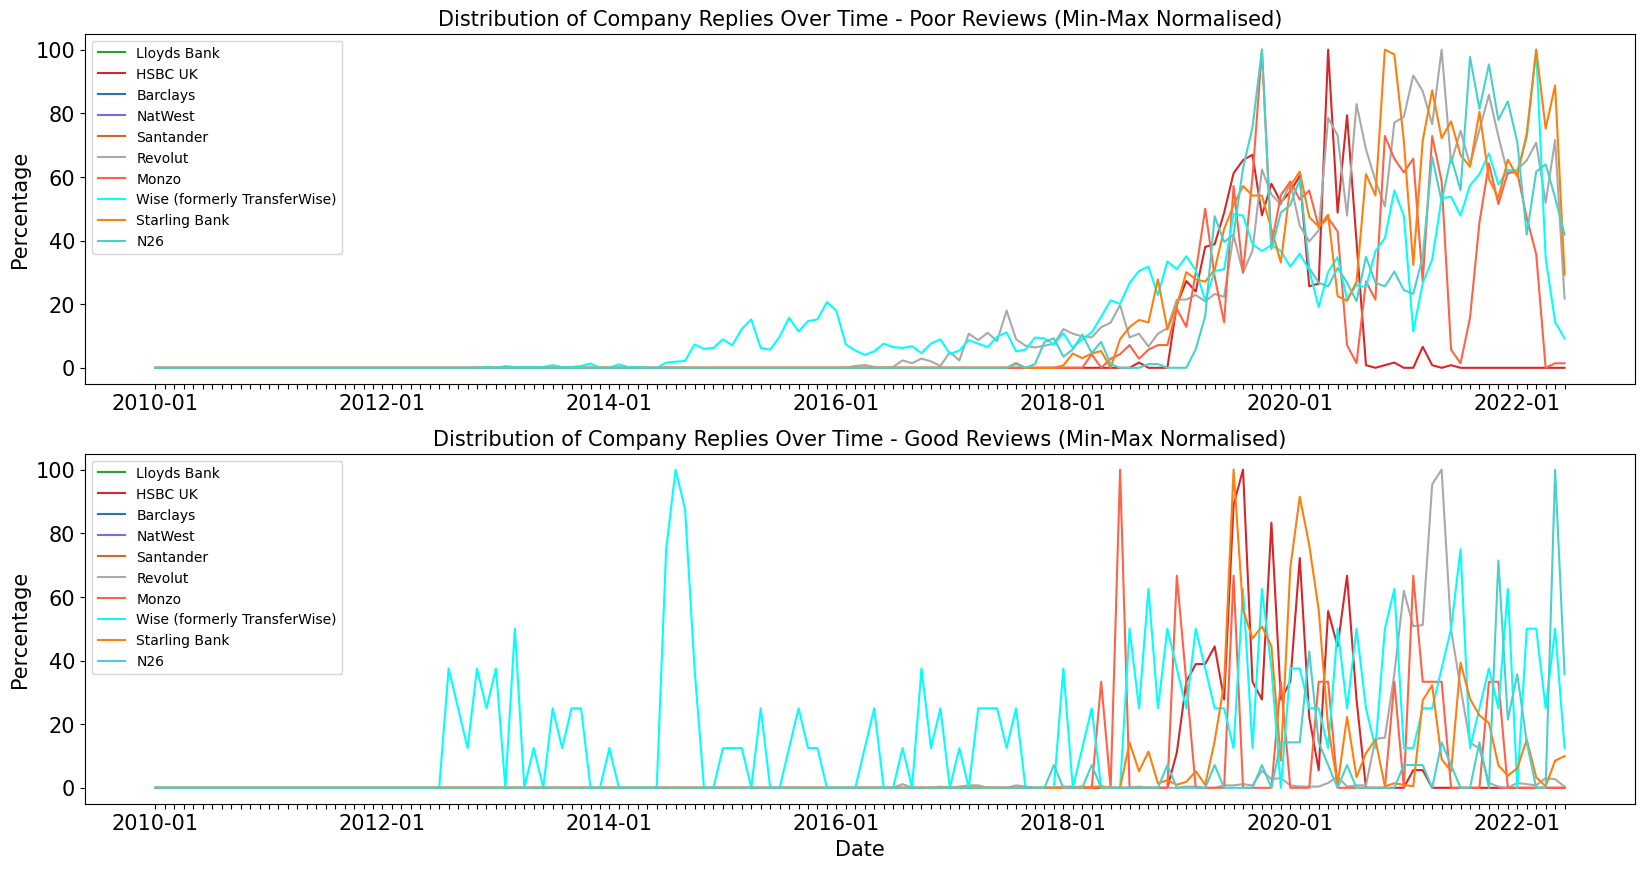

In [ ]:
# plotting time series of company replies by good and poor reviews

fig, ax = plt.subplots(2, 1, figsize=(20, 10))

for i in range(len(bank_names)):
    ax[0].plot(dates, marginal_poor[i], label=bank_names[i], color=colors_dict[bank_names[i]][0])
ax[0].set_ylabel("Percentage", size=15)
ax[0].tick_params(axis='y', which='major', labelsize=15)
ax[0].tick_params(axis='x', which='major', labelsize=15)
ax[0].legend()
ax[0].set_title("Distribution of Company Replies Over Time - Poor Reviews (Min-Max Normalised)", fontsize=15)

for i in range(len(bank_names)):
    ax[1].plot(dates, marginal_good[i], label=bank_names[i], color=colors_dict[bank_names[i]][0])
ax[1].set_ylabel("Percentage", size=15)
ax[1].set_xlabel("Date", size=15)
ax[1].tick_params(axis='y', which='major', labelsize=15)
ax[1].tick_params(axis='x', which='major', labelsize=15)
ax[1].legend()
ax[1].set_title("Distribution of Company Replies Over Time - Good Reviews (Min-Max Normalised)", fontsize=15)

for i in range(2):
    every_nth = 24
    for n, label in enumerate(ax[i].xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)

plt.show()

# 3) Cumulative Distribution Over Time

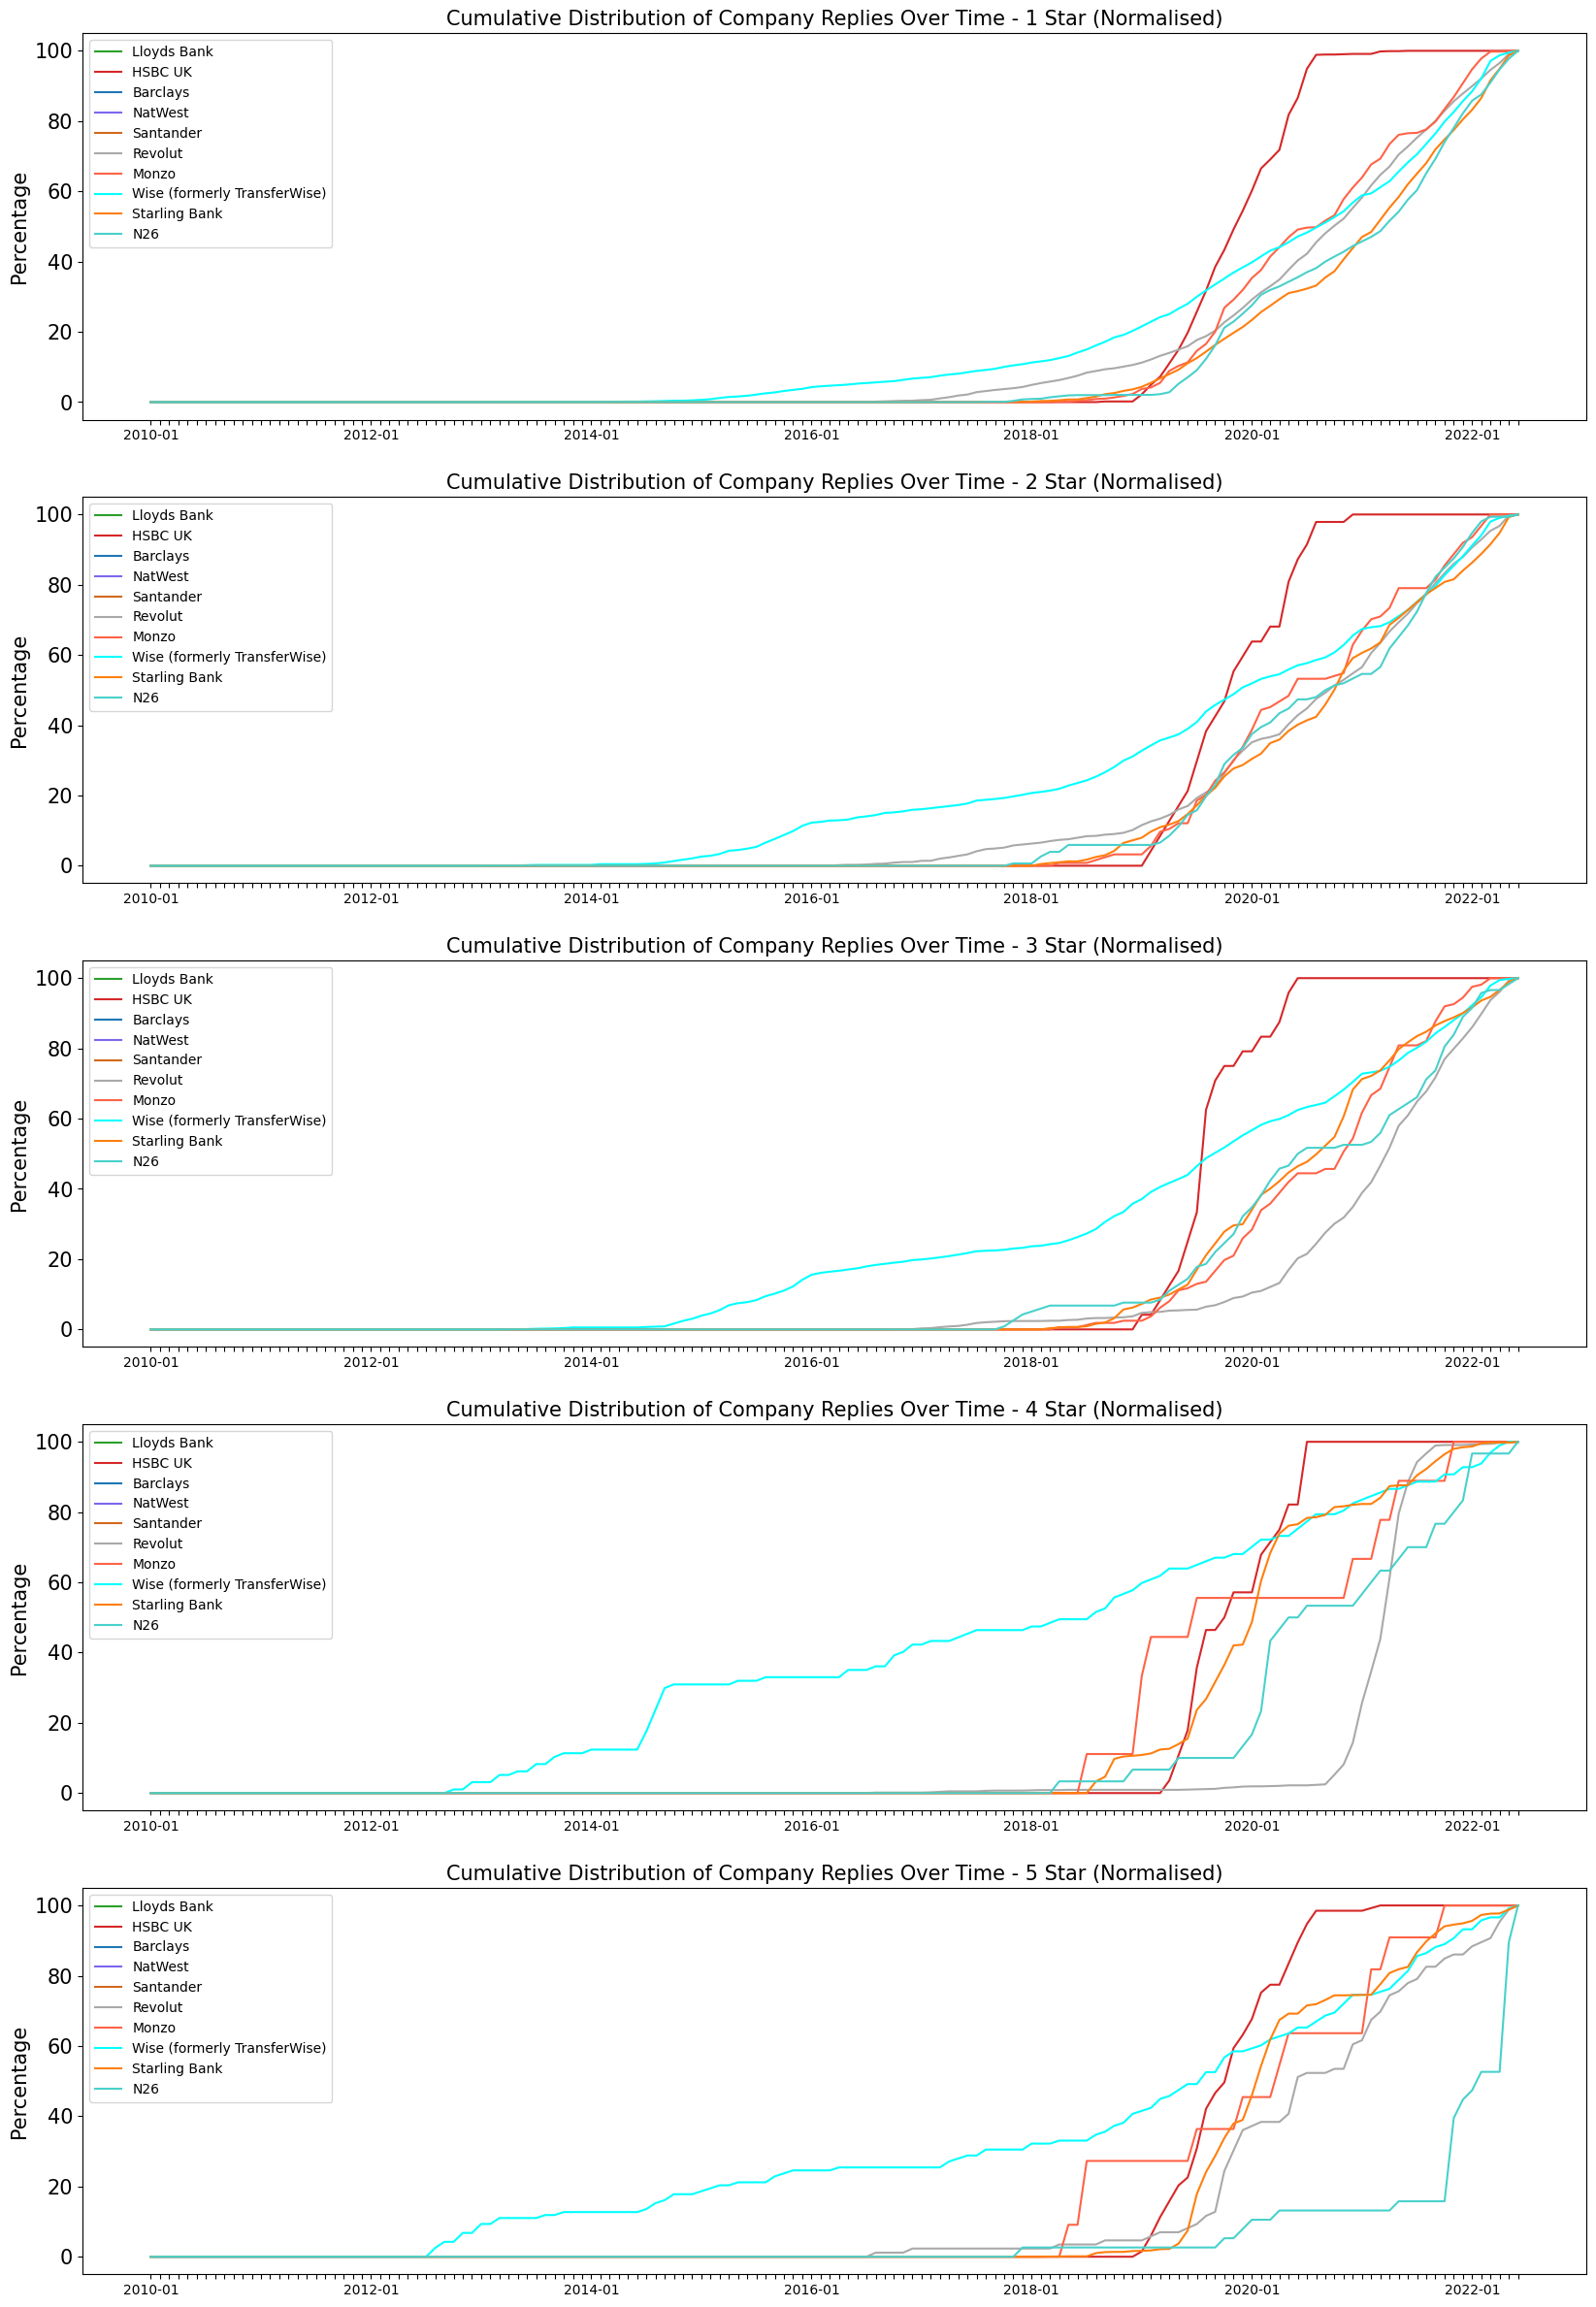

In [ ]:
# plots cumulative distribution of company replies over time by rating

fig, ax = plt.subplots(5, 1, figsize=(20, 30))

for i in range(len(bank_names)):
    ax[0].plot(dates, cum_1_star[i], label=bank_names[i], color=colors_dict[bank_names[i]][0])
ax[0].set_ylabel("Percentage", size=15)
ax[0].tick_params(axis='y', which='major', labelsize=15)
ax[0].legend()
ax[0].set_title("Cumulative Distribution of Company Replies Over Time - 1 Star (Normalised)", fontsize=15)

for i in range(len(bank_names)):
    ax[1].plot(dates, cum_2_star[i], label=bank_names[i], color=colors_dict[bank_names[i]][0])
ax[1].set_ylabel("Percentage", size=15)
ax[1].tick_params(axis='y', which='major', labelsize=15)
ax[1].legend()
ax[1].set_title("Cumulative Distribution of Company Replies Over Time - 2 Star (Normalised)", fontsize=15)

for i in range(len(bank_names)):
    ax[2].plot(dates, cum_3_star[i], label=bank_names[i], color=colors_dict[bank_names[i]][0])
ax[2].set_ylabel("Percentage", size=15)
ax[2].tick_params(axis='y', which='major', labelsize=15)
ax[2].legend()
ax[2].set_title("Cumulative Distribution of Company Replies Over Time - 3 Star (Normalised)", fontsize=15)

for i in range(len(bank_names)):
    ax[3].plot(dates, cum_4_star[i], label=bank_names[i], color=colors_dict[bank_names[i]][0])
ax[3].set_ylabel("Percentage", size=15)
ax[3].tick_params(axis='y', which='major', labelsize=15)
ax[3].legend()
ax[3].set_title("Cumulative Distribution of Company Replies Over Time - 4 Star (Normalised)", fontsize=15)

for i in range(len(bank_names)):
    ax[4].plot(dates, cum_5_star[i], label=bank_names[i], color=colors_dict[bank_names[i]][0])
ax[4].set_ylabel("Percentage", size=15)
ax[4].tick_params(axis='y', which='major', labelsize=15)
ax[4].legend()
ax[4].set_title("Cumulative Distribution of Company Replies Over Time - 5 Star (Normalised)", fontsize=15)

for i in range(5):
    every_nth = 24
    for n, label in enumerate(ax[i].xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)

plt.show()

# Distribution of Words

In [ ]:
def splitting_bank(df, bank, rating="all"):
  """
  Takes the dataset as inputs and ouputs a dataset split by the declared bank and rating
  """
    if bank != "all":
        df = df.loc[df.loc[:, "company"] == bank, :]
    if rating == "poor":
        df = df.loc[(df['rating'] == 'Rated 1 out of 5 stars') | (df['rating'] == 'Rated 2 out of 5 stars') | (df['rating'] == 'Rated 3 out of 5 stars')]
    elif rating == "good":
        df = df.loc[(df['rating'] == 'Rated 4 out of 5 stars') | (df['rating'] == 'Rated 5 out of 5 stars')]
    return df

In [ ]:
def dist_words_with_bank(df, pre_processing, bank, rating, top_words, labelsize):
  """
  Generates the unigram and bigram distribution of common occuring words, 
  before or after pre-processing, and plots both distributions over a barchart 
  hollistically or by bank
  """
    df = splitting_bank(df, bank, rating)
    
    # asessing most common unigrams and bigrams
    if pre_processing == "before":
        sent_list = df["text"].values
    else:
        sent_list = df["cleaned_text"].values
        
    bigrams_list = []
    unigrams_list = []

    for sent in sent_list:
        if pd.notnull(sent):
            sent = sent.lower()
            sent = sent.replace(".", "")
            sent = sent.replace(",", "")
            sent = sent.replace("?", "")
            sent = sent.replace("!", "")
            sent = sent.replace("<<<", "")
            sent = sent.replace(">>>", "")
            sent = sent.replace("<", "")
            sent = sent.replace(">", "")
            sent = sent.replace("[", "")
            sent = sent.replace("]", "")
            sent = sent.replace("(", "")
            sent = sent.replace(")", "")
            sent = sent.replace("*", "")
            sent = sent.replace("-", "")
            sent = sent.replace("  ", " ")
            words = sent.split(" ")

            # unigrams
            unigrams_list.extend(words)

            bigrams = [words[i-1] + "\n" + words[i] for i in range(1, len(words))]
            bigrams_list.extend(bigrams)

    ############### counter to count most frequently used words ##############################
    counter_unigrams = Counter()
    for unigram in unigrams_list:
        counter_unigrams[unigram] += 1

    counter_bigrams = Counter()
    for bigram in bigrams_list:
        counter_bigrams[bigram] += 1

    fig, ax = plt.subplots(2, 1, figsize=(30, 10))
    if bank == "all":
        plt.suptitle("Entire Dataset")
    else:
        plt.suptitle(f"{bank}")

    # plotting distribution of 50 most common words
    # plt.figure(figsize=(50, 10))
    ax[0].set_title(f"Top {top_words} Common Unigrams", fontsize=labelsize)
    ax[0].bar([word for (word, count) in counter_unigrams.most_common(top_words)], [count for (word, count) in counter_unigrams.most_common(top_words)])
    ax[0].set_xlim(-0.5,top_words-.5)
    ax[0].set_xlabel("Unigrams", size=labelsize)
    ax[0].set_ylabel("Frequency", size=labelsize)
    ax[0].tick_params(axis='y', which='major', labelsize=labelsize)
    ax[0].tick_params(axis='x', which='major', labelsize=labelsize)

    # plotting distribution of 50 most common words
    # plt.figure(figsize=(50, 10))
    ax[1].set_title(f"Top {top_words} Common Bigrams", fontsize=labelsize)
    ax[1].bar([bigram for (bigram, count) in counter_bigrams.most_common(top_words)], [count for (bigram, count) in counter_bigrams.most_common(top_words)])
    ax[1].set_xlim(-0.5,top_words-.5)
    ax[1].set_xlabel("Bigrams", size=labelsize)
    ax[1].set_ylabel("Frequency", size=labelsize)
    ax[1].tick_params(axis='y', which='major', labelsize=labelsize)
    ax[1].tick_params(axis='x', which='major', labelsize=labelsize)
    
    plt.tight_layout()
    plt.show()

In [ ]:
def dist_words_bank(df, pre_processing, bank, rating, top_words, with_without_bank, labelsize):
  """
  Generates the unigram and bigram distribution of common occuring words, 
  before or after pre-processing, and plots both distributions over a barchart 
  hollistically or by bank after the removal or bank names
  """

    df = splitting_bank(df, bank, rating)
    
    # asessing most common unigrams and bigrams
    if pre_processing == "before":
        sent_list = df["text"].values
    else:
        sent_list = df["cleaned_text"].values
        
    bigrams_list = []
    unigrams_list = []

    for sent in sent_list:
        if pd.notnull(sent):
            sent = sent.lower()
            
            if with_without_bank == "without":
                if bank != "all":
                    # adding extra words to stop word list depending on bank
                    bank_name_split = bank.lower().split(" ")
                    for word in bank_name_split:
                        sent = sent.replace(word, "")
                        sent = sent.replace(word + "s", "")
            
            sent = sent.replace(".", "")
            sent = sent.replace(",", "")
            sent = sent.replace("?", "")
            sent = sent.replace("!", "")
            sent = sent.replace("<<<", "")
            sent = sent.replace(">>>", "")
            sent = sent.replace("<", "")
            sent = sent.replace(">", "")
            sent = sent.replace("[", "")
            sent = sent.replace("]", "")
            sent = sent.replace("(", "")
            sent = sent.replace(")", "")
            sent = sent.replace("*", "")
            sent = sent.replace("-", "")
            sent = sent.replace("  ", " ")
            words = sent.split(" ")

            bigrams = [words[i-1] + "\n" + words[i] for i in range(1, len(words))]
            bigrams_list.extend(bigrams)

    ############### counter to count most frequently used words ##############################
    counter_bigrams = Counter()
    for bigram in bigrams_list:
        counter_bigrams[bigram] += 1
    
    fig = plt.figure(figsize=(35, 10))

    # plotting distribution of 50 most common words
    # plt.figure(figsize=(50, 10))
    plt.title(f"Top {top_words} Common Bigrams - {bank}", fontsize=labelsize)
    plt.bar([bigram for (bigram, count) in counter_bigrams.most_common(top_words)], [count for (bigram, count) in counter_bigrams.most_common(top_words)])
    plt.xlim(-0.5,top_words-.5)
    plt.xlabel("Bigrams", size=labelsize)
    plt.ylabel("Frequency", size=labelsize)
    plt.tick_params(axis='y', which='major', labelsize=labelsize)
    plt.tick_params(axis='x', which='major', labelsize=labelsize)
    
    plt.tight_layout()
    plt.show()

# 1) Unigram and Bigram Before Pre-Processing Over Entire Dataset

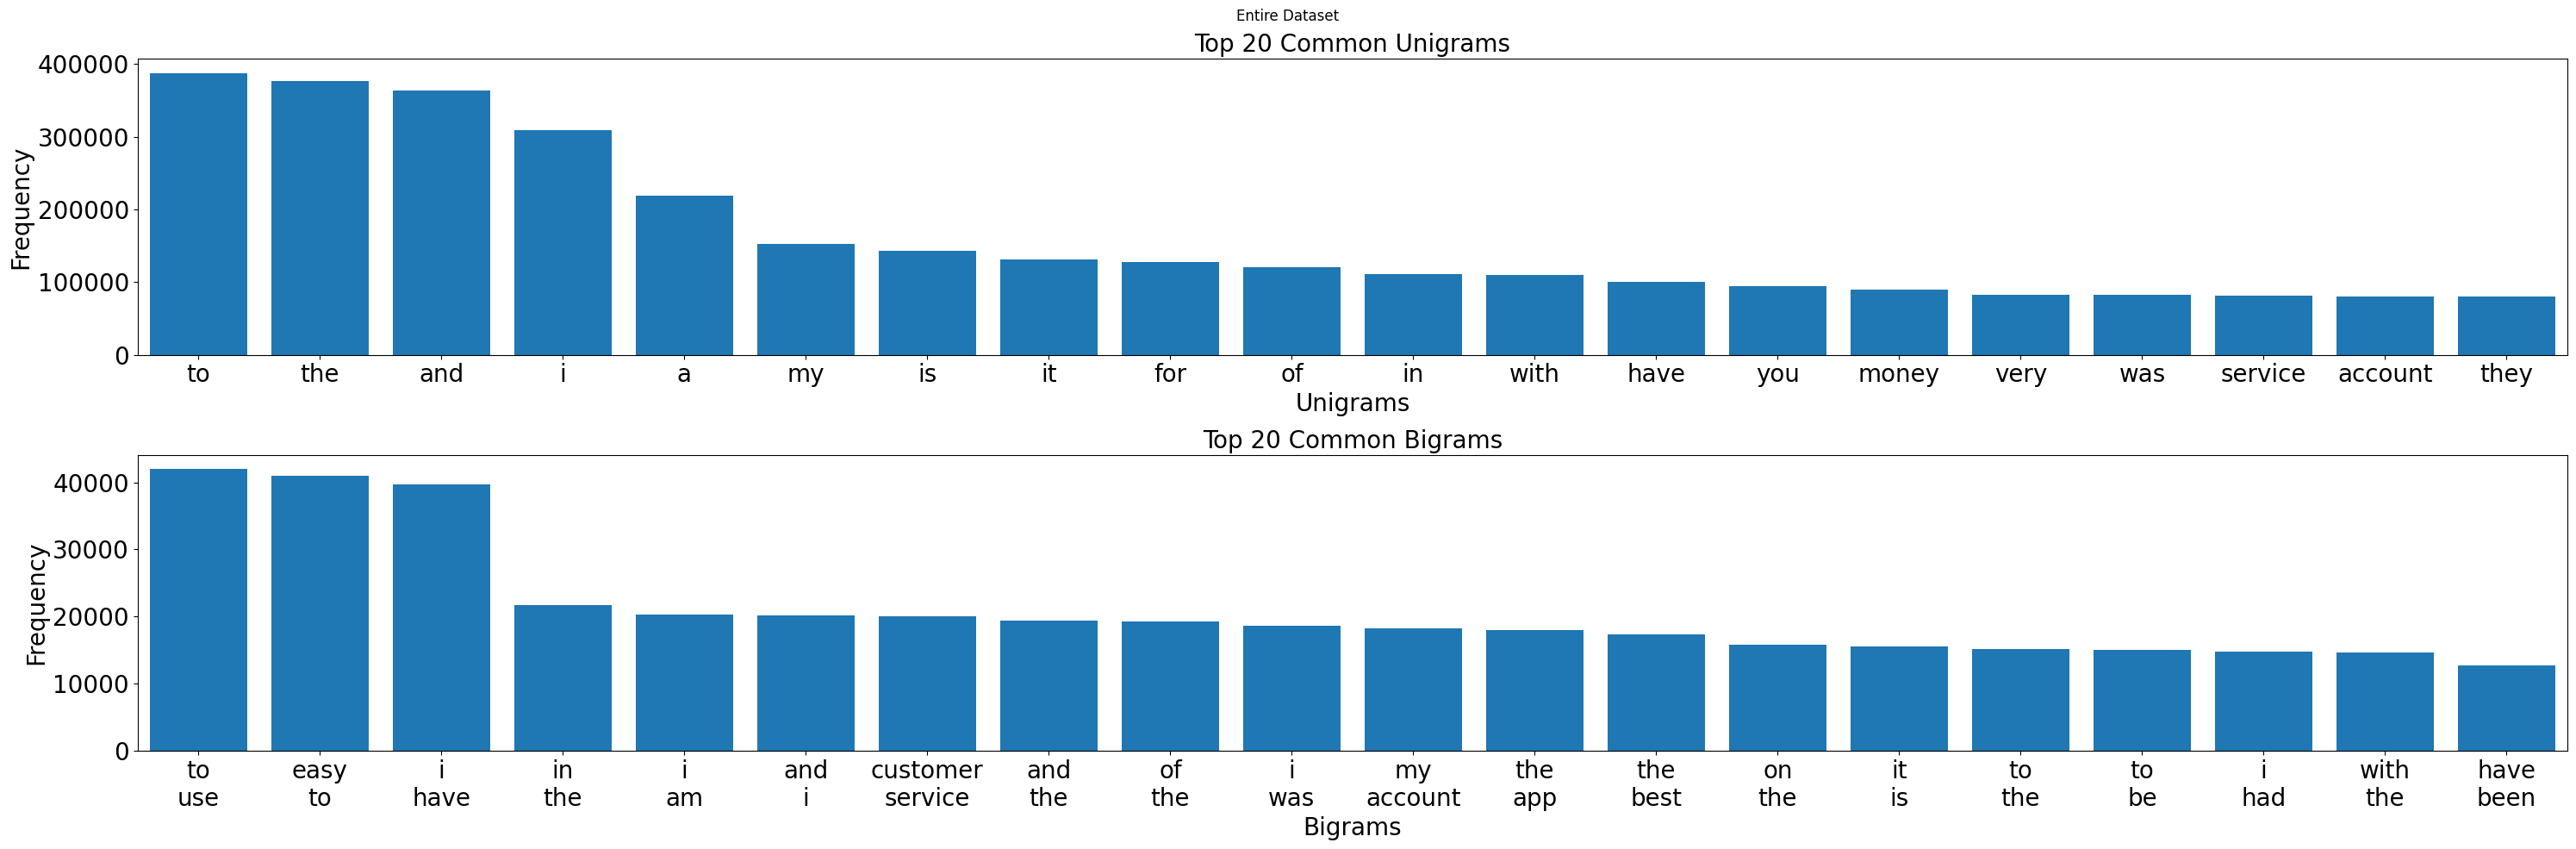

In [ ]:
dist_words_with_bank(df, "before", "all", "all", 20, 20)

# 2) Unigram and Bigram After Pre-Processing Over Entire Dataset

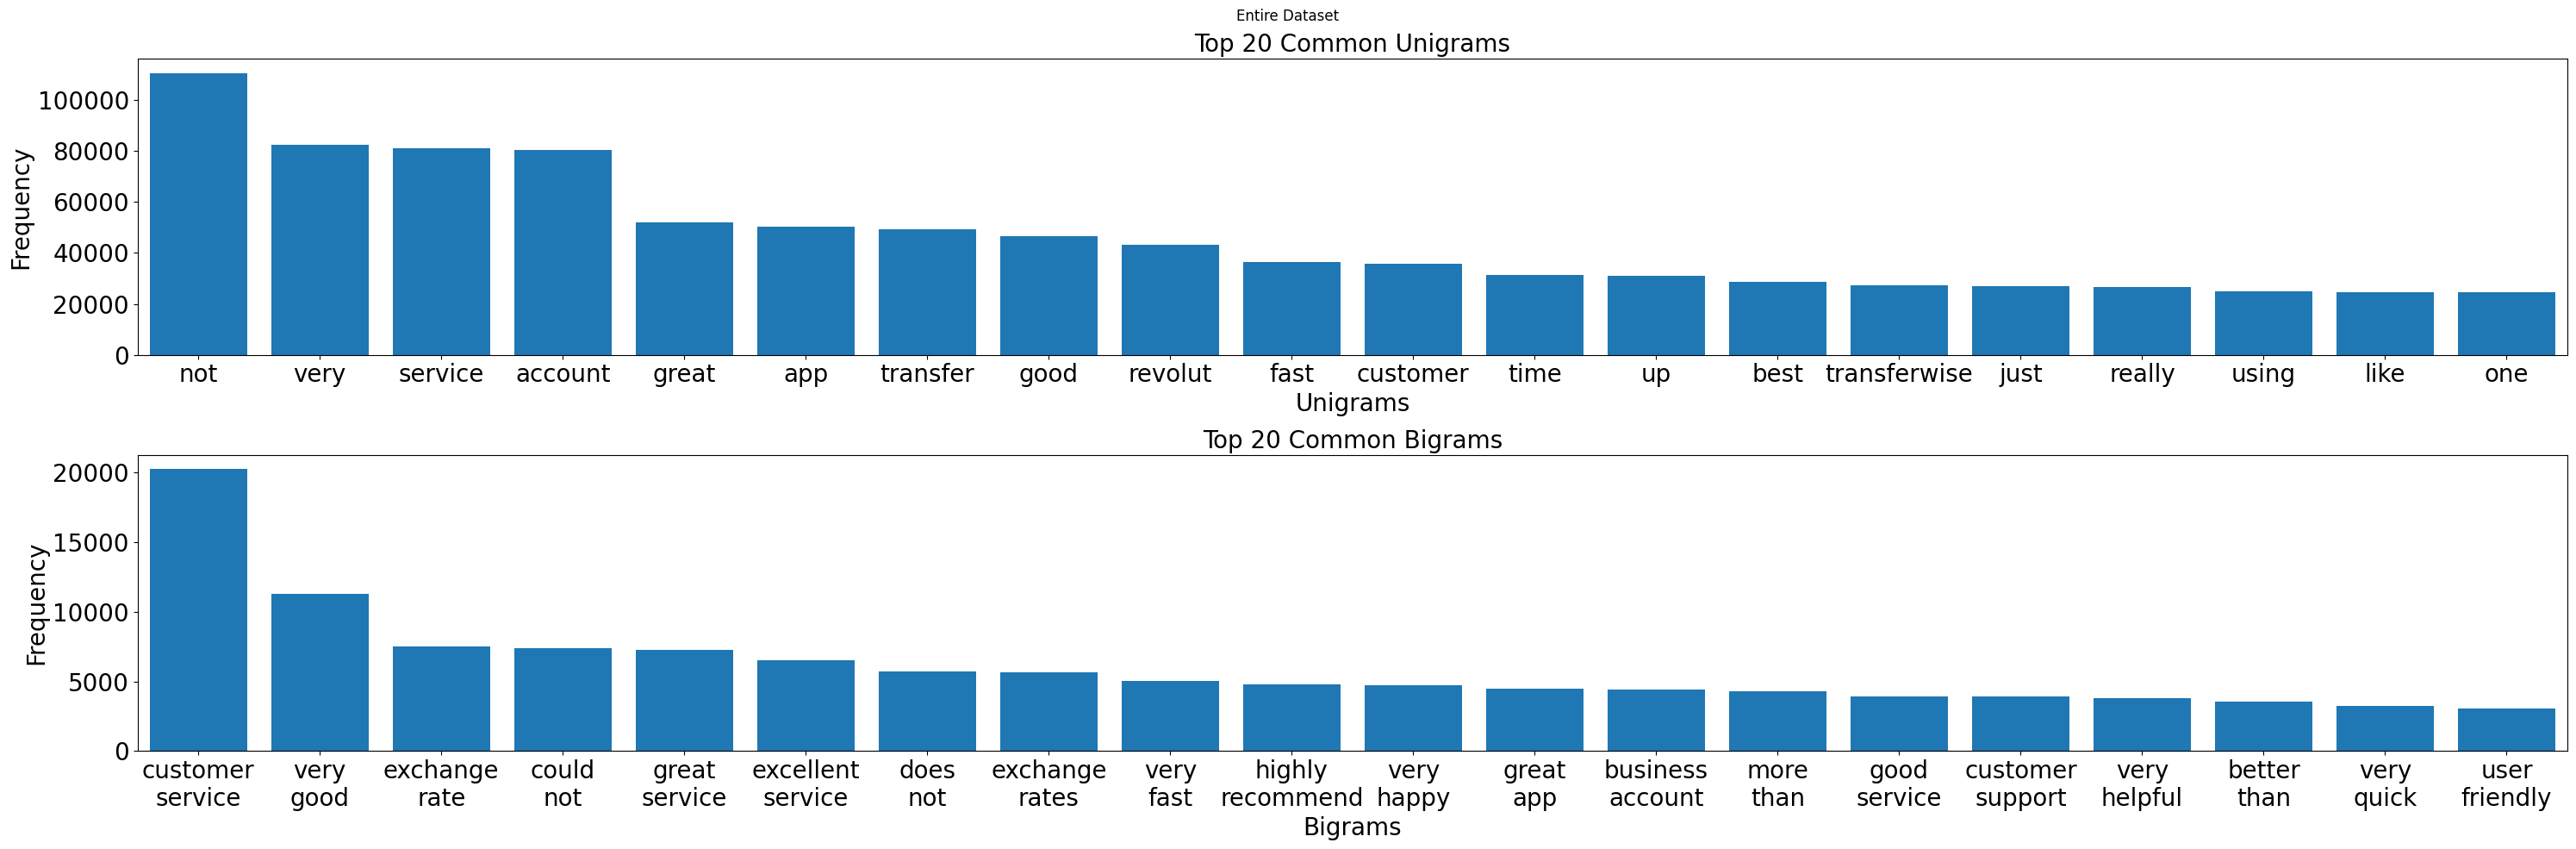

In [ ]:
dist_words_with_bank(df, "after", "all", "all", 20, 20)

# 3) Unigram and Birgram After Pre-Processing Over Poor Reviews of Each Bank

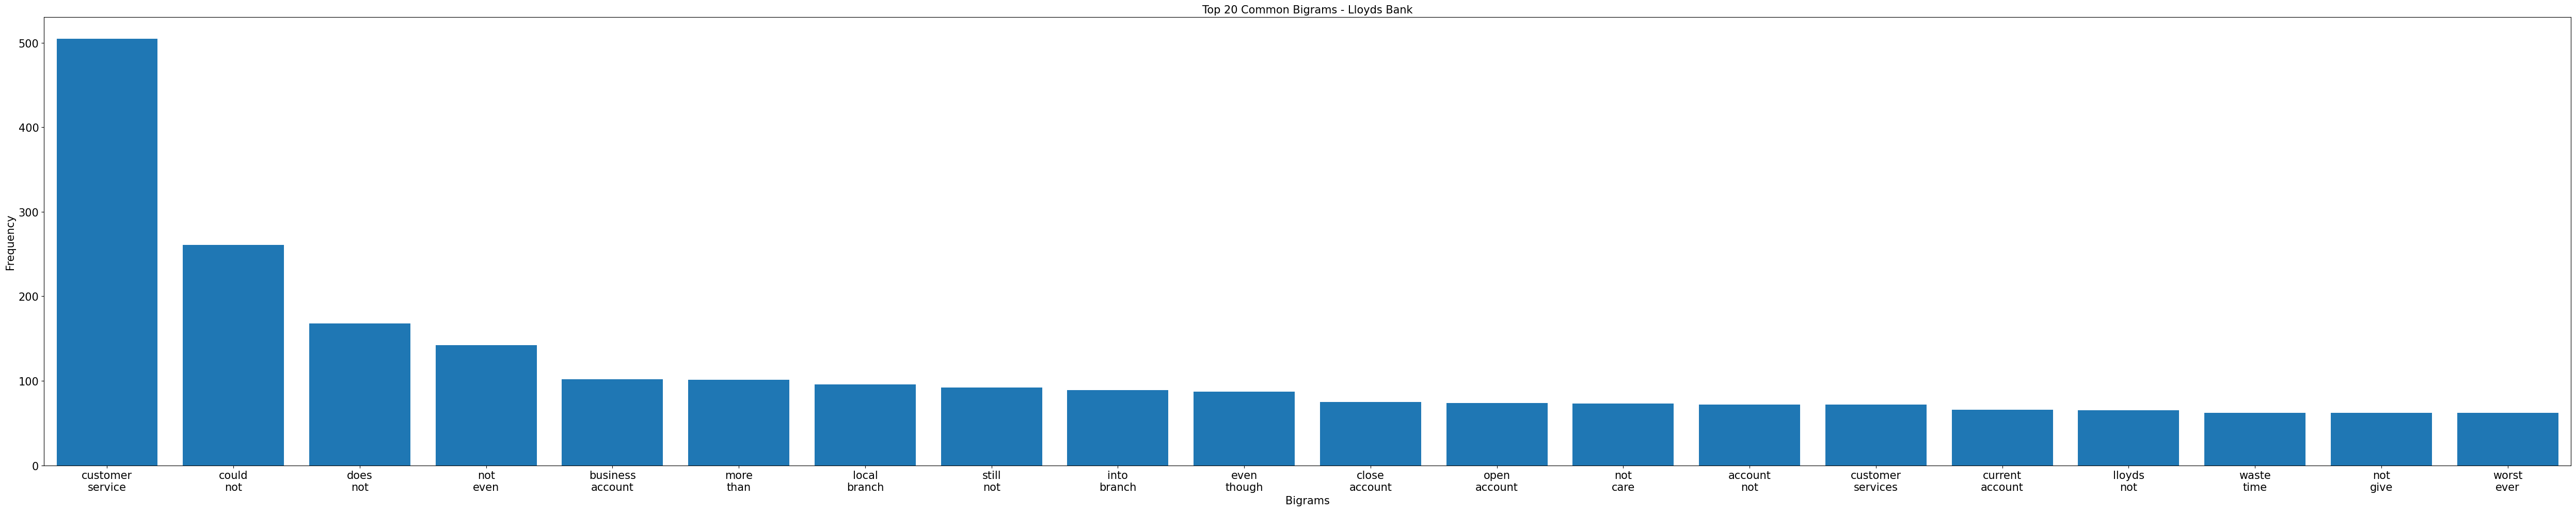

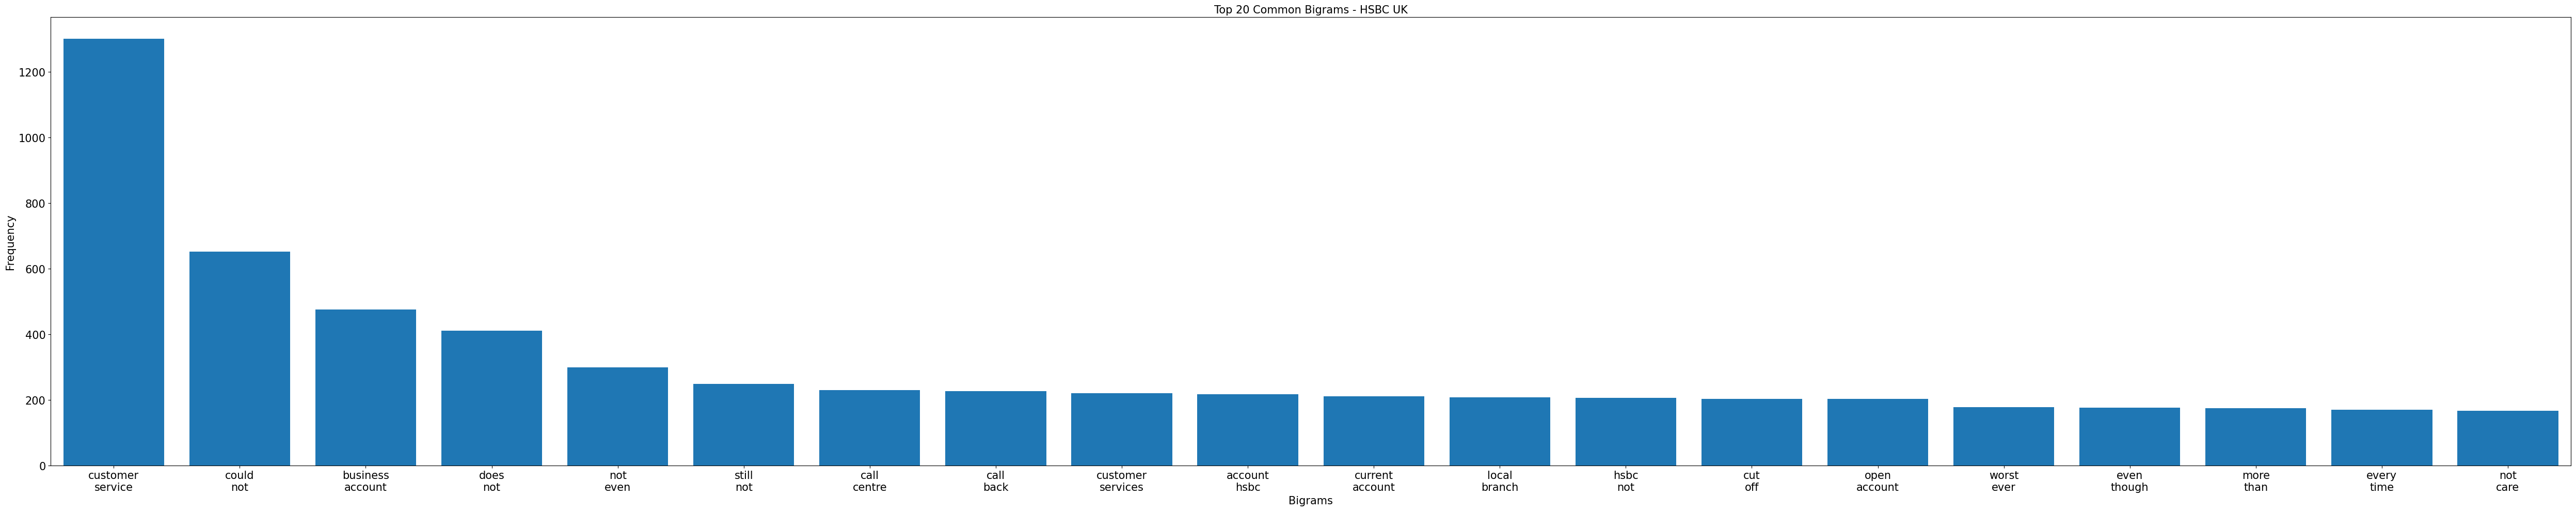

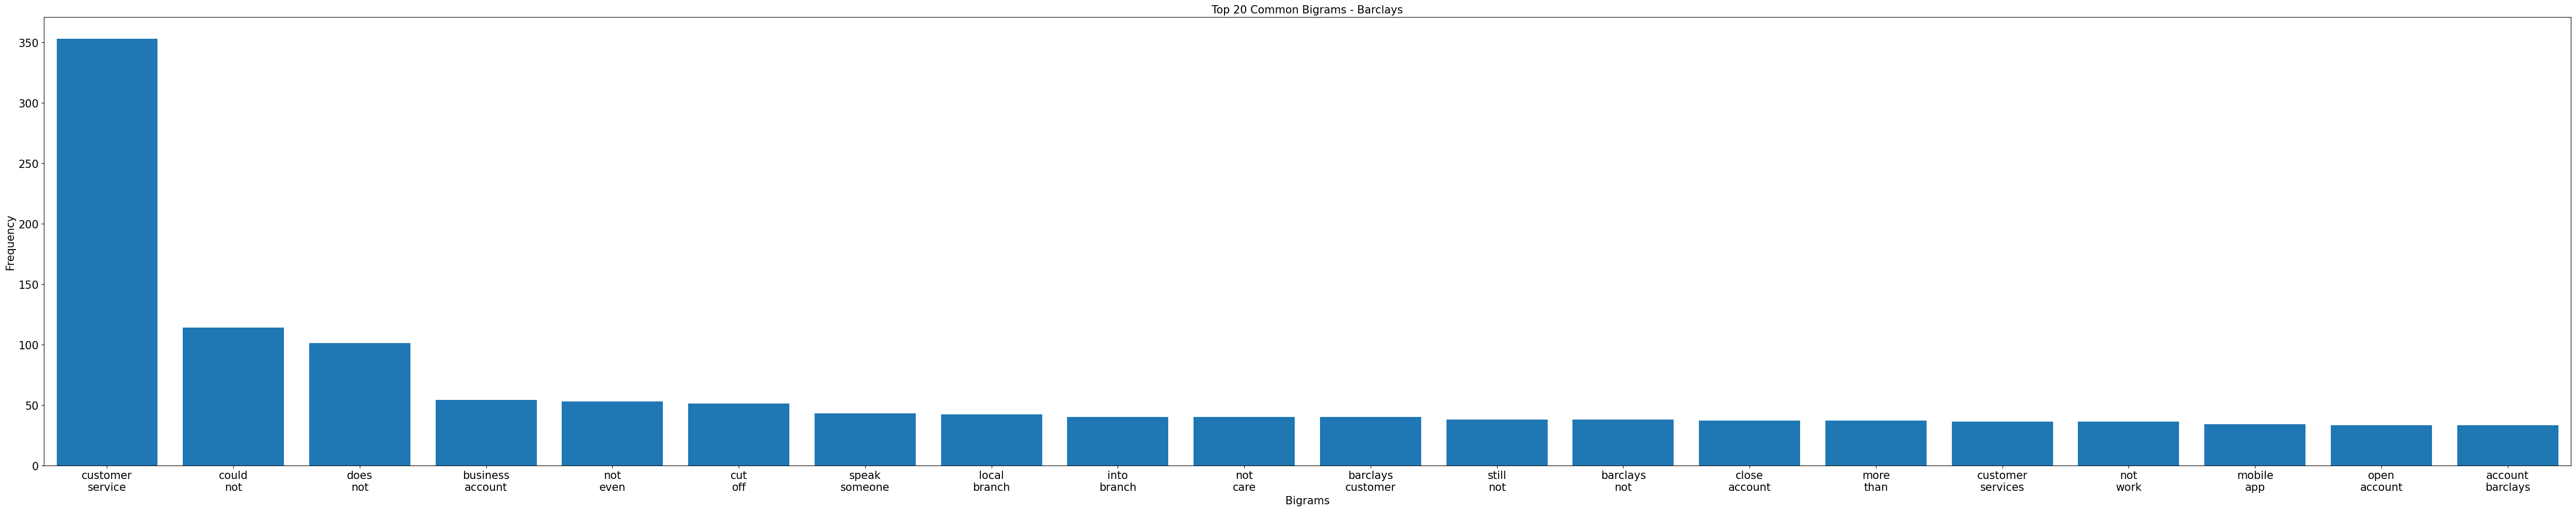

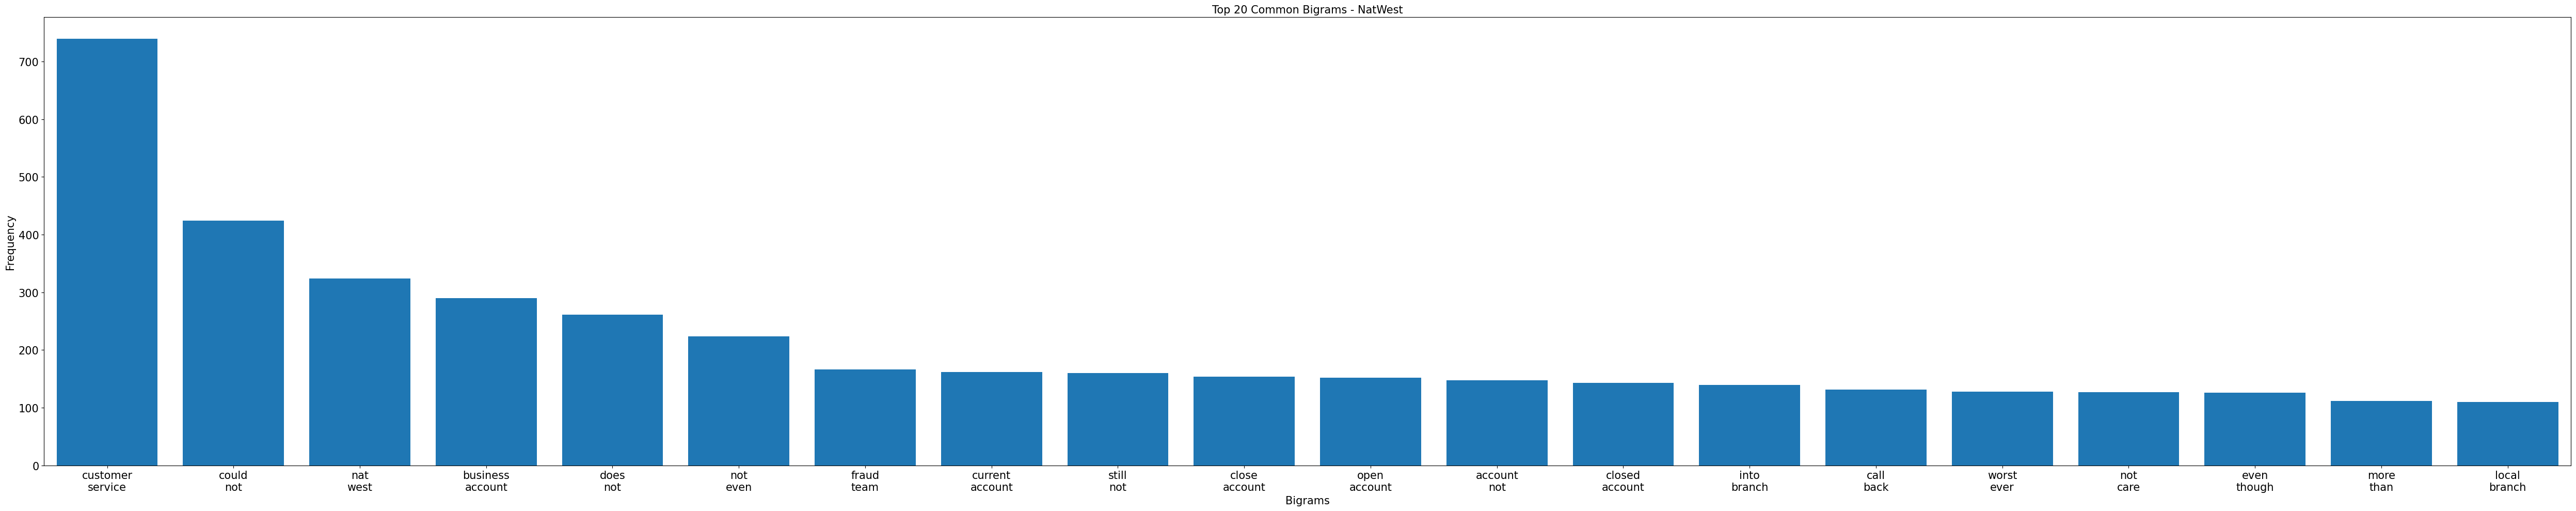

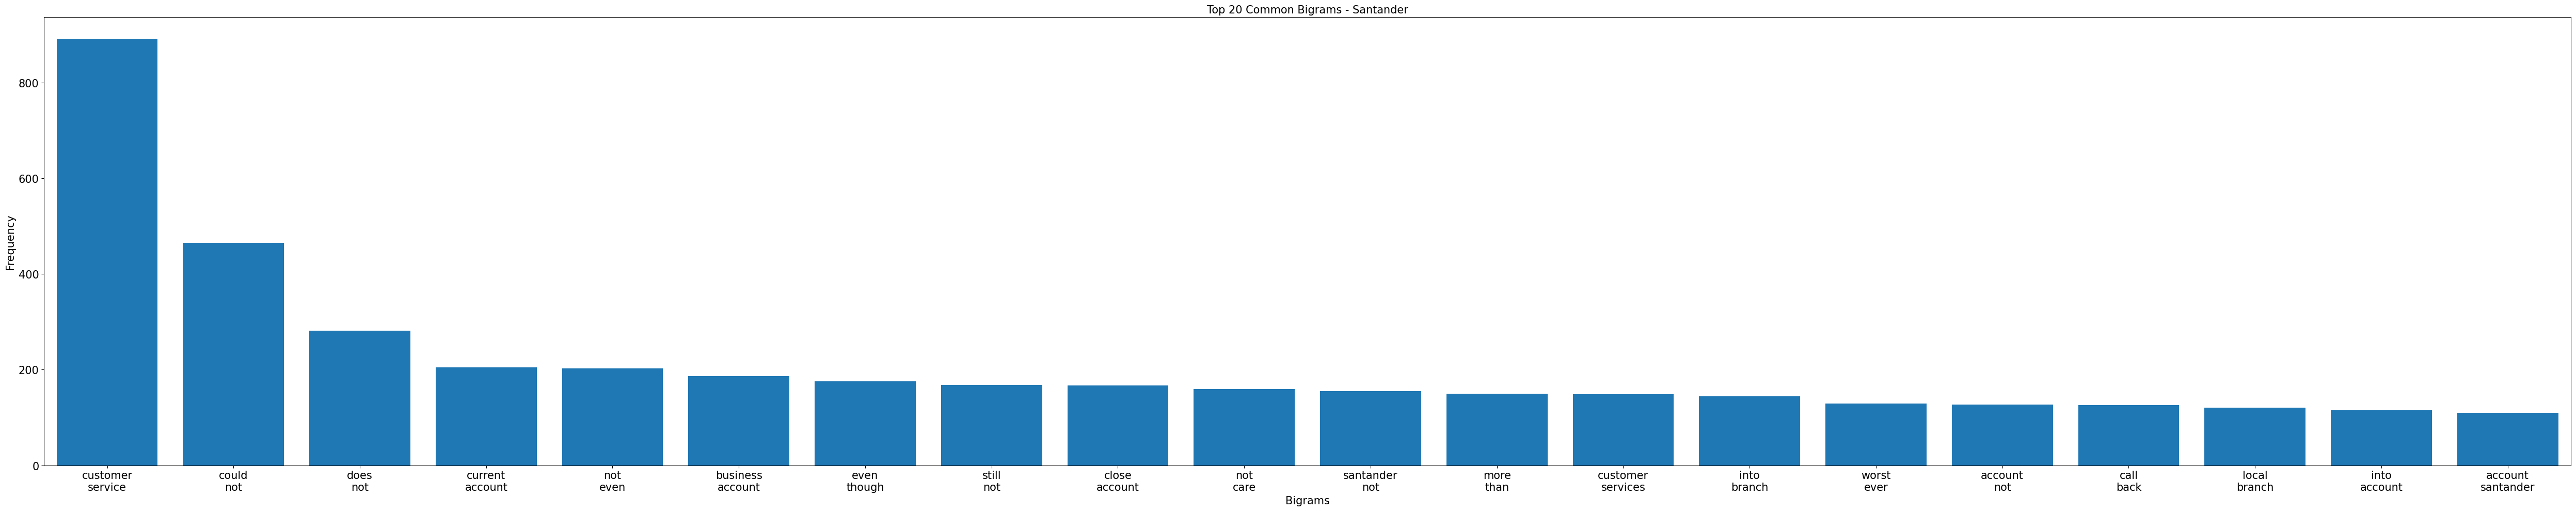

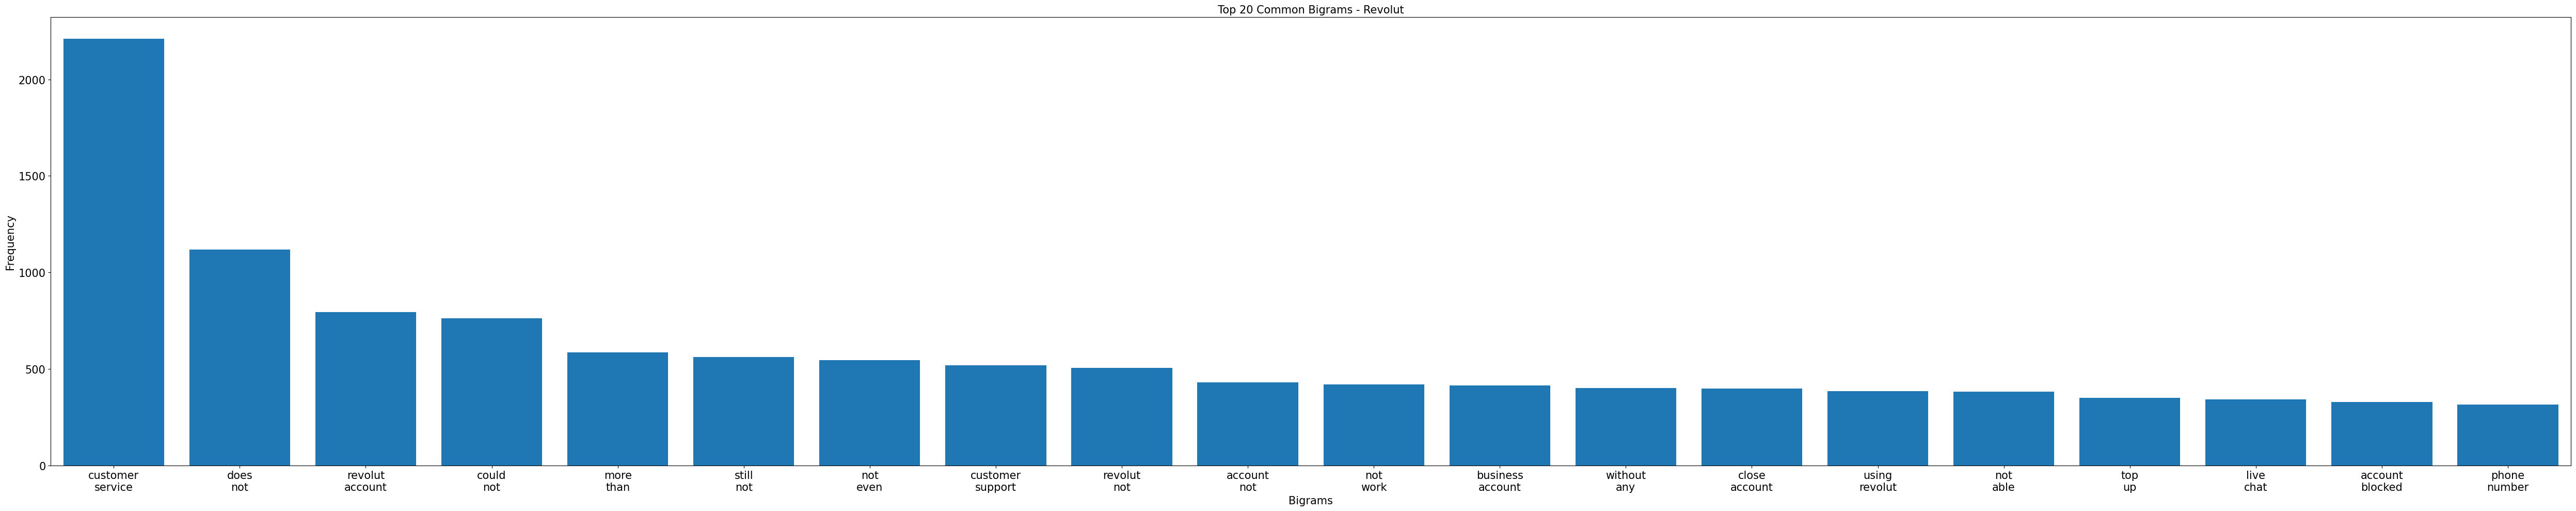

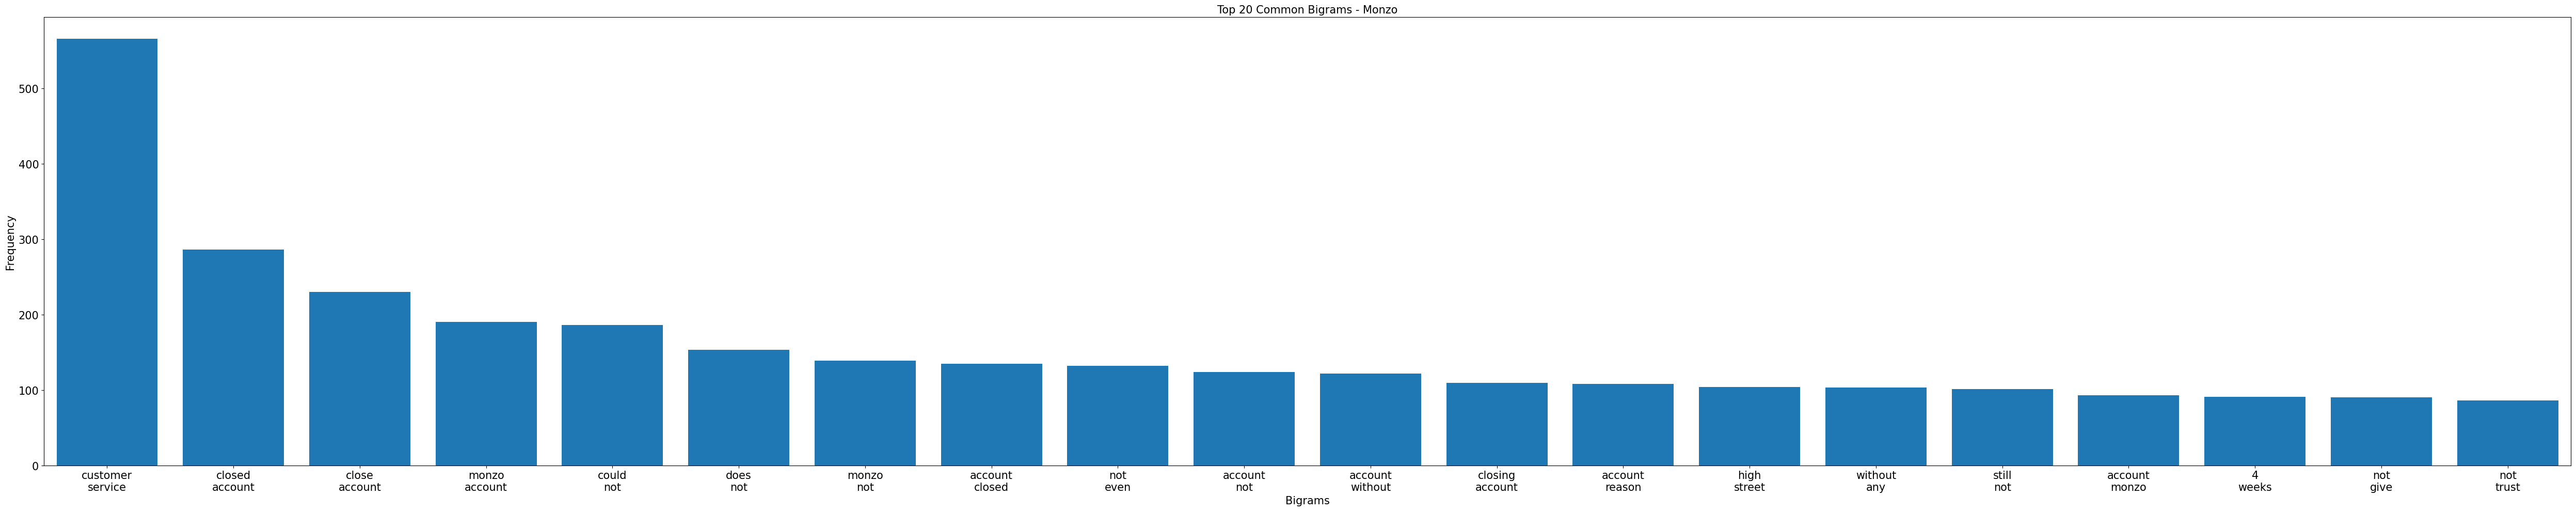

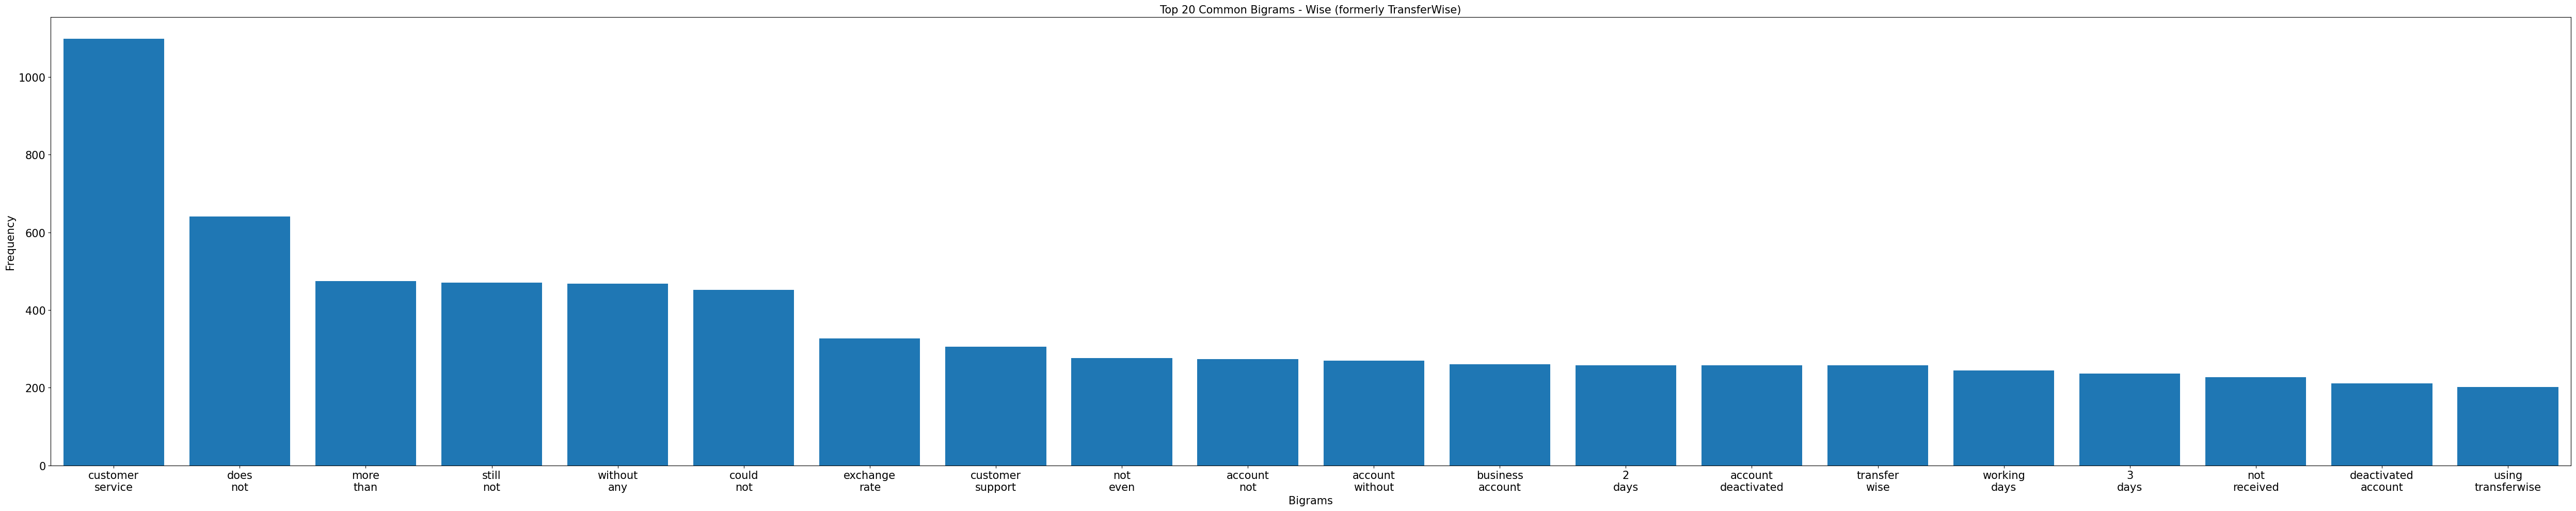

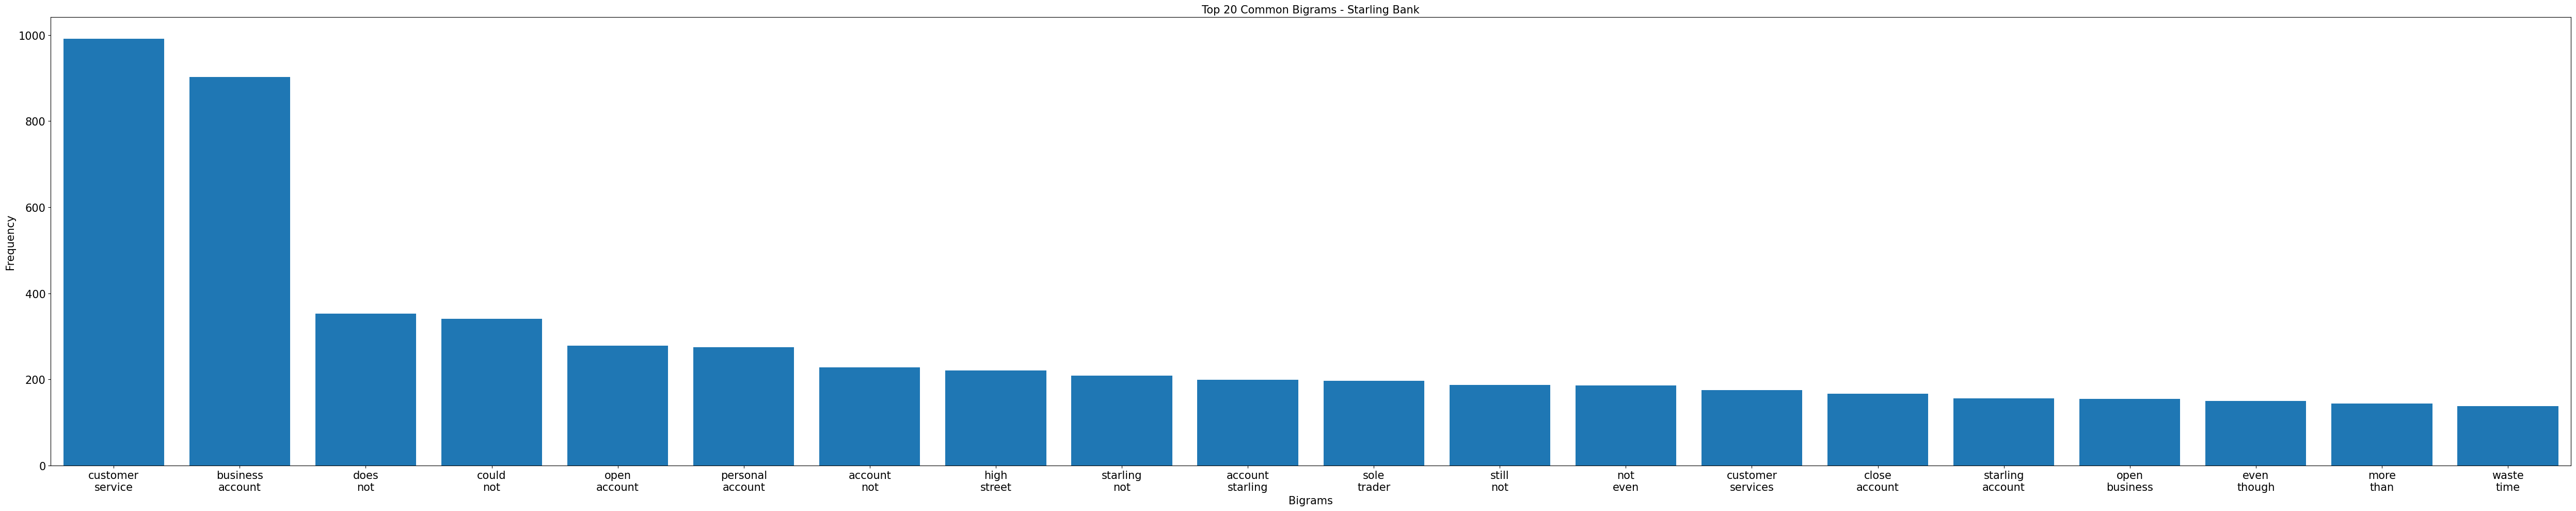

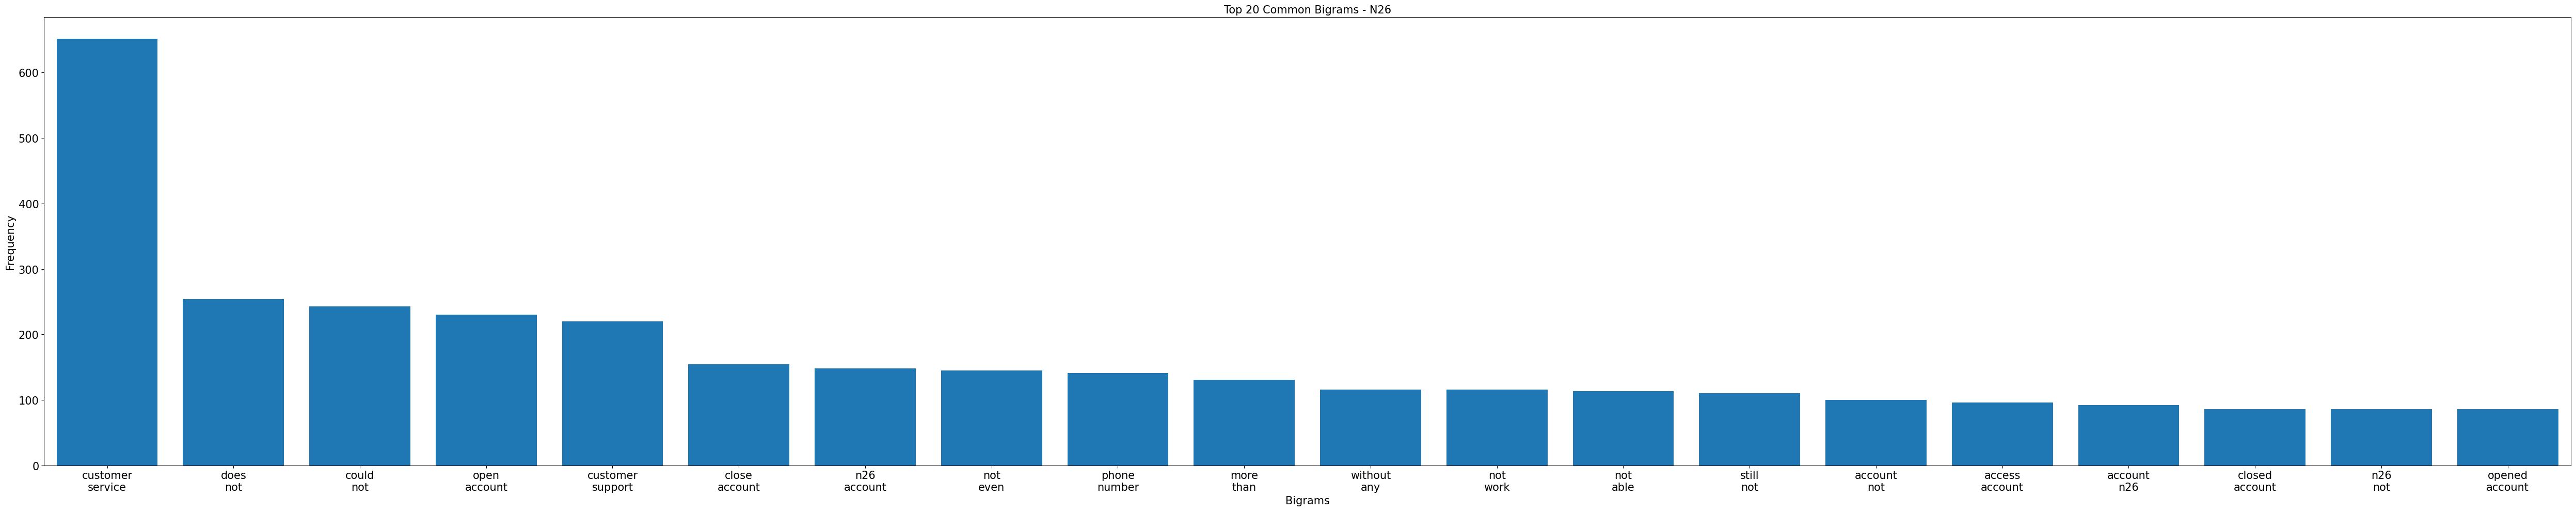

In [ ]:
for bank in bank_names:
    dist_words_bank(df, "after", bank, "poor", 20, "with")

# 4) Unigram and Birgram After Pre-Processing and Removing Bank Names Over Poor Reviews of Each Bank

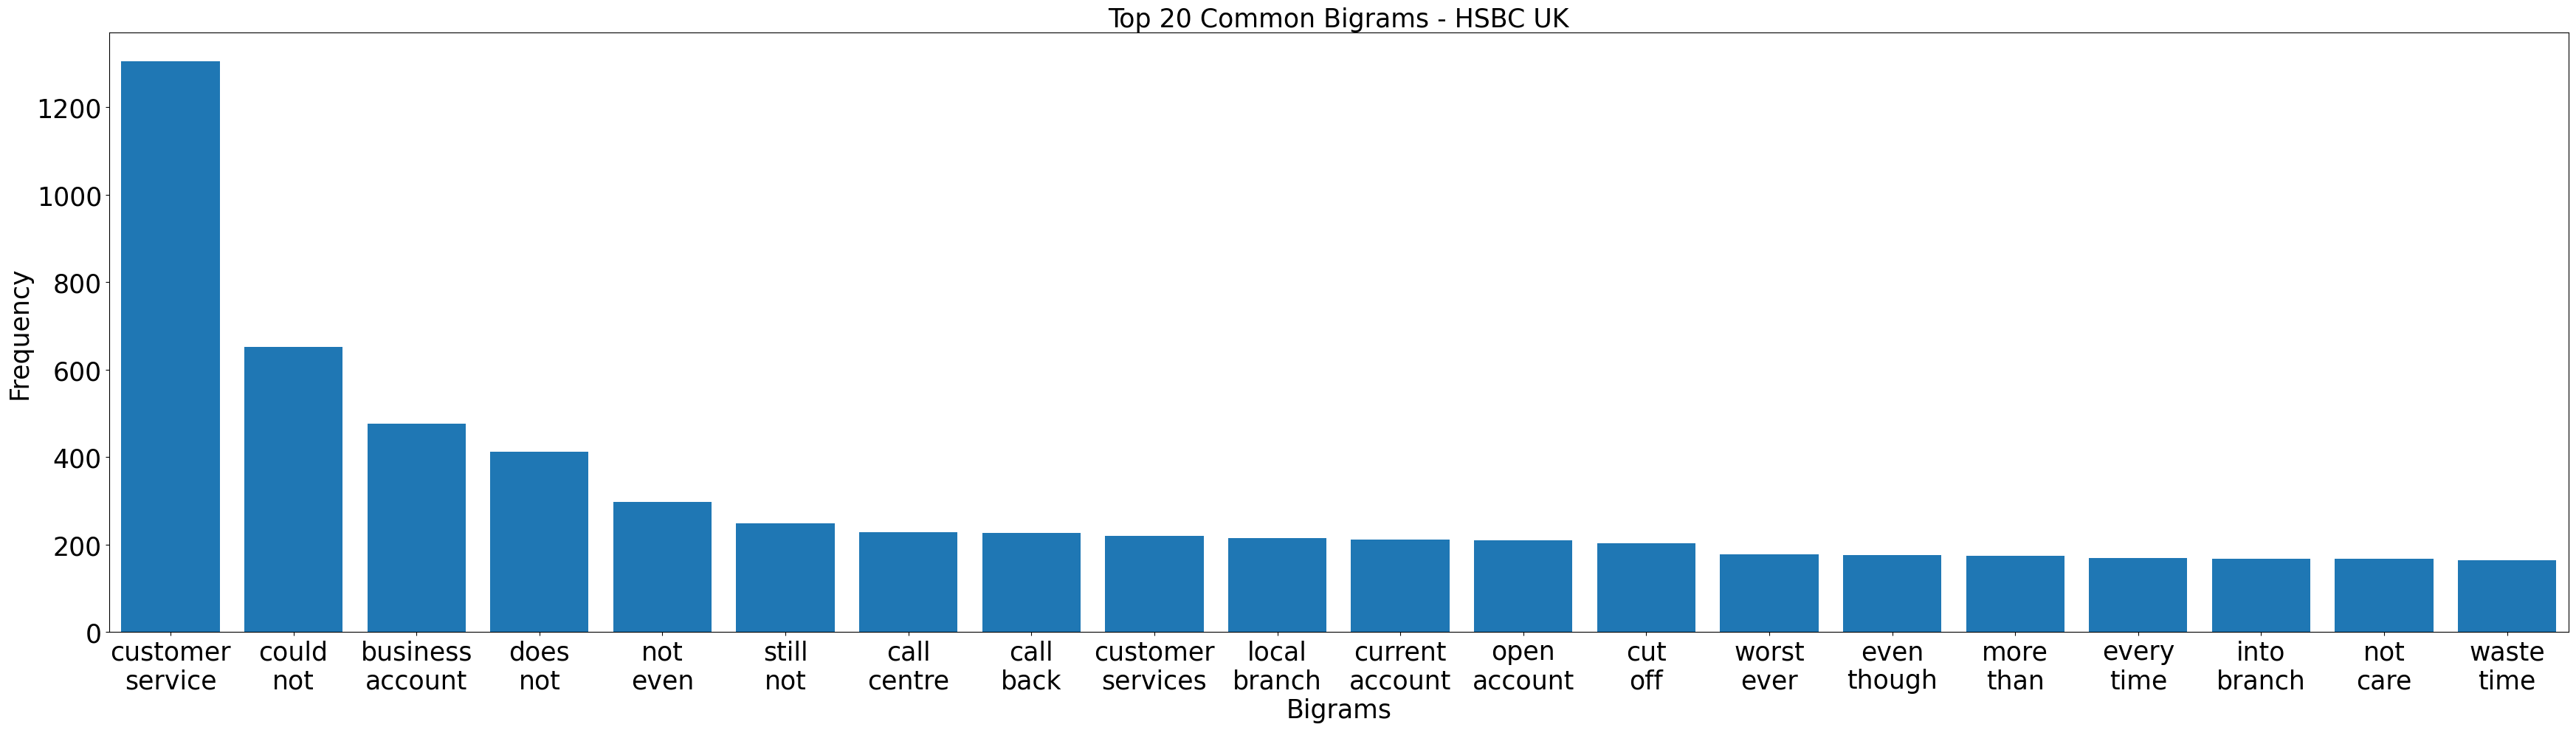

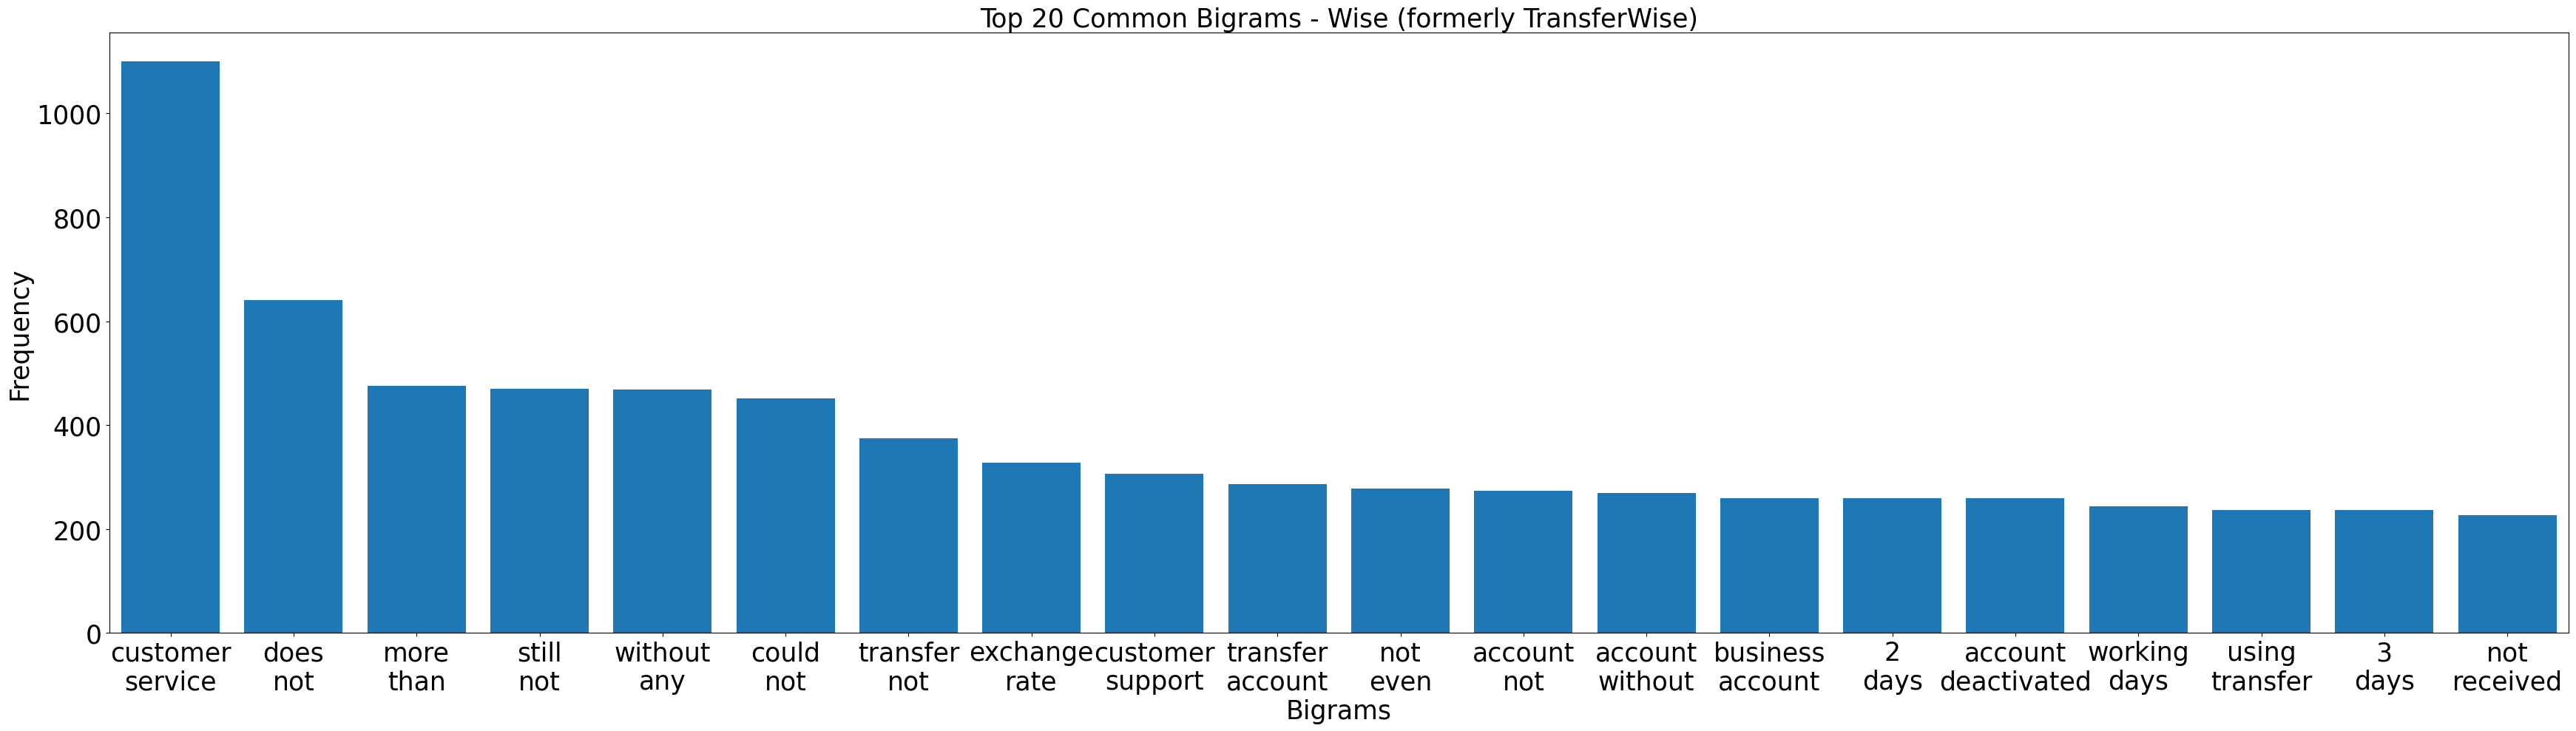

In [ ]:
plot_banks = ["HSBC UK", "Wise (formerly TransferWise)"]

for bank in plot_banks:
    dist_words_bank(df, "after", bank, "poor", 20, "without", 25)

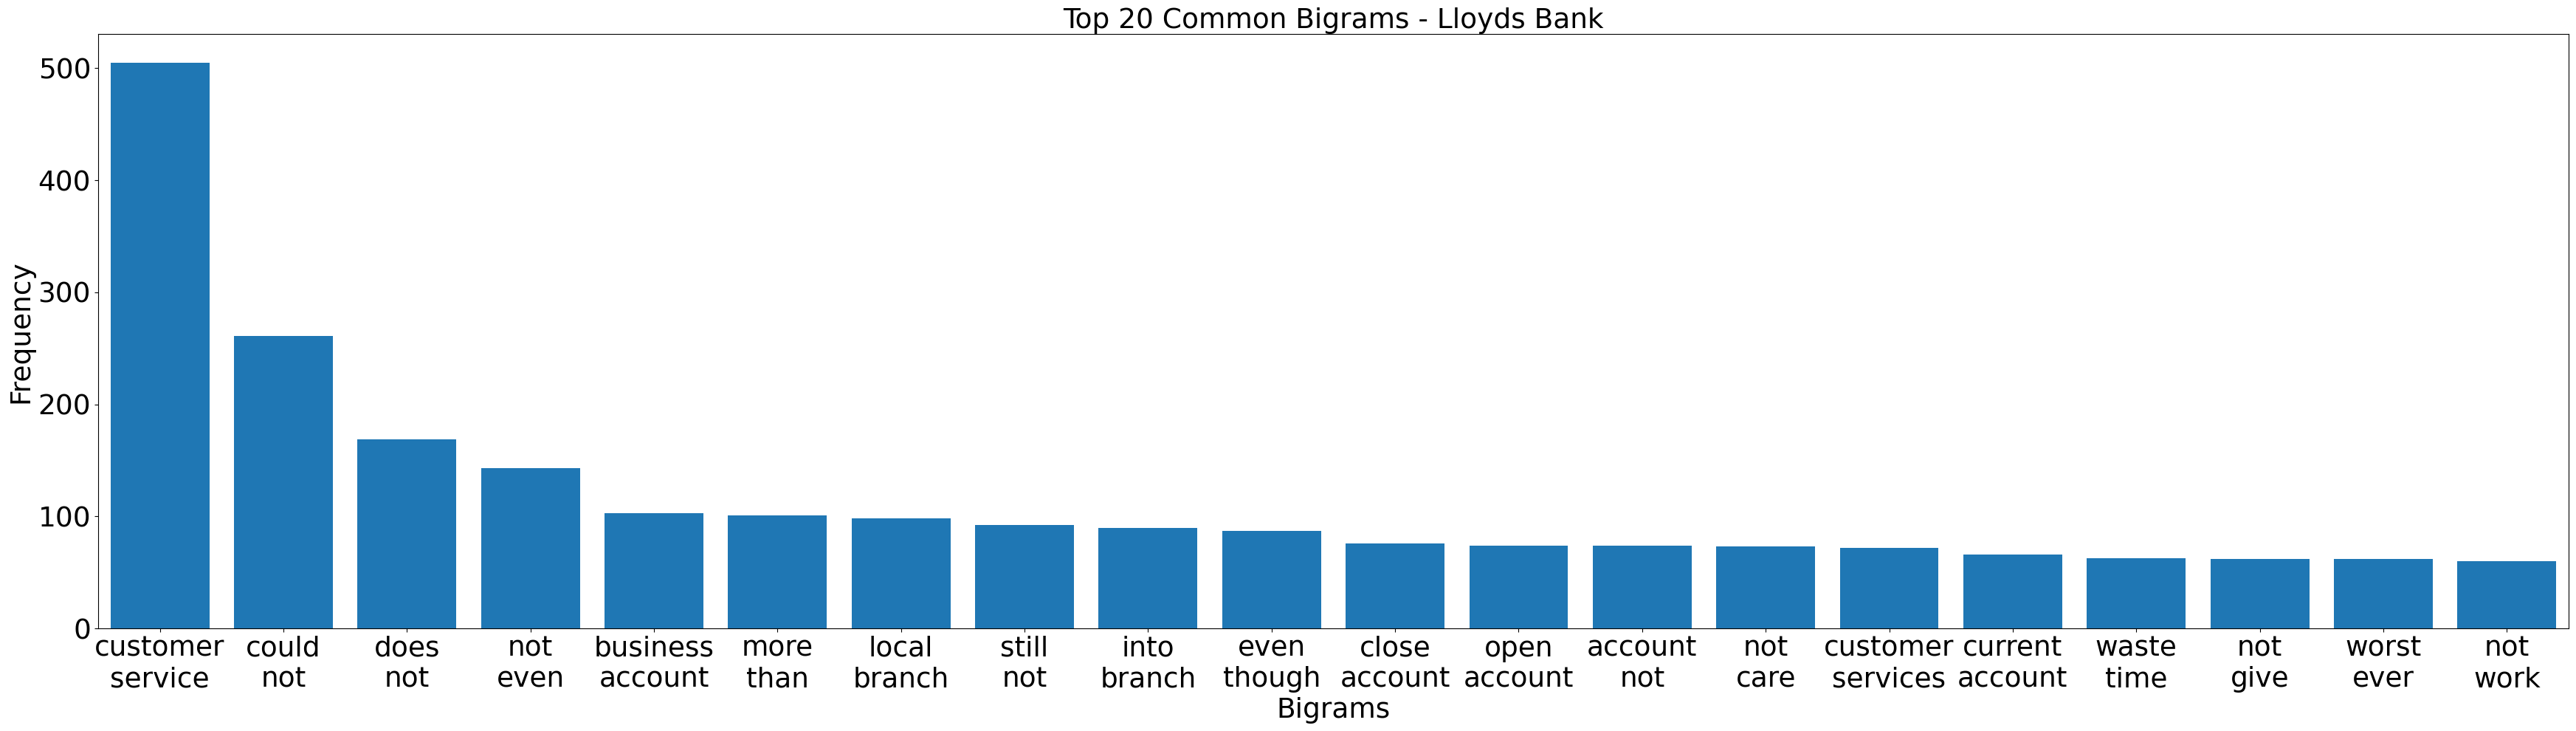

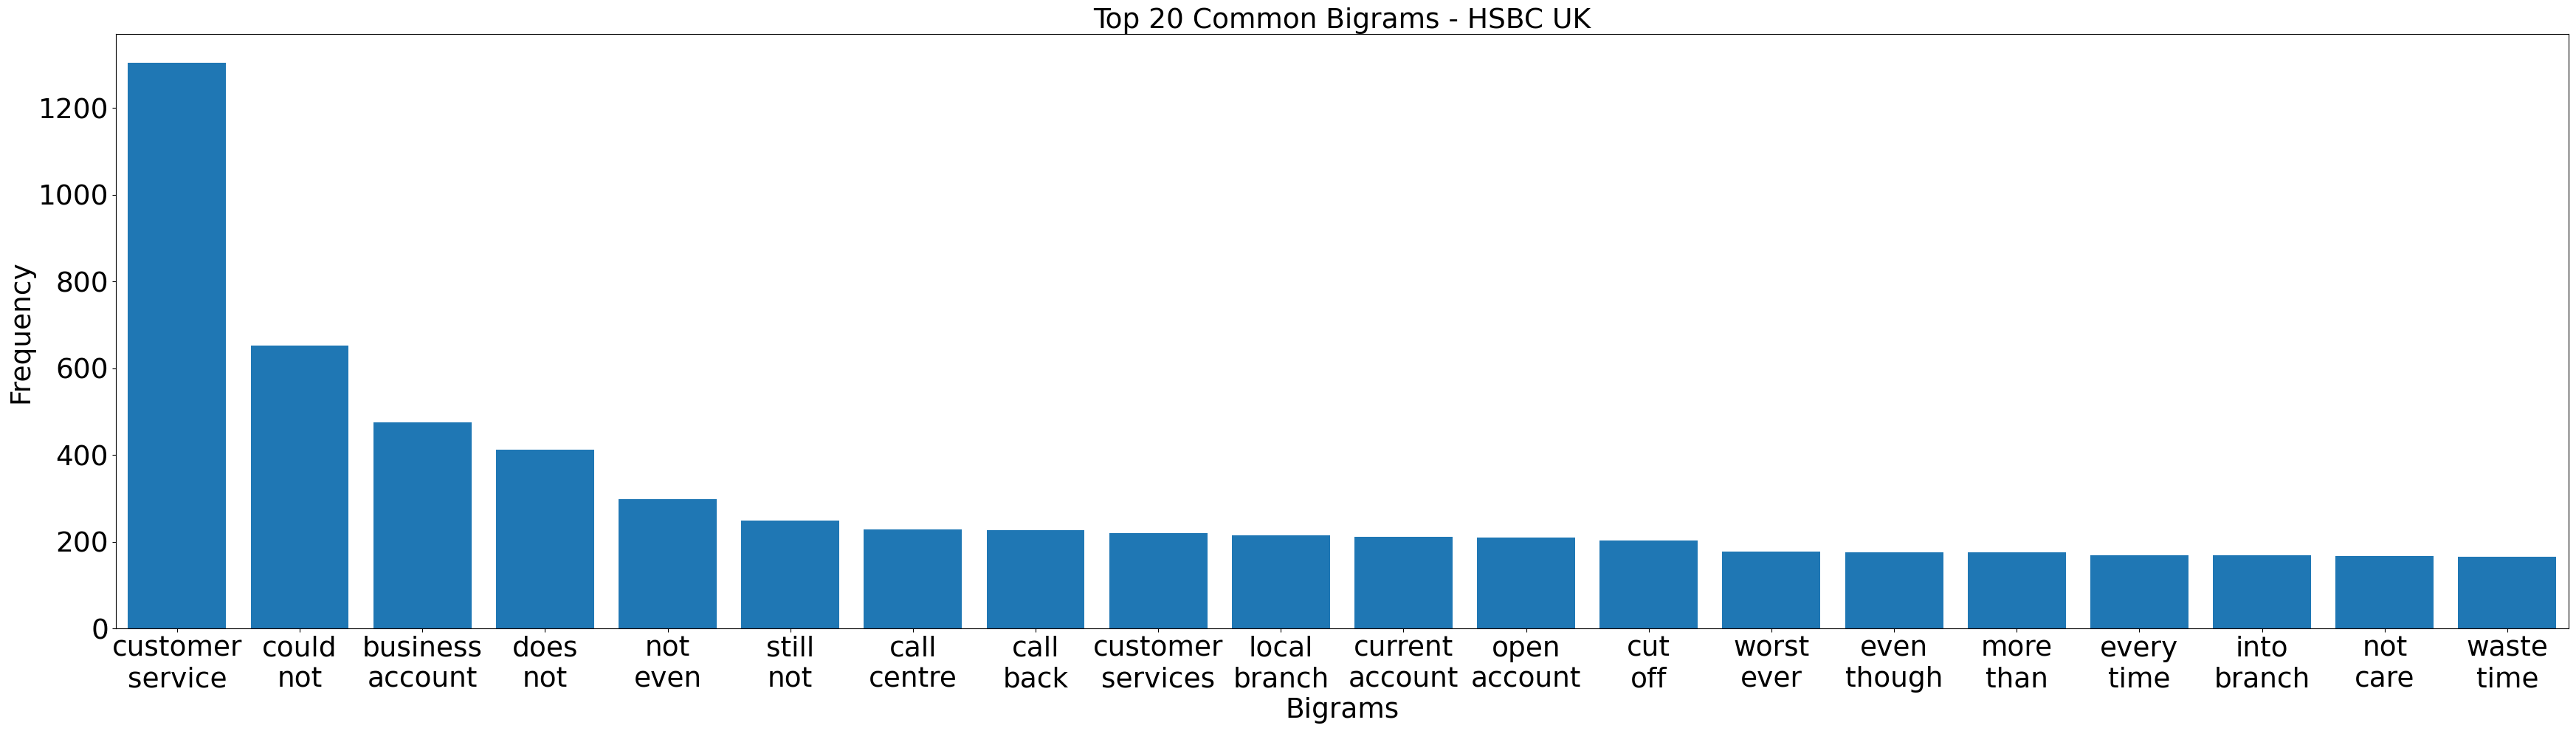

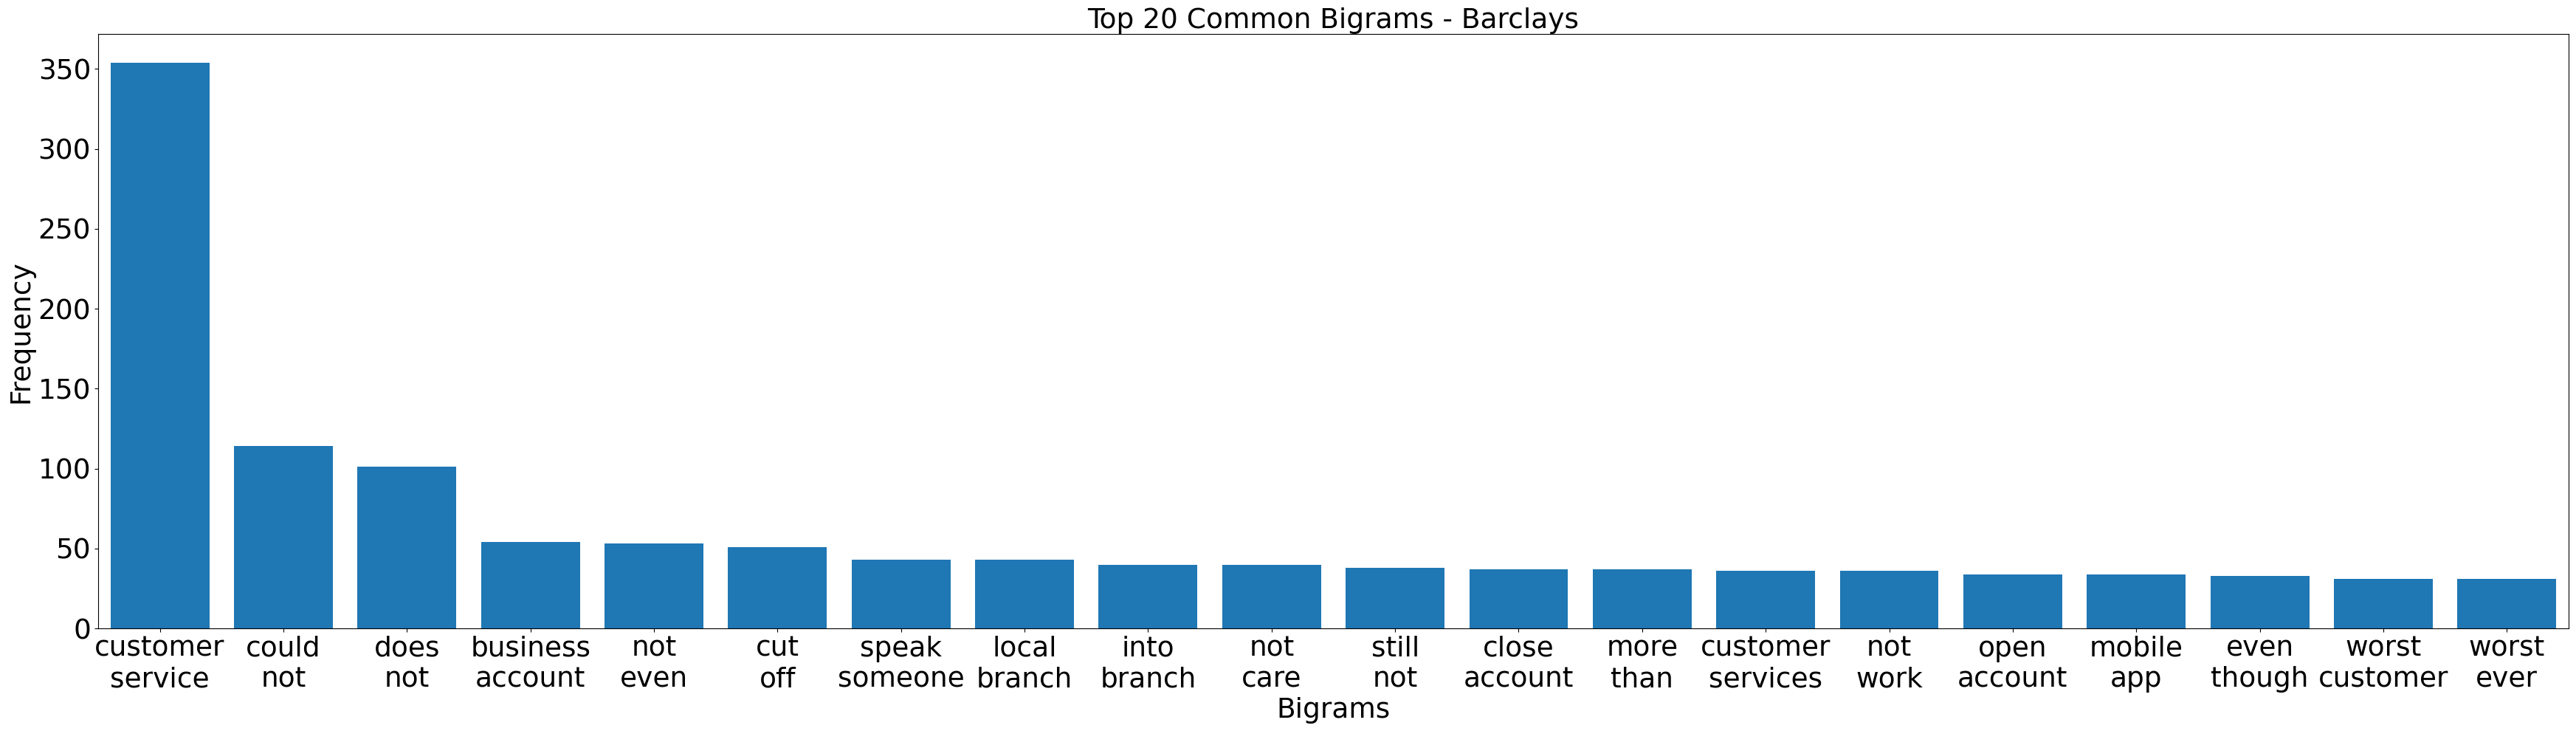

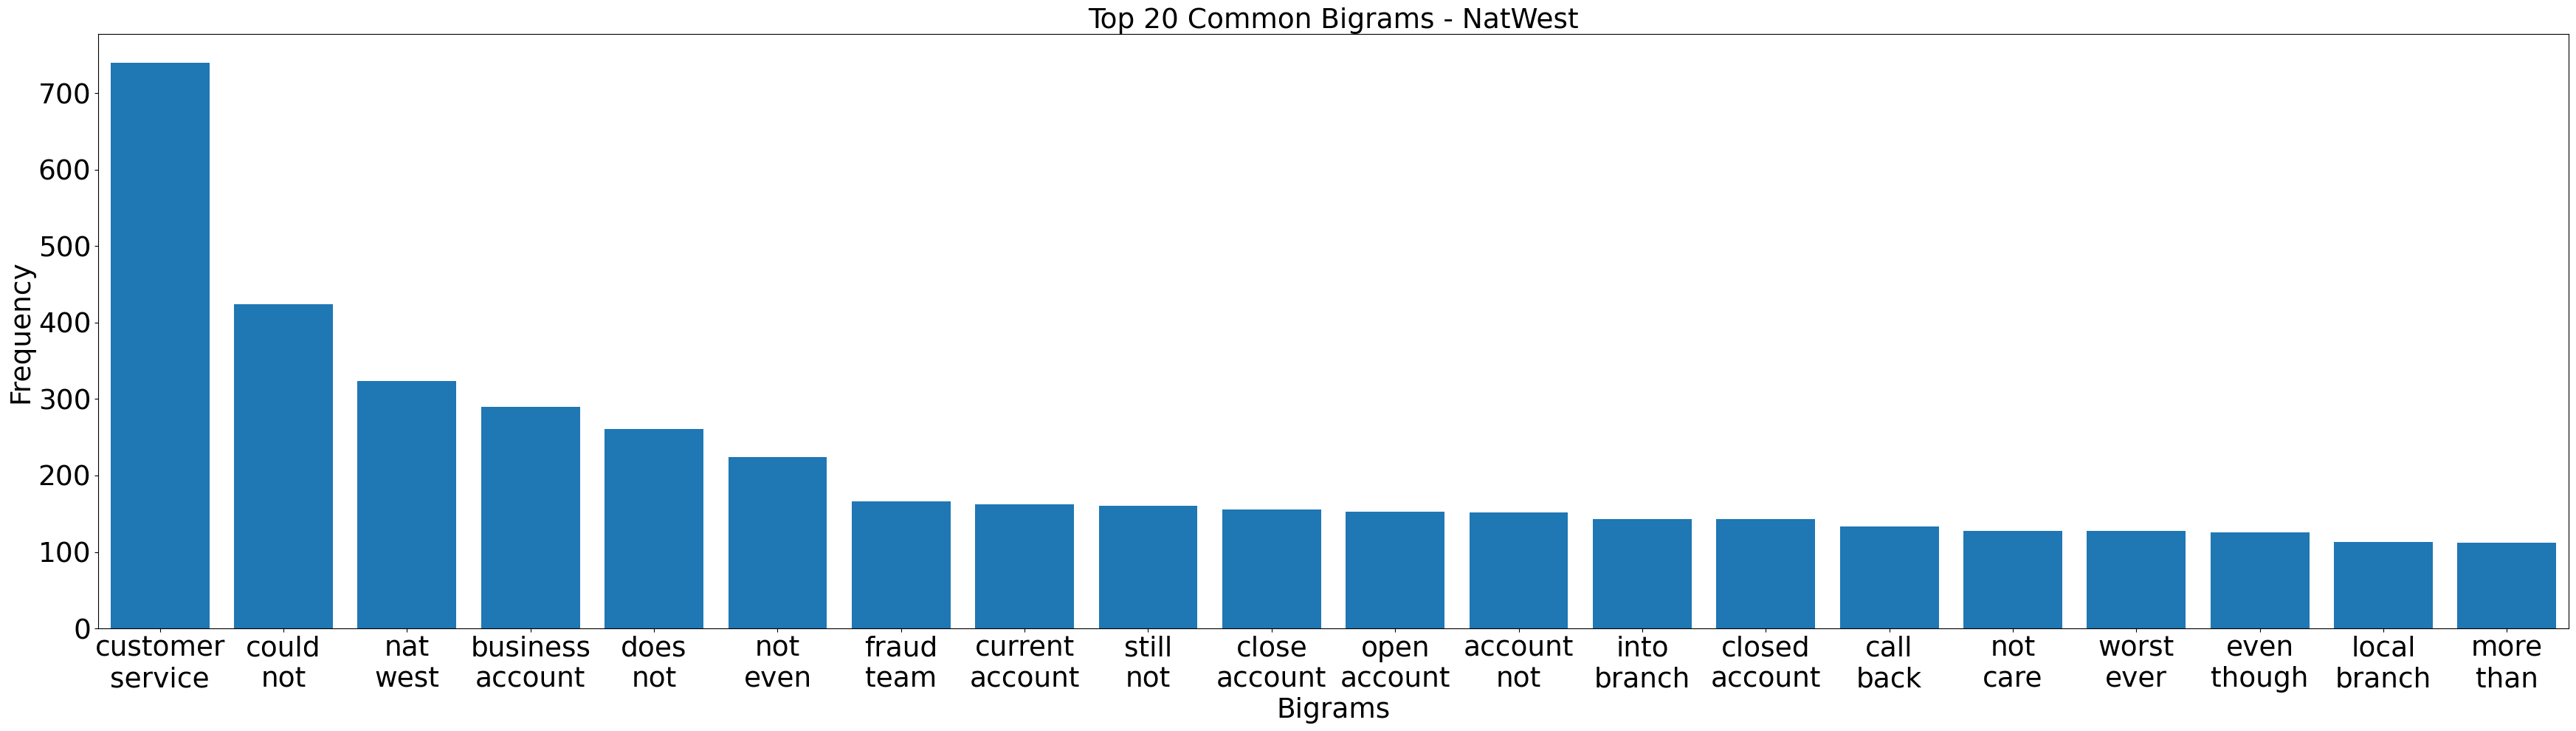

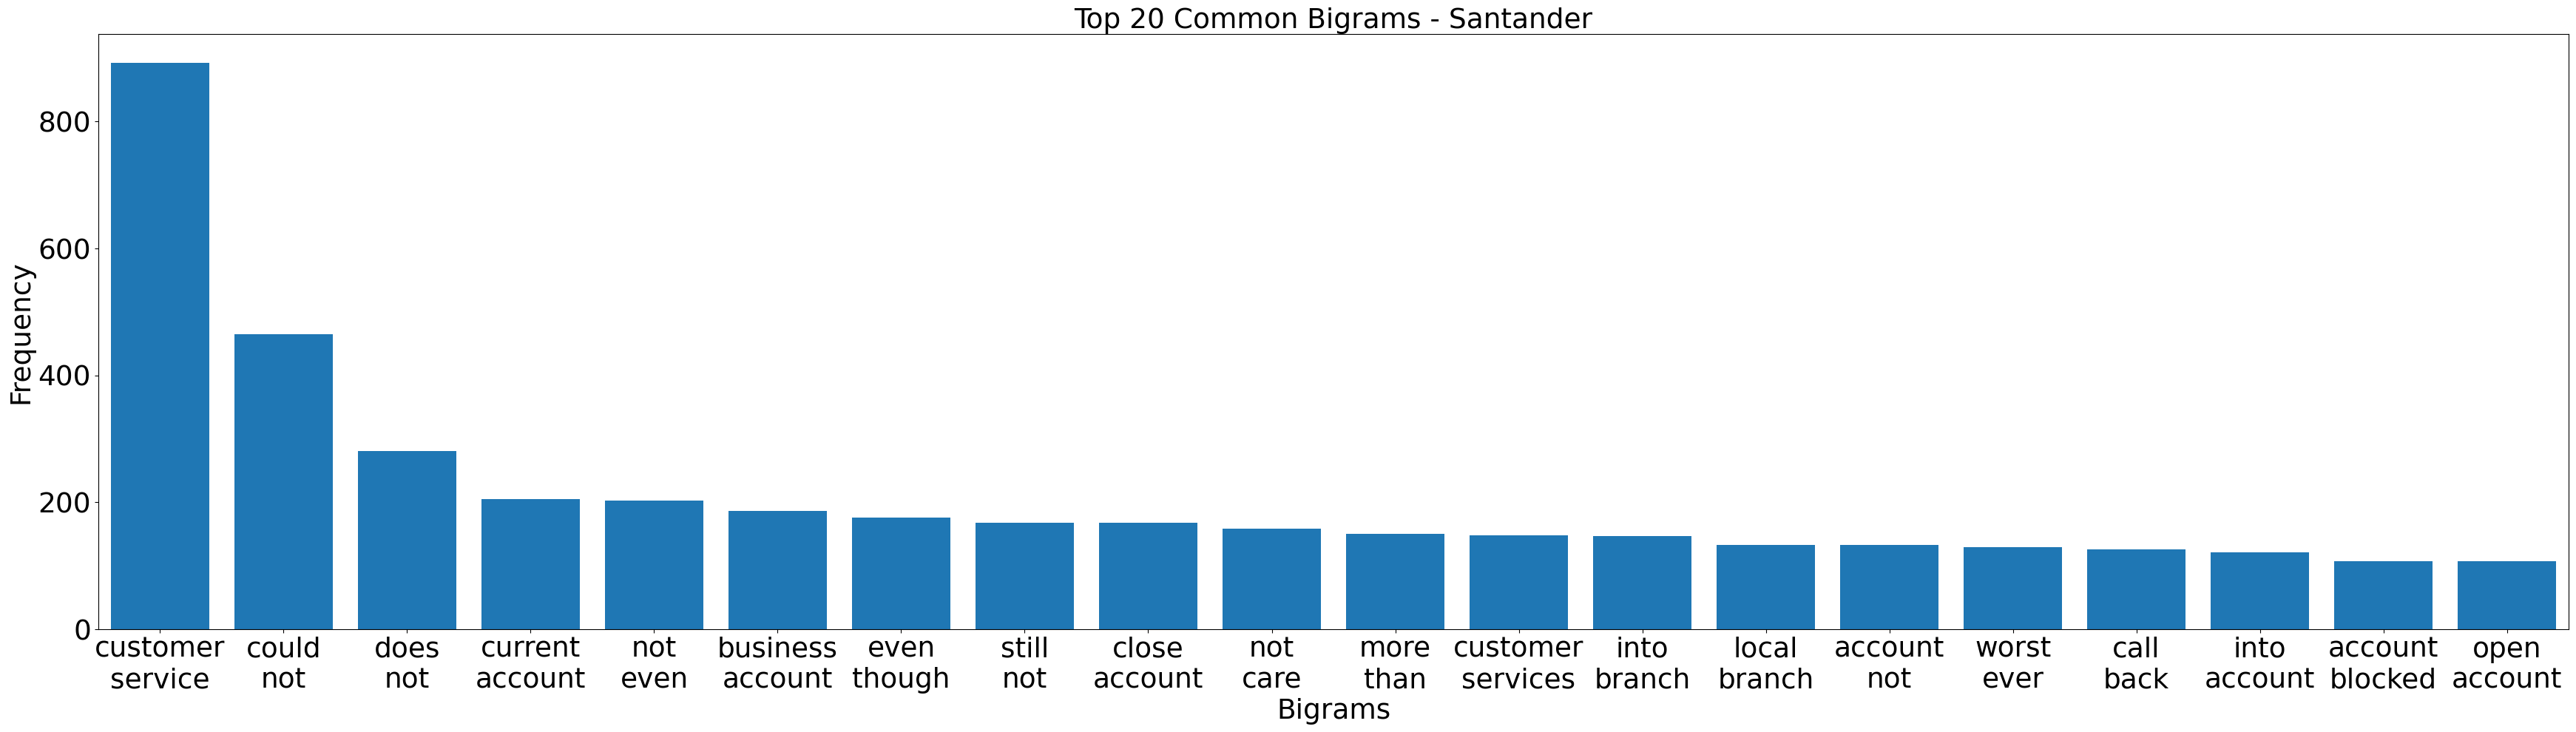

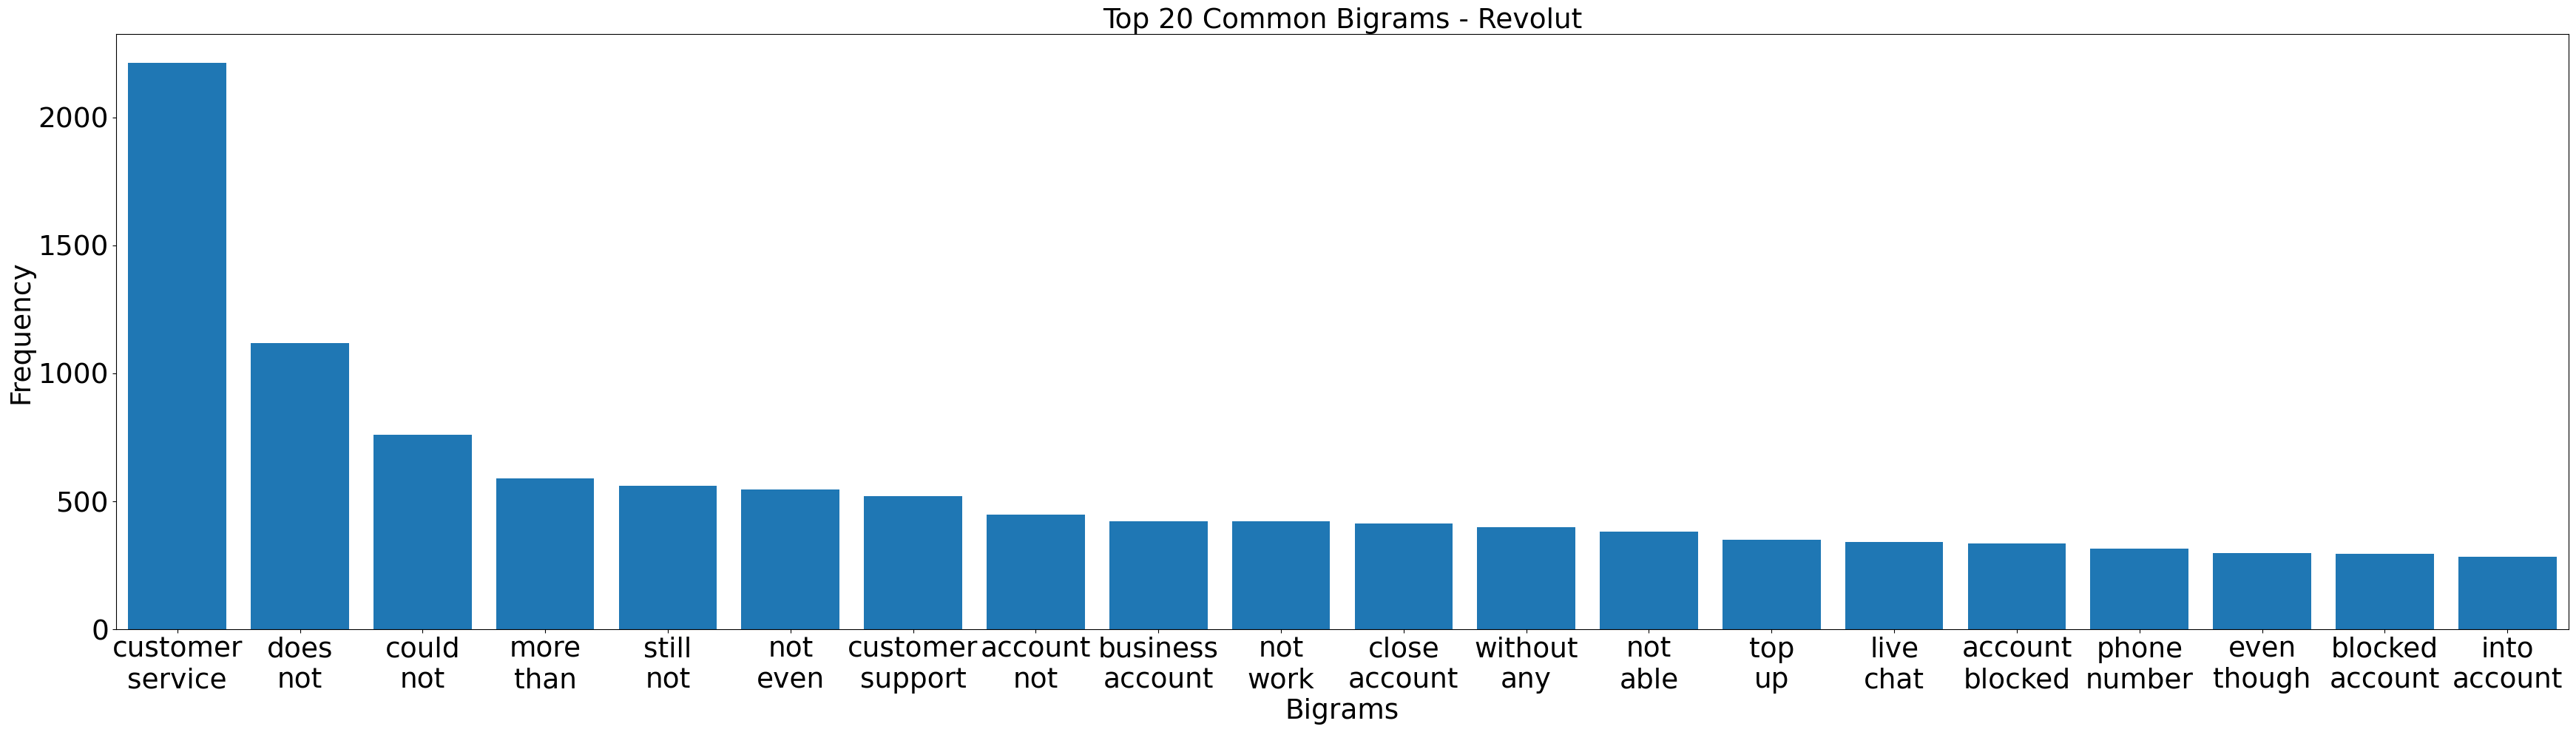

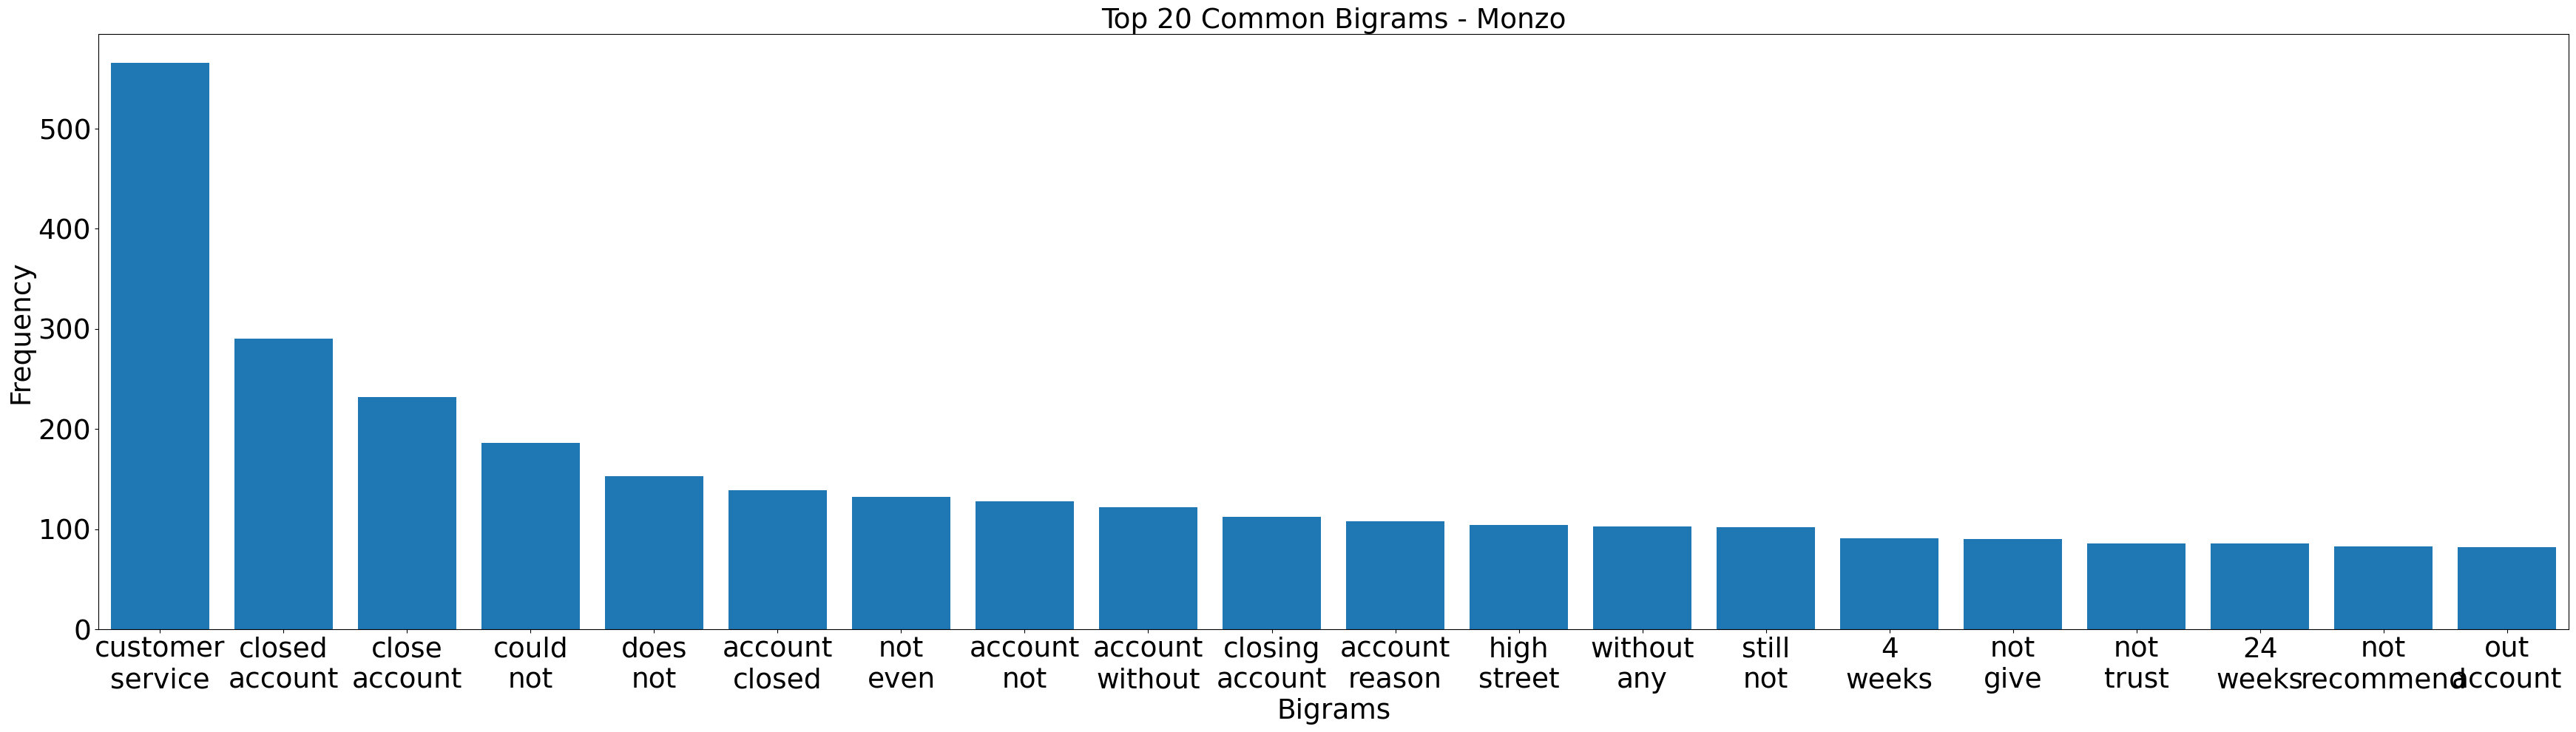

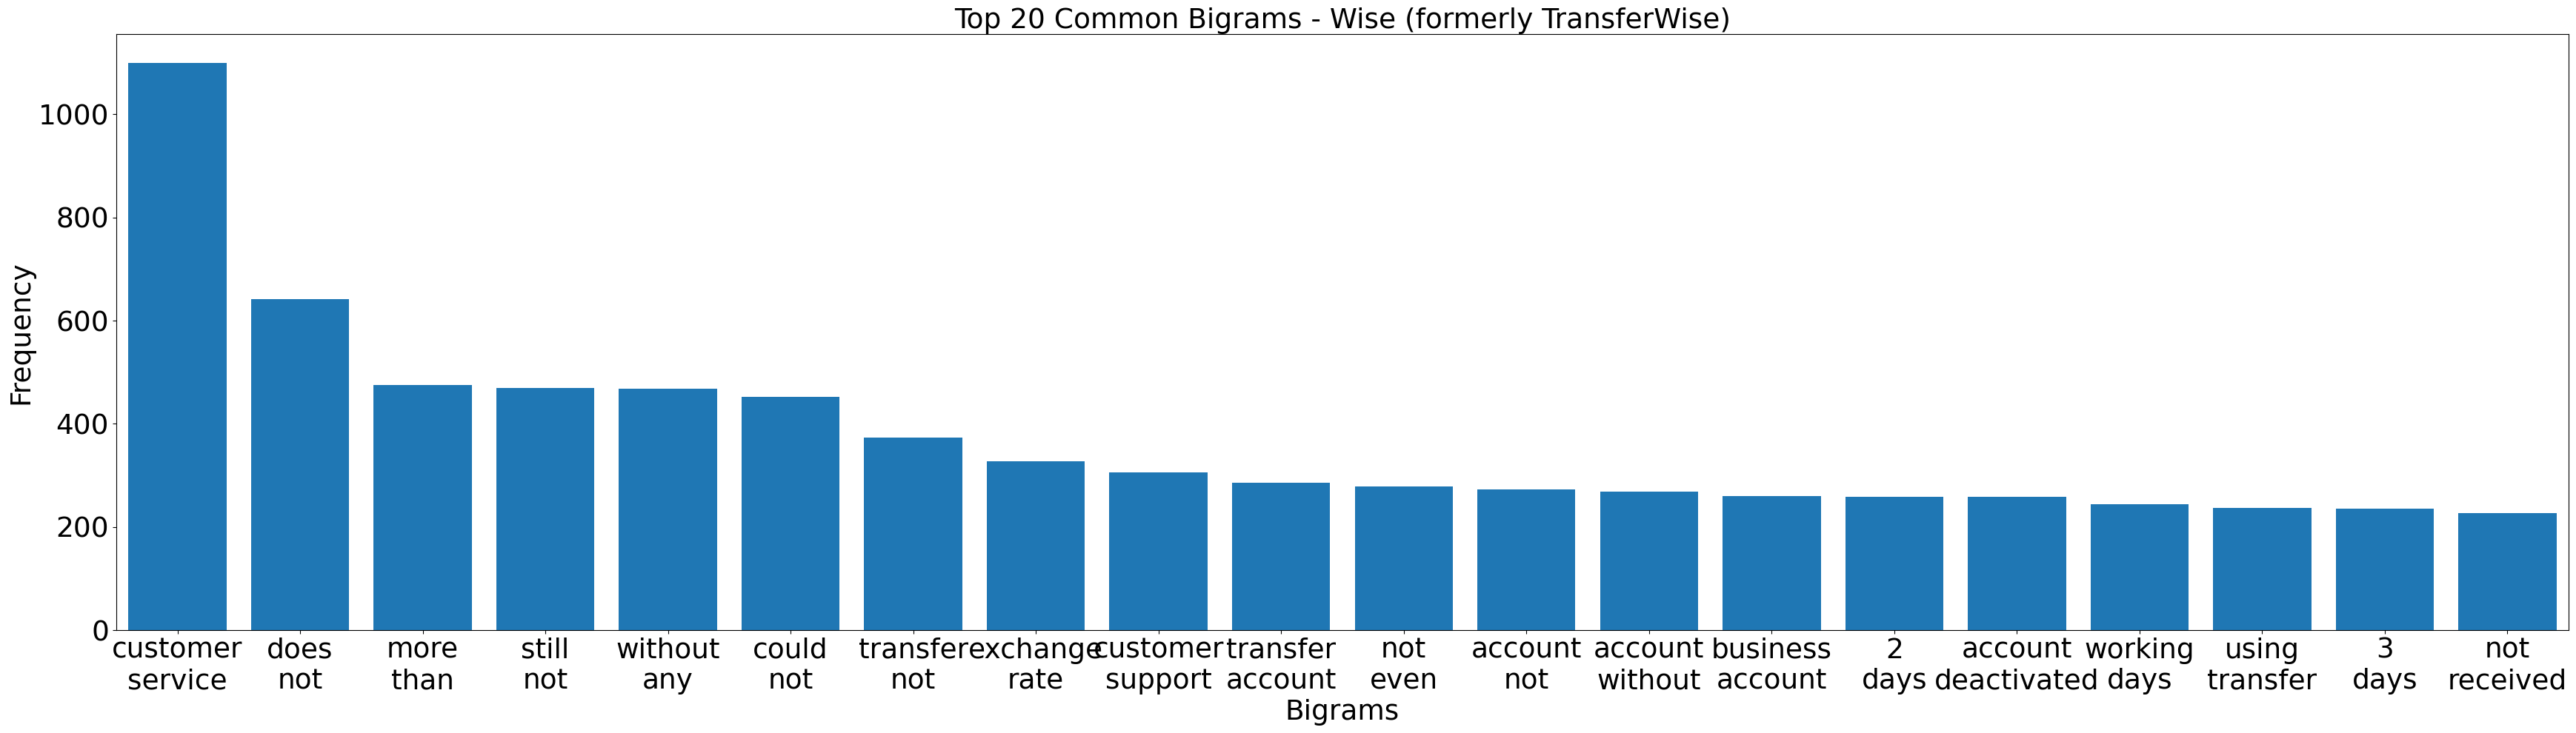

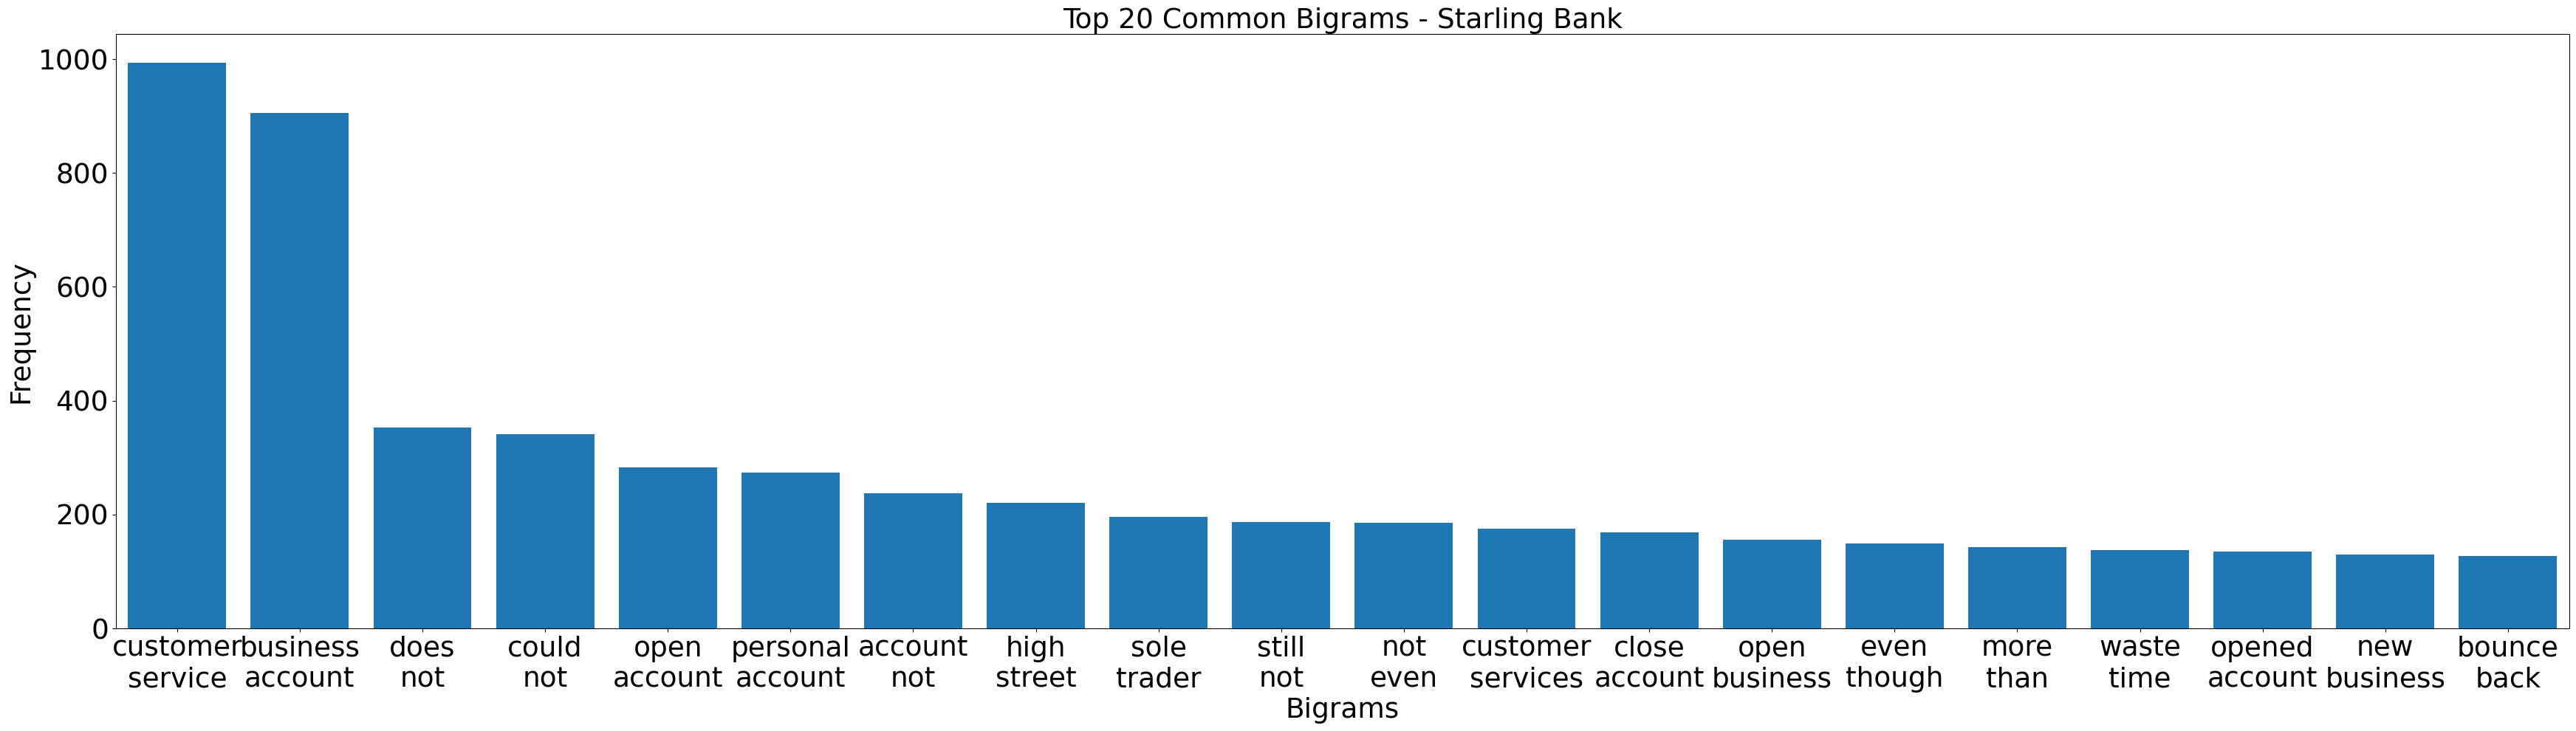

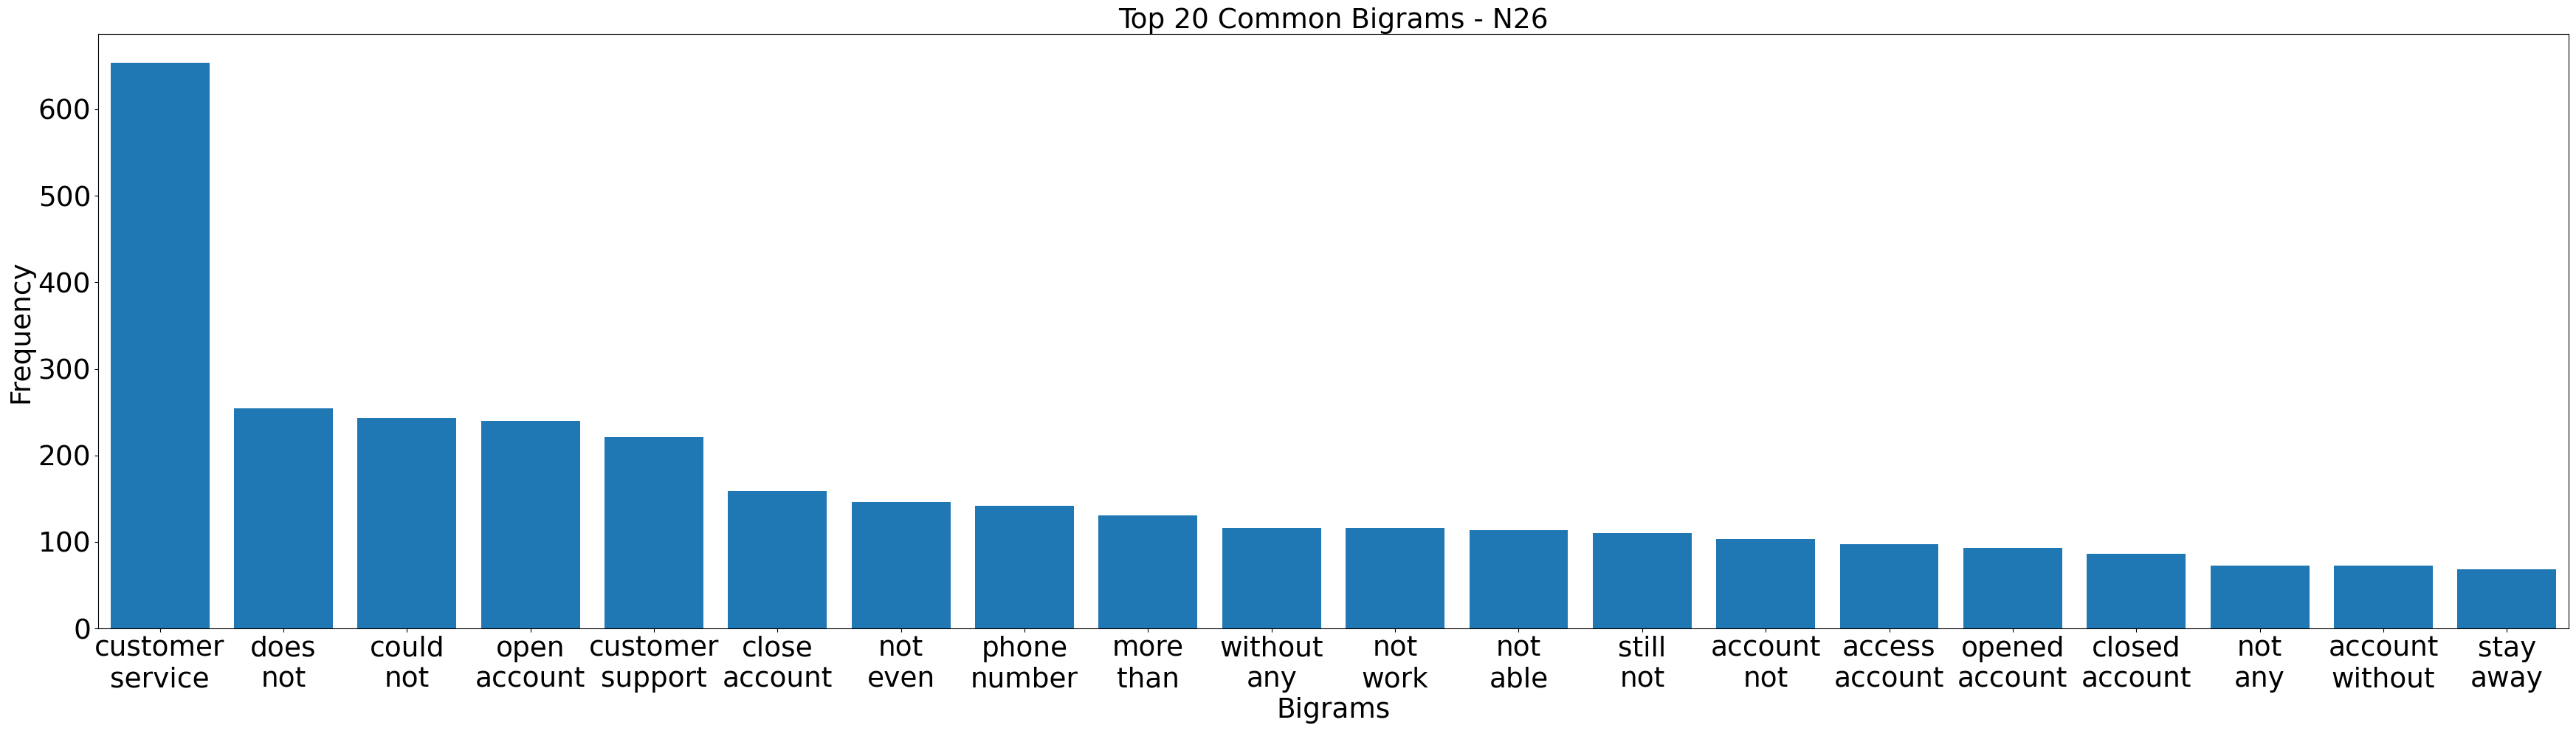

In [ ]:
for bank in bank_names:
    dist_words_bank(df, "after", bank, "poor", 20, "without", 27)

# for bank in bank_names:
#     dist_words_with_bank(df, "after", bank, "poor")

# User Demographic

# 1) Distribution of Images

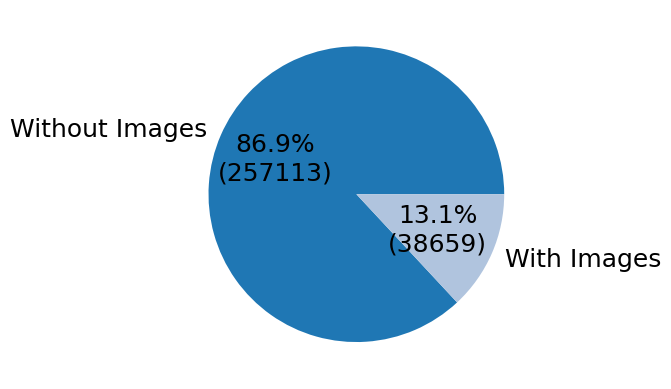

In [ ]:
def label_func(pct, allvals):
  """
  Returns percentage representations and corresponding absolute values
  """
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

# get distribution of users with and without profile photos
pie_values = [len(user_df.loc[user_df.loc[:, "img_flag"] == 0, :]), len(user_df.loc[user_df.loc[:, "img_flag"] == 1, :])]

# plot
plt.pie(pie_values, labels=["Without Images", "With Images"], autopct=lambda pct: label_func(pct, pie_values), 
        colors=["tab:blue", "lightsteelblue"], textprops={'fontsize': 18})
plt.show()

# 2) Distribution of Genders

In [ ]:
# getting count of each gender
gender_tags = ["male", "mostly_male", "female", "mostly_female", "unknown", "andy"]

# user url to gender dictionary
user_gender_dict = dict(zip(user_df.user_url.values, user_df.gender_guesser.values))
df["gender"] = df["user_url"].apply(lambda x: user_gender_dict[x])

def count_gender(df, bank):
  """
  Outputs the distribution of approximated genders
  """
    gender_counts = [len(df.loc[(df.loc[:, "gender"] == tag) & (df.loc[:, "company"] == bank), :]) for tag in gender_tags]
    return gender_counts

# getting distribution of gender for each company
gender_counts_list = []
for bank in bank_names:
    gender_counts_list.append(count_gender(df, bank))
    
# plotting approximate distribution of gender
explode = [0, 0.2, 0, 0.2, 0, 0.2]

def label_func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

labelsize = 30

# plotting distribution of locations
fig, ax = plt.subplots(bank_names_2d.shape[0], 2, figsize=(30, 50))

for i in range(bank_names_2d.shape[0]):
    for j in range(bank_names_2d.shape[1]):
        ax[i, j].set_title(f"Approximated Distribution of Gender for {bank_names_2d[i, j]}", size=labelsize, pad=50)
        ax[i,j].pie(
            gender_counts_list[5*j + i],
            labels=gender_tags,
            radius=1,
            startangle=90,
            counterclock=False,
            shadow=False, 
            explode=explode, colors=['tab:blue', 'tab:orange', 'tab:red', 'tab:green', 'tab:purple', 'tab:cyan'],
            wedgeprops={'edgecolor': 'white', 'linewidth': 1},
            textprops={'fontsize': labelsize},
            autopct=lambda pct: label_func(pct, gender_counts_list[5*j + i]))
        
        plt.tight_layout()

plt.tight_layout()
plt.show()

# 3) Distribution of Location

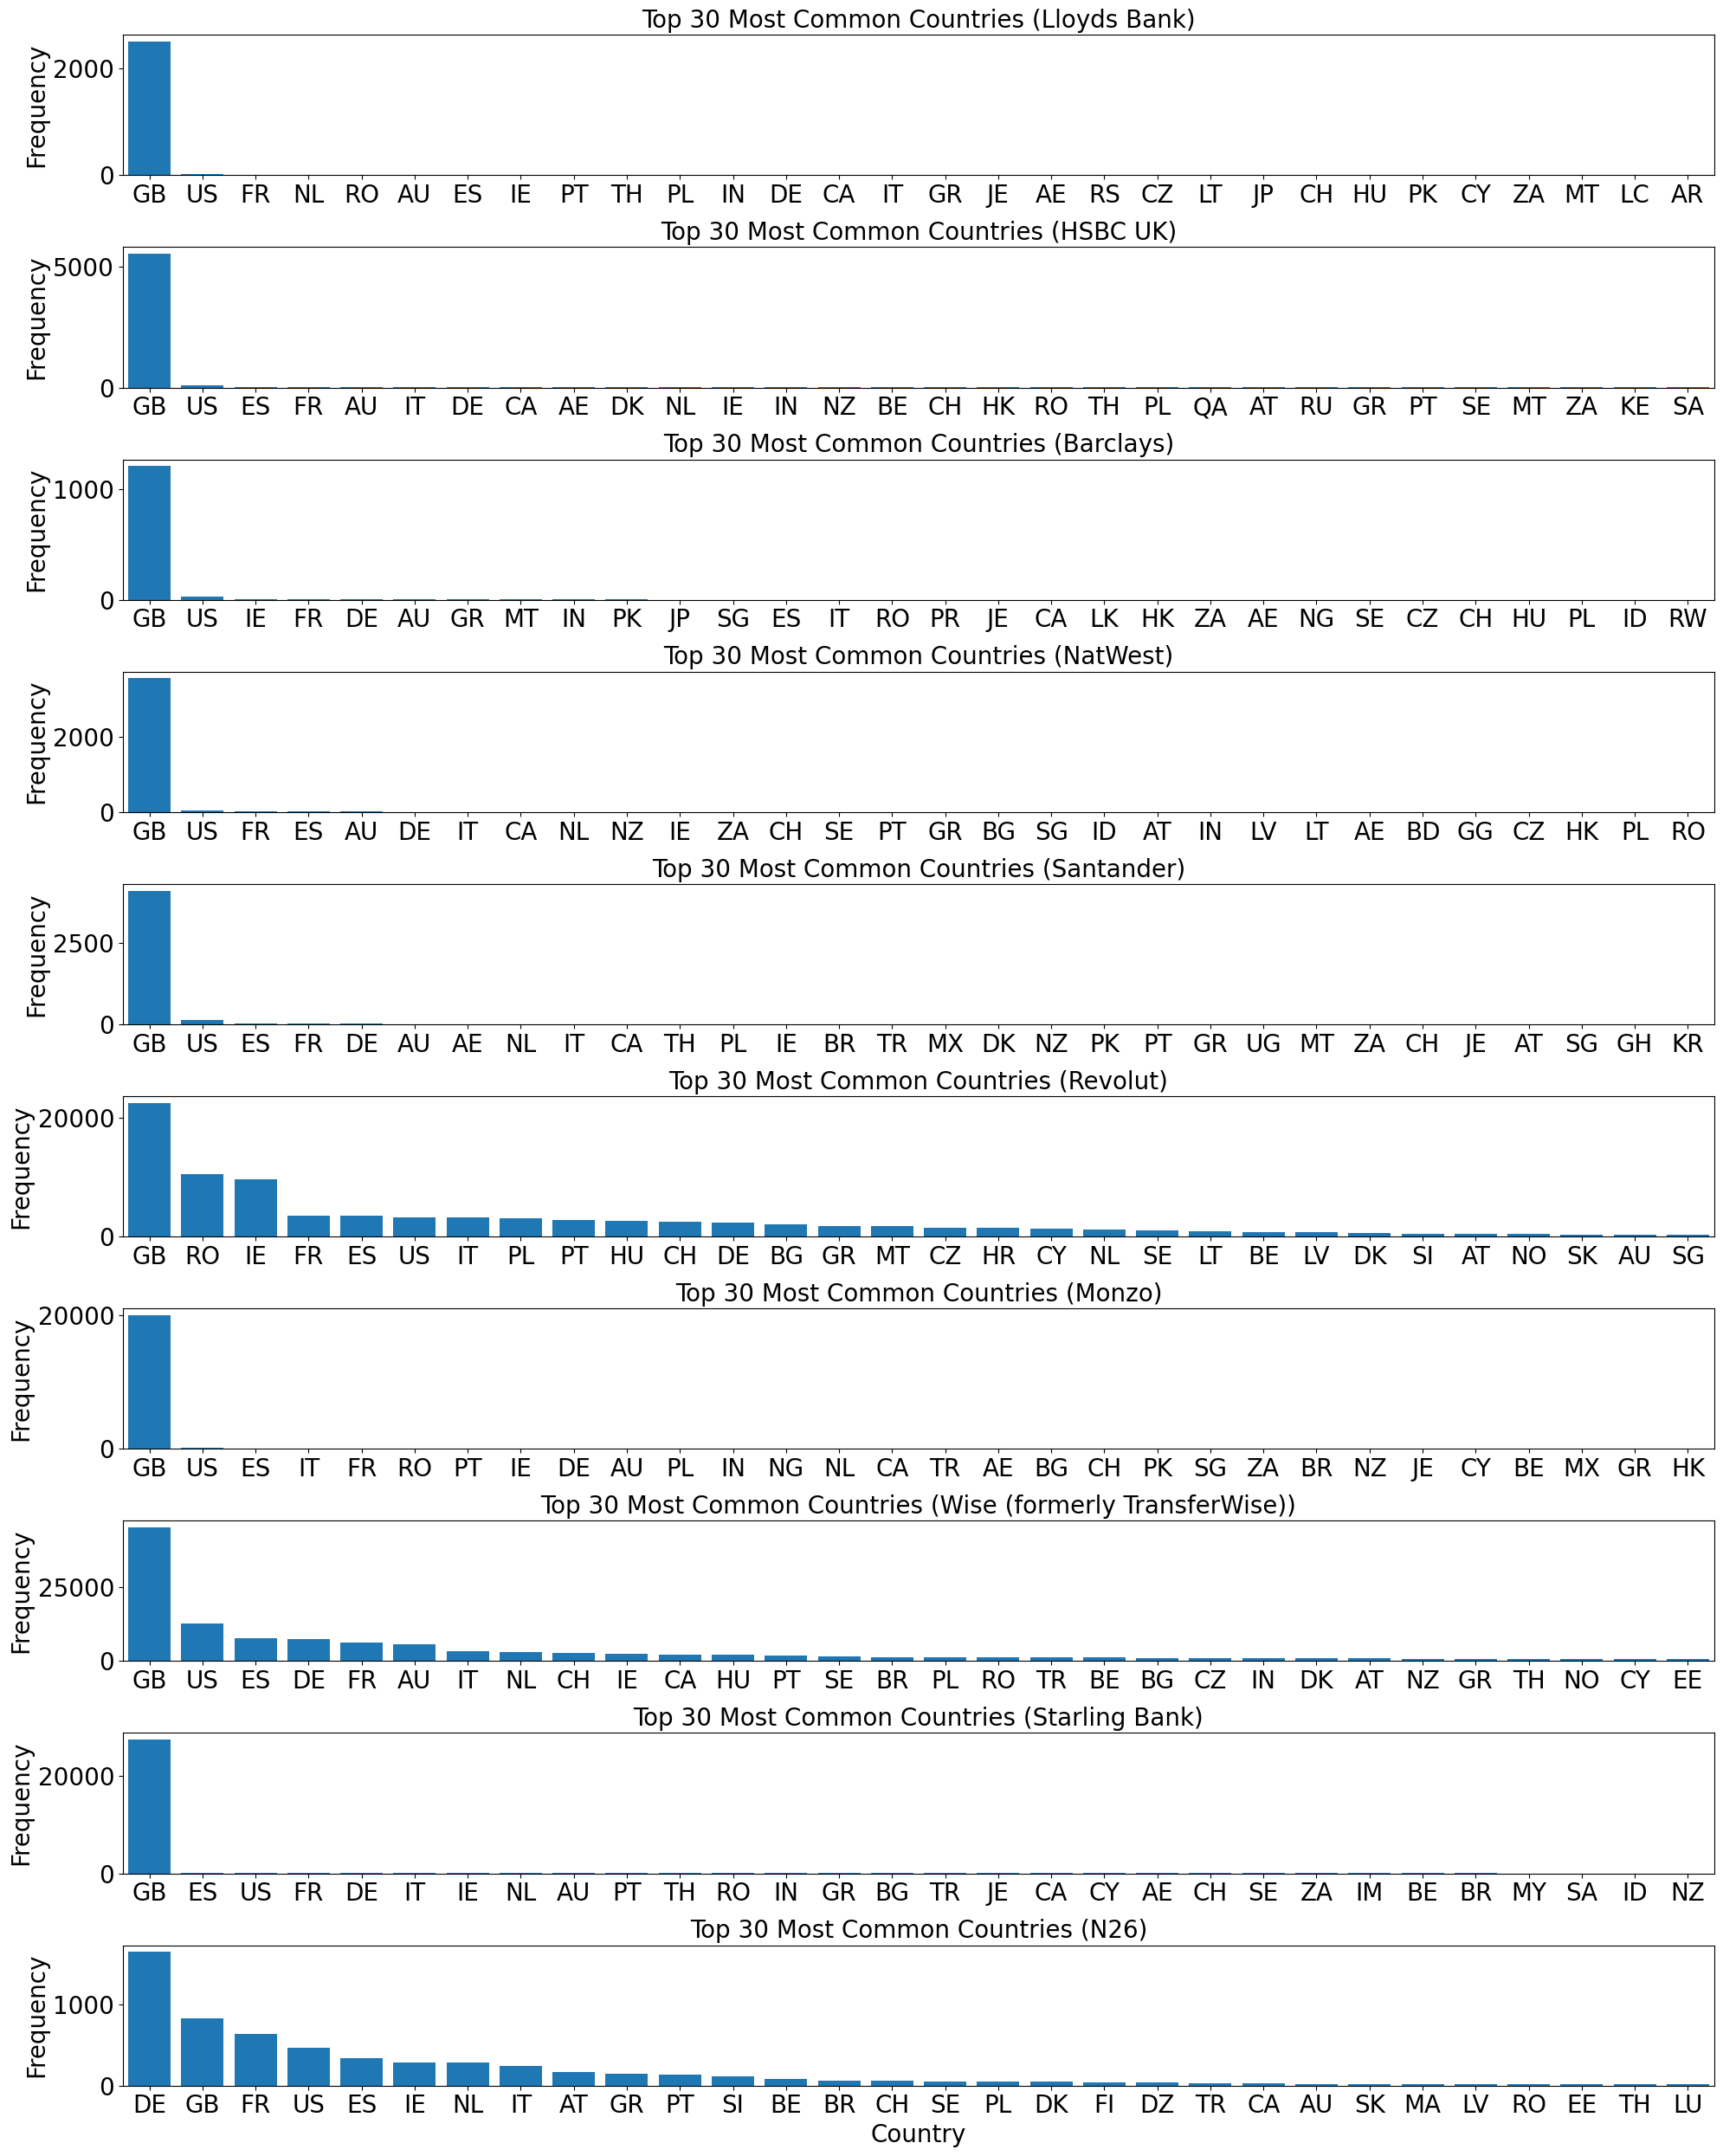

In [ ]:
# function to split dataframe by bank
def splitting_dataframe(df, bank):
  """
  Splits a dataset by bank
  """
    df = df.loc[df.loc[:, "company"] == bank, :]
    return df

# function to return counter of dataframe by country
def review_loc_star(df):
    """
    Return counts of countries users are from
    """
    star_loc_df = df.loc[:, "user_geo_location"]
    all_locations = [location for location in star_loc_df if pd.notna(location)]
    
    # counting countries
    counter = Counter()
    for loc in all_locations:
        counter[loc] += 1
    
    return counter

# getting list of counters by bank
counter_list = []
for bank in bank_names:
    counter_list.append(review_loc_star(splitting_dataframe(df, bank)))

labelsize = 20    

# plotting distribution of locations
fig, ax = plt.subplots(len(counter_list), 1, figsize=(20, 25))
for i in range(len(counter_list)):
    ax[i].set_title(f"Top 30 Most Common Countries ({bank_names[i]})", size=labelsize)
    ax[i].bar([country for (country, count) in counter_list[i].most_common(30)], [count for (country, count) in counter_list[i].most_common(30)])
    ax[i].set_xlim(-0.5,30-.5)
    ax[i].set_ylabel("Frequency", size=labelsize)
    ax[i].tick_params(axis='x', which='major', labelsize=labelsize)
    ax[i].tick_params(axis='y', which='major', labelsize=labelsize)
ax[i].set_xlabel("Country", size=labelsize)
plt.tight_layout()
plt.show()